In [50]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

In [51]:
x_lower_bound = 0
x_upper_bound = 10
y_lower_bound = 0
y_upper_bound = 10

a = {}

In [52]:
class Island:
    def __init__(self, xcentr = 5, ycentr = 5, radius = 1):
        self.xcentr = xcentr
        self.ycentr = ycentr
        self.radius = radius
    def belongs_to_boarder(self, x, y):
        if ((x - self.xcentr)**2 + (y - self.ycentr)**2 <= self.radius**2):
            return True
        else:
            return False
    def draw_island(self):
        return plt.Circle((self.xcentr, self.ycentr), self.radius)

In [53]:
class Ship:
    def __init__(self, x = 1, y = 5, v = 1, direction = 0):
        self.x = x
        self.y = y
        self.v = v
        self.direction = direction
        self.positions = [[self.x, self.y]]
    def move(self):
        self.x = self.x + 5
        self.y = self.y + 5
    def getCoords(self):
        return self.x, self.y
    def add_position(self):
        self.positions.append([self.x, self.y])
    def get_positions(self):
        return self.positions

In [84]:
class Environment(object):
    def __init__(self):
        super(Environment, self).__init__()
        self.action_space = ['up', 'down', 'left', 'right']
        self.n_actions = len(self.action_space)
        self.n_features = 2

        self.build_environment()
        
        self.route = []
        self.list_of_route = []
        self.d = {}
        self.f = {}

        self.i = 0

        self.c = True

        self.longest = 0

        self.shortest = 0

    def build_environment(self):
        self.island = Island()
        self.flag = Island(9.5, 5, 0.5)
        self.ship = Ship()
    
    def reset(self):
        self.build_environment()
        self.d = {}
        self.i = 0
        return self.ship.getCoords();
    
    def step(self, action):
        dt = 1
        
        state = self.ship.getCoords()
        base_action = np.array([0, 0])

        if action == 0:
            if state[1] < y_upper_bound:
                base_action[1] += 1
        elif action == 1:
            if state[1] > y_lower_bound:
                base_action[1] -= 1
        elif action == 2:
            if state[0] < x_upper_bound:
                base_action[0] += 1
        elif action == 3:
            if state[0] > x_lower_bound:
                base_action[0] -= 1

        self.ship.x += base_action[0]
        self.ship.y += base_action[1]
        
        self.ship.add_position()
        self.d[self.i] = self.ship.getCoords()

        next_state = self.d[self.i]

        self.i += 1
        
        if (self.flag.belongs_to_boarder(next_state[0], next_state[1])):
            reward = 100
            done = True
            next_state = self.ship.getCoords()

        elif (self.island.belongs_to_boarder(next_state[0], next_state[1])):
            reward = -100
            done = True
            next_state = self.ship.getCoords()

            self.d = {}
            self.i = 0

        else:
                reward = 0
                done = False

        return next_state, reward, done 
    
    def draw_map(self):
        self.field, self.ax = plt.subplots()
        self.ax.set(xlim=(x_lower_bound, x_upper_bound), ylim=(y_lower_bound, y_upper_bound))
        self.ax.set_aspect(1)     
        self.ax.add_artist(self.island.draw_island())
        self.ax.add_artist(self.flag.draw_island())
        self.pos = self.ship.get_positions()
        for i in range(len(self.pos) - 1):
            self.ax.plot([self.pos[i][0], self.pos[i+1][0]], [self.pos[i][1], self.pos[i+1][1]], marker = 'o')
        plt.show()

    def final(self):
        print('The shortest route:', self.shortest)
        print('The longest route:', self.longest)

def final_states():
    return a

if __name__ == '__main__':
    env = Environment()

In [85]:
BATCH_SIZE = 100
LR = 0.01
GAMMA = 0.90
EPSILON = 0.9
MEMORY_CAPACITY = 10000
Q_NETWORK_ITERATION = 1000

env = Environment()
NUM_ACTIONS = env.n_actions
NUM_STATES = 2
EPISODES = 1000

In [86]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 50)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(50, NUM_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [87]:
class DQN():
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), LR)
        self.loss = nn.MSELoss()
        
    def store_trans(self, state, action, reward, next_state):
        if self.memory_counter % 500 == 0:
            print("!")
        index = self.memory_counter % MEMORY_CAPACITY
        trans = np.hstack((state, action, reward, next_state))
        self.memory[index, :] = trans
        self.memory_counter += 1
        
    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state), 0)
        if np.random.randn() <= EPSILON:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy()
            action = action[0]
        else:
            action = np.random.randint(0, NUM_ACTIONS)
        return action
    
    def learn(self):
        # learn 100 times then the target network update
        if self.learn_counter % Q_NETWORK_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        #note that the action must be a int
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])

        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA*q_next.max(1)[0].view(BATCH_SIZE, 1)

        loss = self.loss(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

The DQN is collecting experience...
!


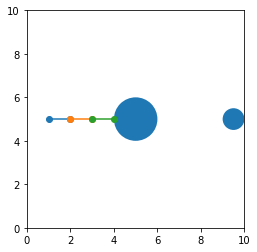

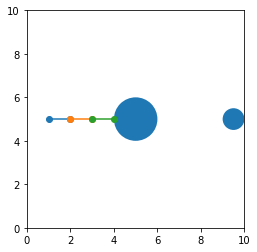

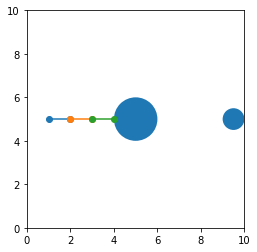

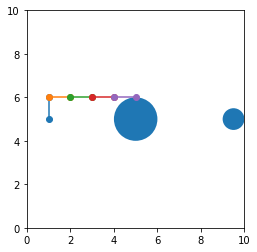

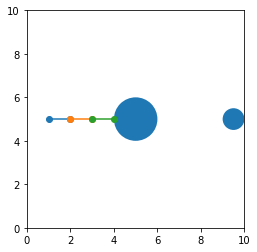

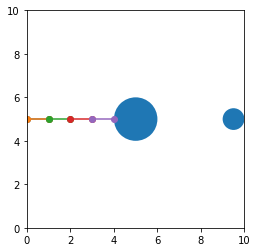

!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
!
episode 6, the reward is 100


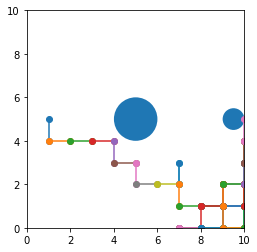

!
!
!
!
episode 7, the reward is 100


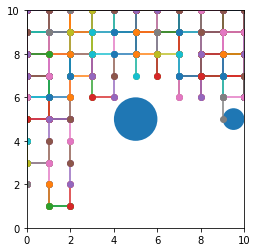

episode 8, the reward is 100


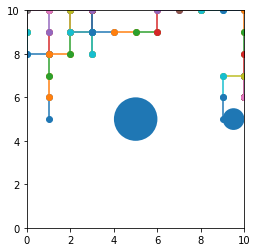

episode 9, the reward is 100


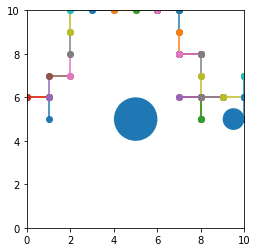

episode 10, the reward is 100


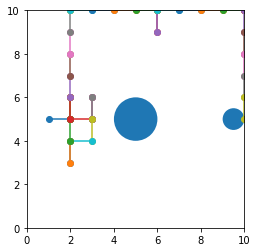

episode 11, the reward is 100


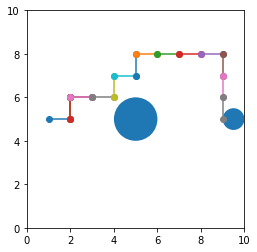

episode 12, the reward is -100


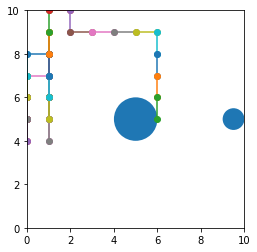

!
episode 13, the reward is -100


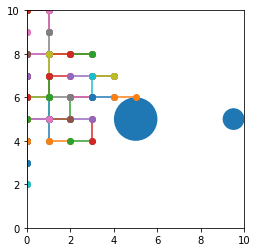

episode 14, the reward is 100


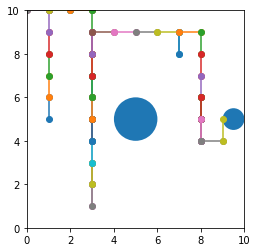

episode 15, the reward is 100


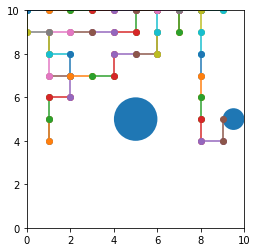

episode 16, the reward is -100


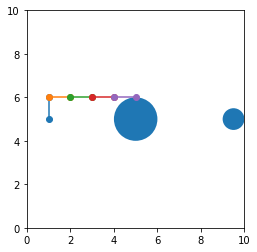

episode 17, the reward is 100


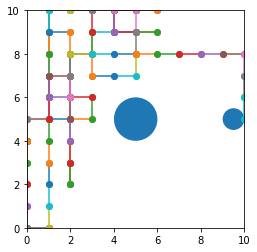

episode 18, the reward is -100


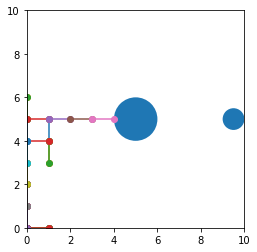

!
episode 19, the reward is -100


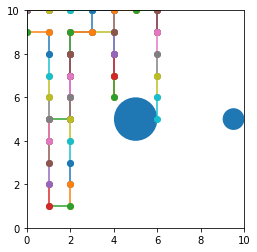

episode 20, the reward is -100


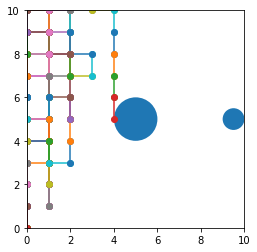

!
episode 21, the reward is 100


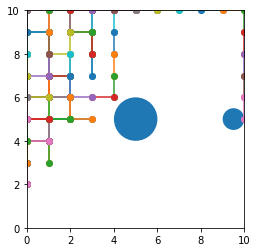

!
!
!
!
episode 22, the reward is -100


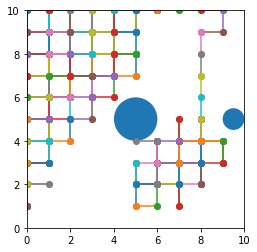

!
!
!
!
!
!
episode 23, the reward is 100


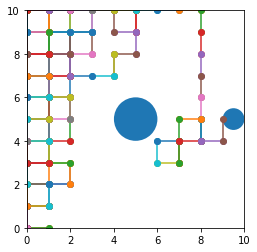

!
episode 24, the reward is 100


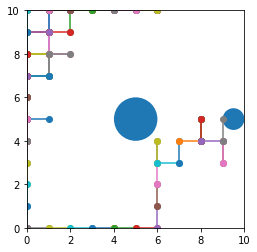

episode 25, the reward is 100


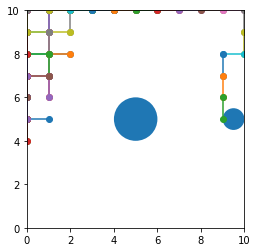

!
episode 26, the reward is 100


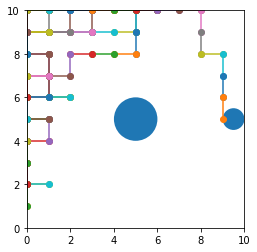

episode 27, the reward is 100


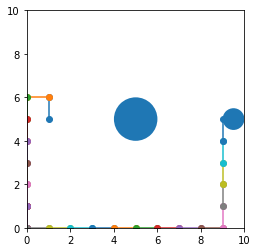

!
episode 28, the reward is 100


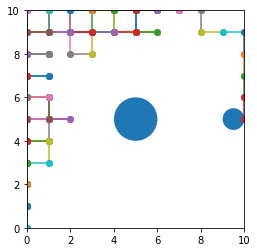

episode 29, the reward is 100


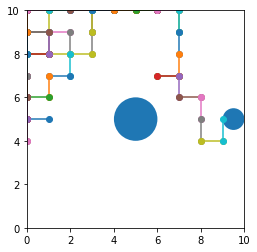

episode 30, the reward is 100


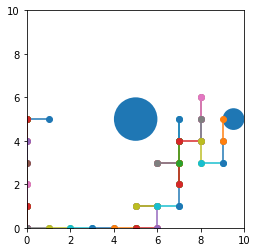

episode 31, the reward is 100


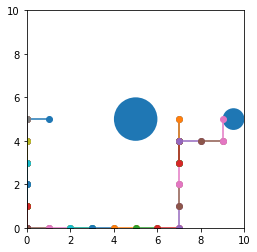

!
!
episode 32, the reward is 100


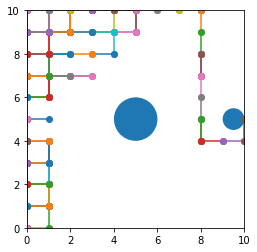

!
!
!
episode 33, the reward is -100


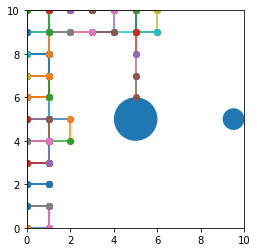

!
!
!
!
!
episode 34, the reward is 100


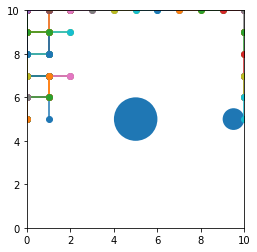

!
!
episode 35, the reward is 100


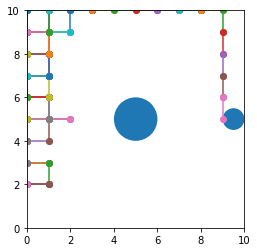

episode 36, the reward is 100


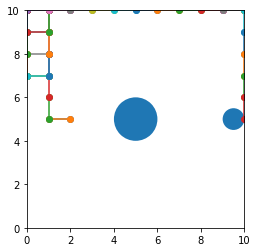

episode 37, the reward is 100


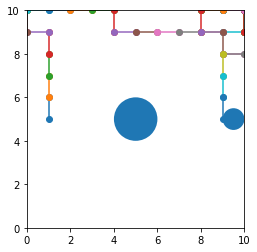

episode 38, the reward is 100


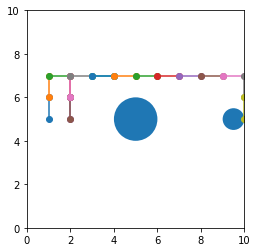

episode 39, the reward is 100


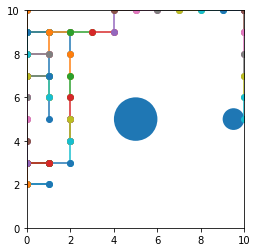

episode 40, the reward is 100


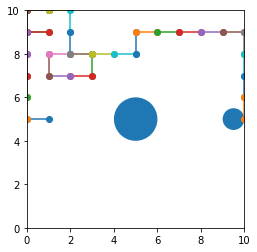

episode 41, the reward is -100


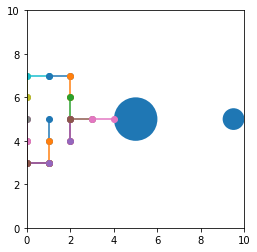

episode 42, the reward is 100


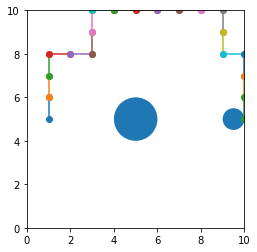

episode 43, the reward is 100


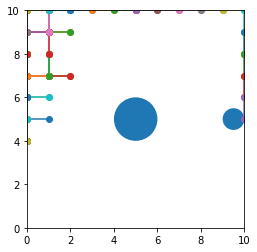

!
episode 44, the reward is 100


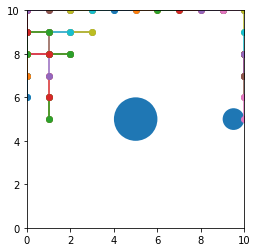

episode 45, the reward is 100


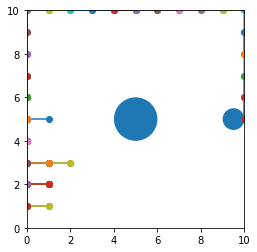

episode 46, the reward is 100


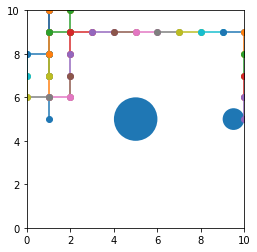

episode 47, the reward is 100


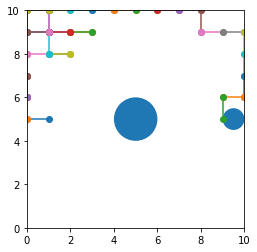

episode 48, the reward is 100


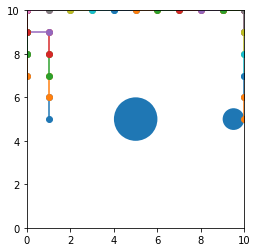

episode 49, the reward is 100


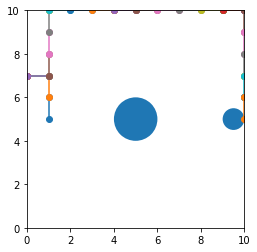

episode 50, the reward is 100


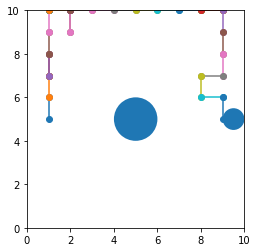

episode 51, the reward is -100


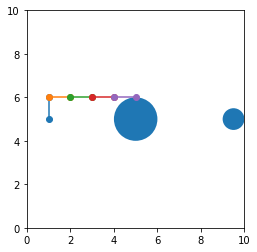

!
episode 52, the reward is 100


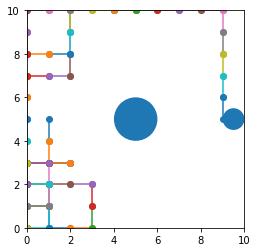

episode 53, the reward is 100


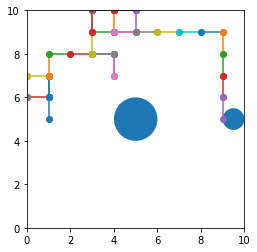

episode 54, the reward is 100


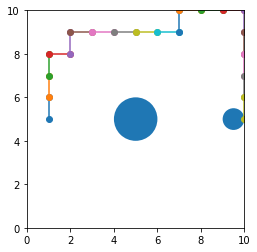

episode 55, the reward is 100


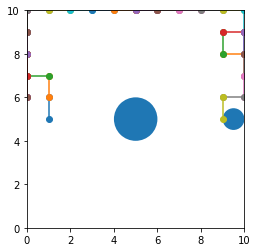

episode 56, the reward is 100


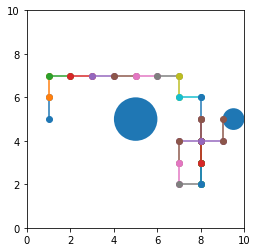

episode 57, the reward is 100


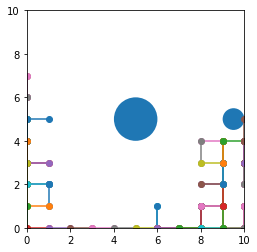

!
episode 58, the reward is 100


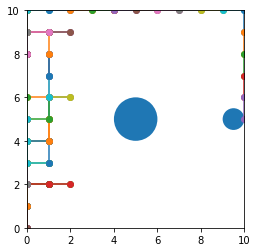

episode 59, the reward is 100


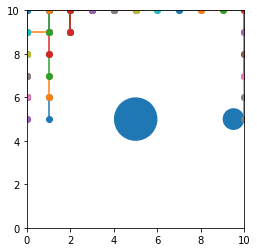

episode 60, the reward is 100


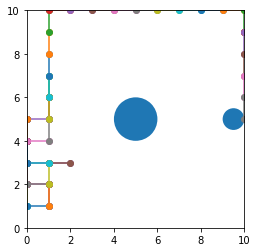

episode 61, the reward is 100


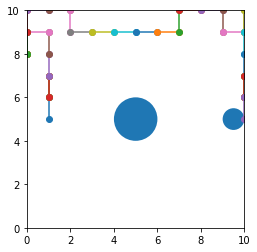

episode 62, the reward is 100


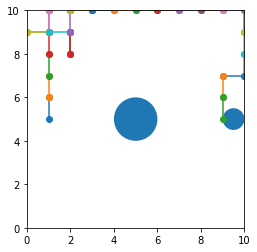

episode 63, the reward is 100


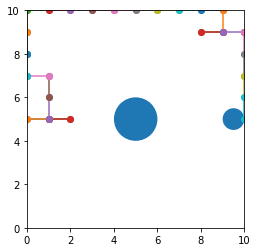

!
episode 64, the reward is 100


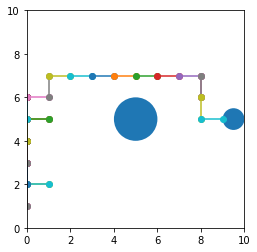

episode 65, the reward is 100


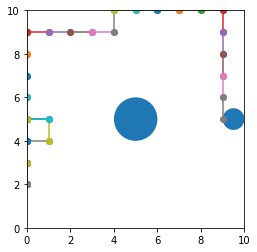

episode 66, the reward is 100


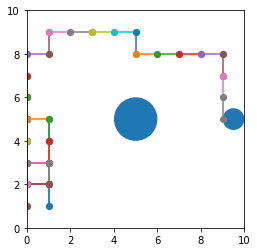

episode 67, the reward is 100


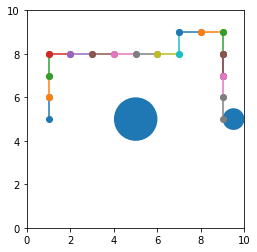

episode 68, the reward is -100


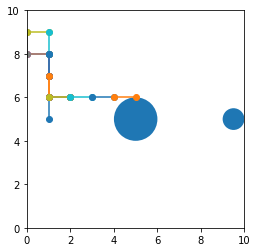

episode 69, the reward is 100


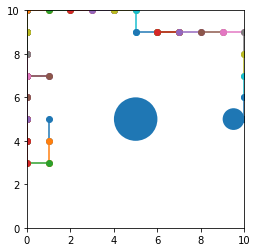

!
episode 70, the reward is 100


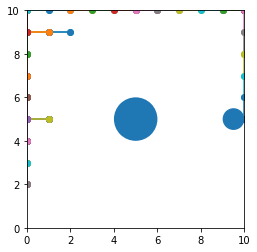

episode 71, the reward is 100


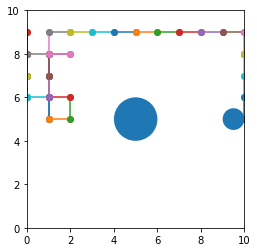

episode 72, the reward is 100


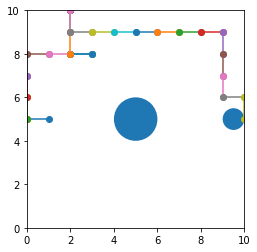

episode 73, the reward is -100


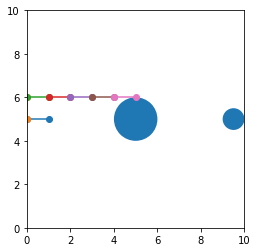

episode 74, the reward is 100


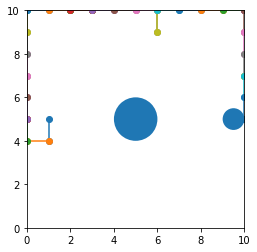

episode 75, the reward is 100


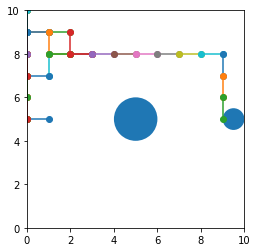

episode 76, the reward is 100


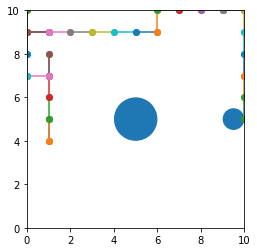

episode 77, the reward is 100


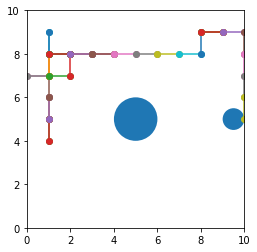

episode 78, the reward is 100


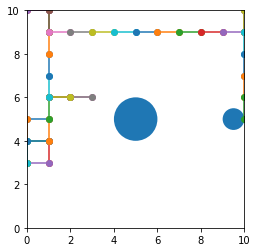

episode 79, the reward is 100


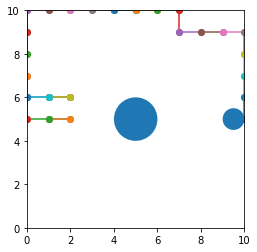

episode 80, the reward is 100


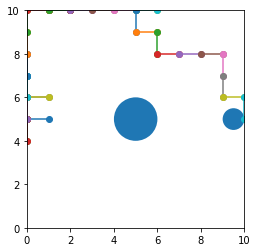

!
episode 81, the reward is 100


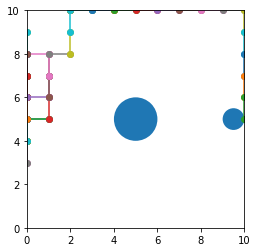

episode 82, the reward is 100


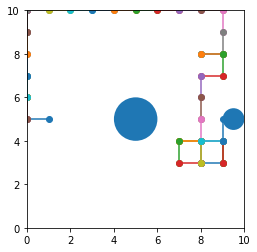

episode 83, the reward is 100


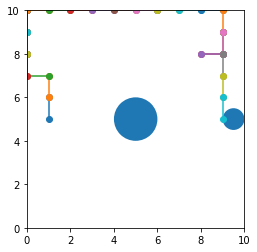

episode 84, the reward is 100


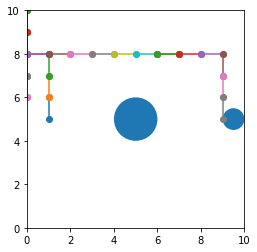

episode 85, the reward is 100


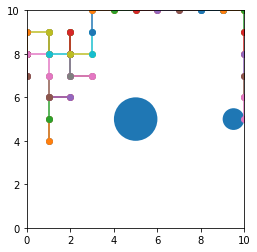

episode 86, the reward is 100


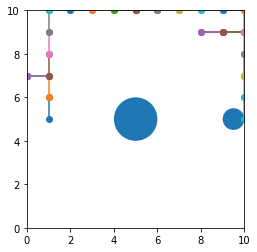

episode 87, the reward is 100


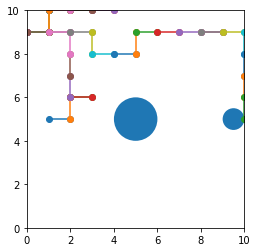

episode 88, the reward is 100


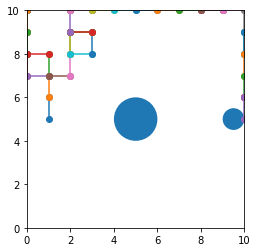

episode 89, the reward is 100


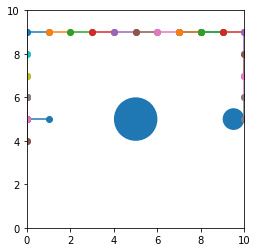

episode 90, the reward is 100


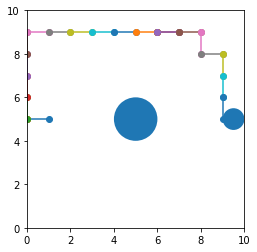

episode 91, the reward is 100


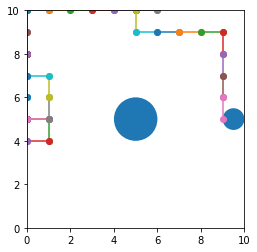

!
episode 92, the reward is 100


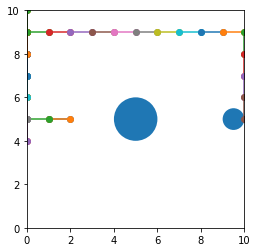

episode 93, the reward is 100


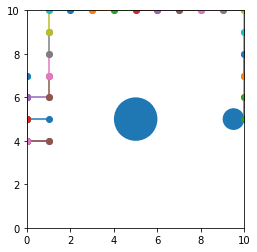

episode 94, the reward is 100


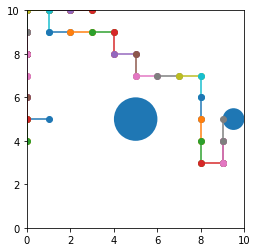

episode 95, the reward is 100


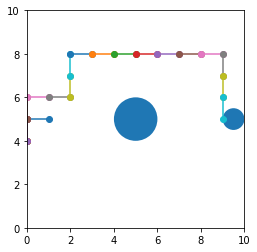

episode 96, the reward is 100


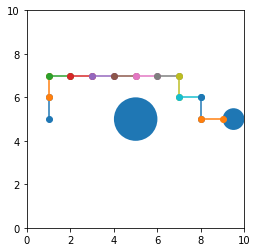

episode 97, the reward is 100


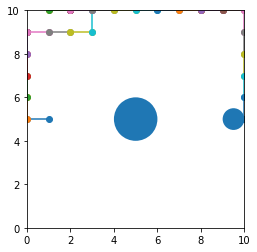

episode 98, the reward is 100


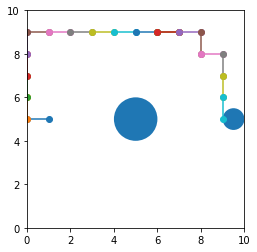

episode 99, the reward is 100


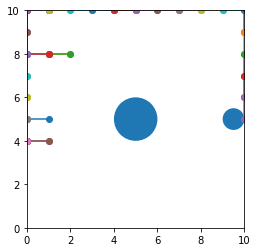

episode 100, the reward is 100


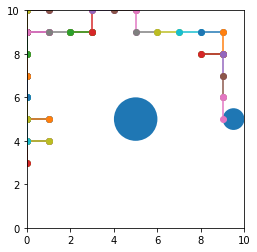

episode 101, the reward is 100


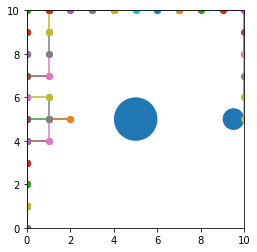

episode 102, the reward is 100


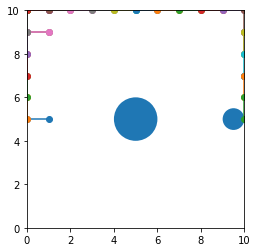

!
episode 103, the reward is 100


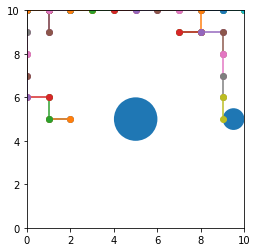

episode 104, the reward is 100


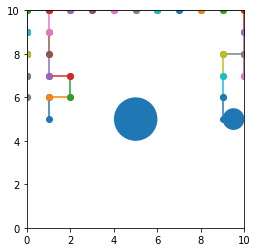

episode 105, the reward is 100


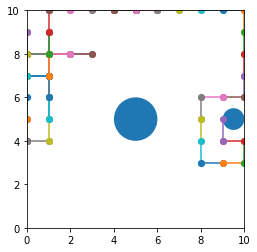

episode 106, the reward is 100


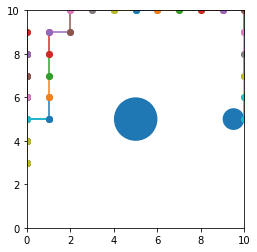

episode 107, the reward is 100


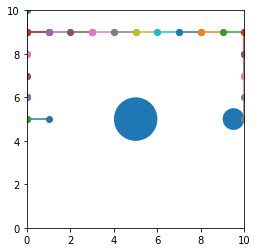

episode 108, the reward is -100


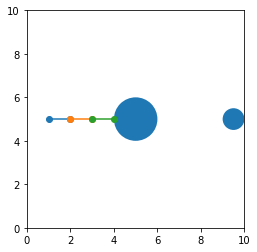

episode 109, the reward is 100


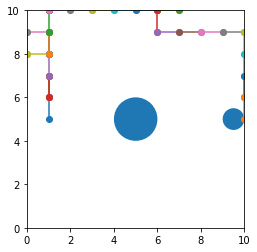

episode 110, the reward is 100


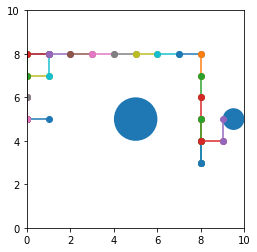

episode 111, the reward is 100


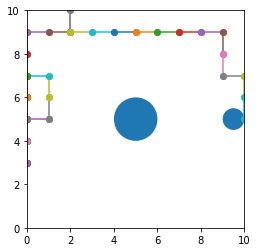

episode 112, the reward is 100


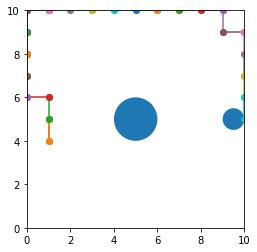

episode 113, the reward is 100


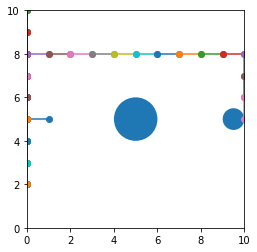

episode 114, the reward is 100


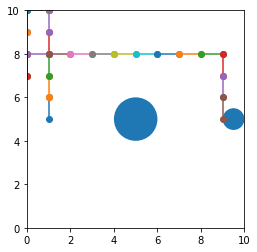

episode 115, the reward is 100


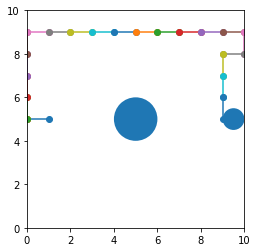

episode 116, the reward is -100


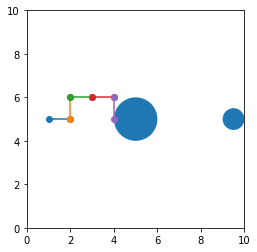

!
episode 117, the reward is 100


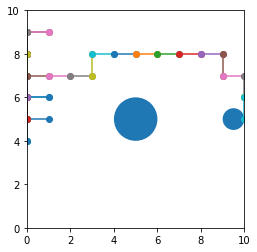

episode 118, the reward is 100


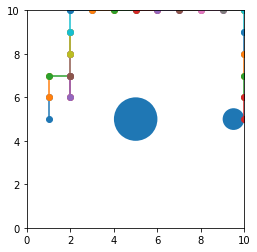

episode 119, the reward is 100


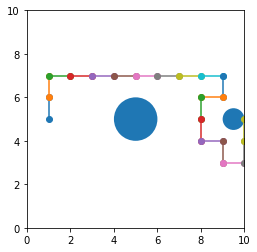

episode 120, the reward is 100


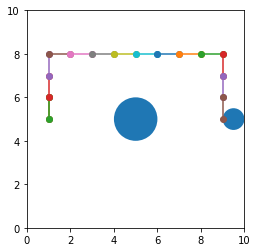

episode 121, the reward is 100


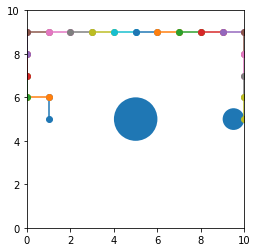

episode 122, the reward is 100


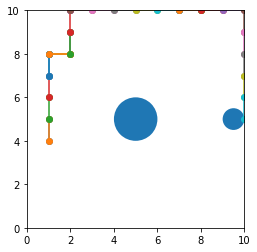

episode 123, the reward is 100


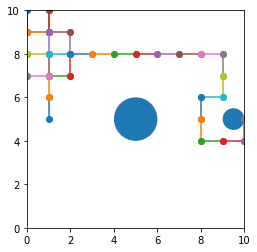

episode 124, the reward is 100


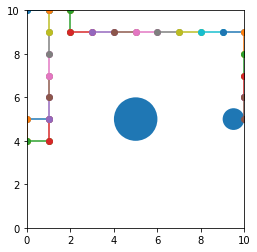

episode 125, the reward is 100


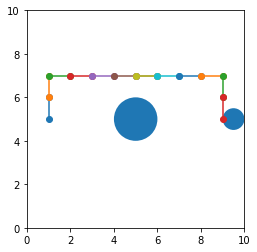

episode 126, the reward is 100


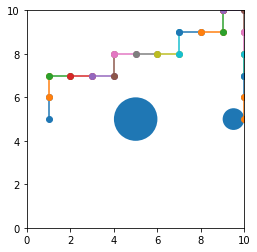

episode 127, the reward is 100


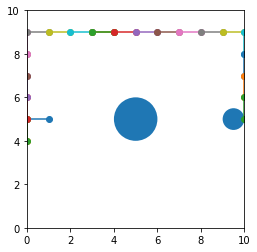

episode 128, the reward is -100


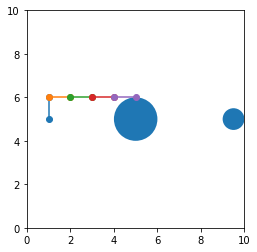

episode 129, the reward is 100


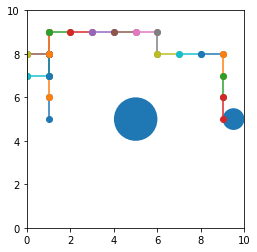

episode 130, the reward is 100


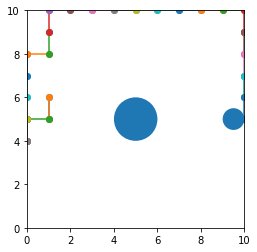

episode 131, the reward is 100


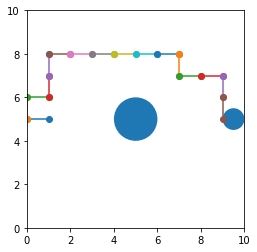

episode 132, the reward is 100


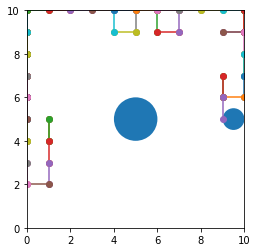

episode 133, the reward is 100


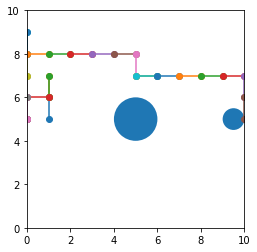

episode 134, the reward is 100


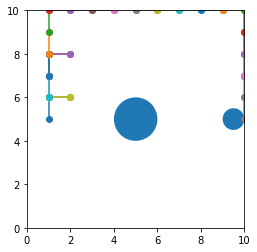

episode 135, the reward is 100


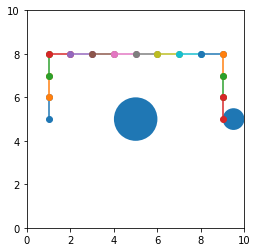

episode 136, the reward is 100


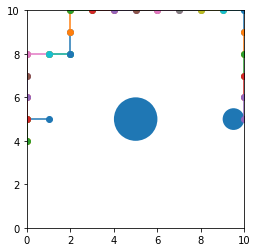

episode 137, the reward is -100


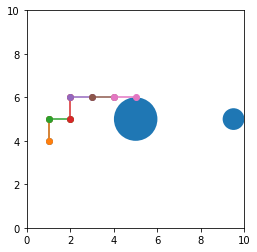

!
episode 138, the reward is 100


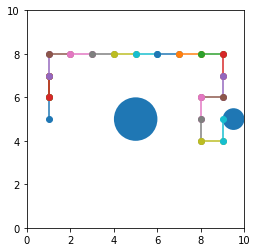

episode 139, the reward is 100


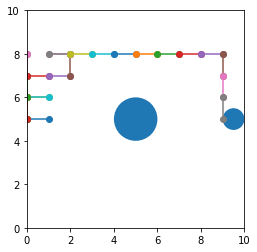

episode 140, the reward is -100


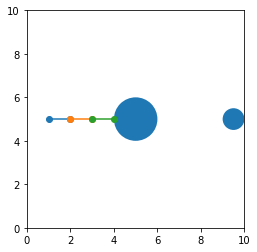

episode 141, the reward is 100


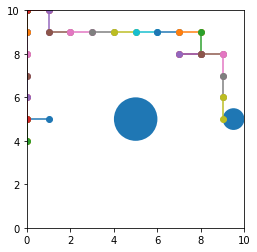

episode 142, the reward is 100


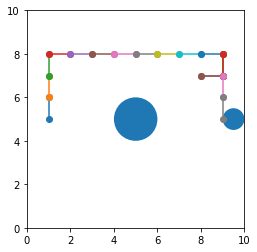

episode 143, the reward is -100


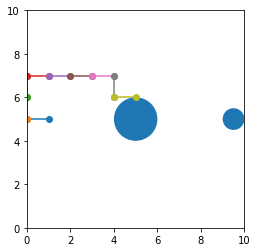

episode 144, the reward is 100


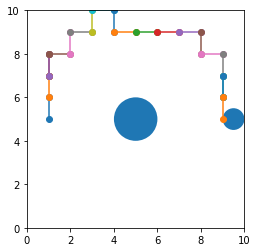

episode 145, the reward is 100


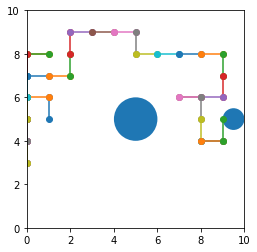

episode 146, the reward is -100


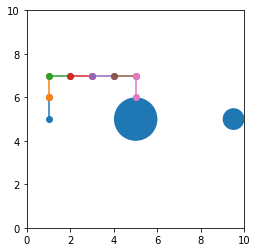

episode 147, the reward is 100


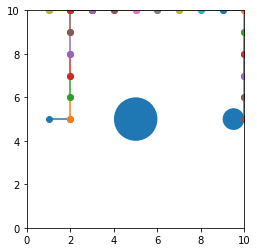

episode 148, the reward is 100


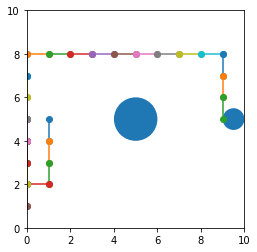

episode 149, the reward is -100


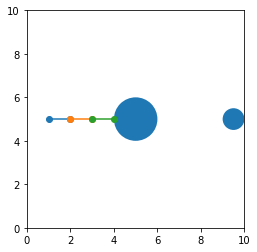

episode 150, the reward is 100


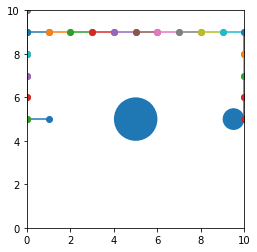

episode 151, the reward is -100


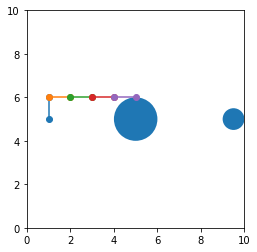

episode 152, the reward is 100


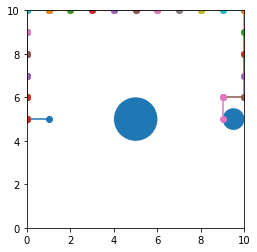

episode 153, the reward is 100


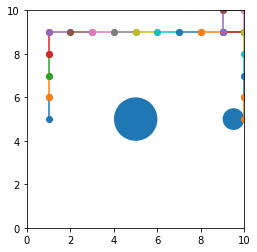

episode 154, the reward is 100


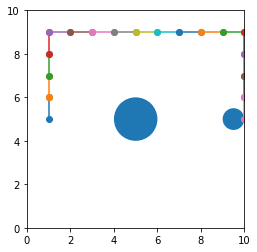

episode 155, the reward is 100


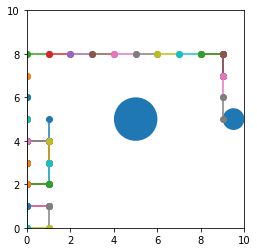

episode 156, the reward is -100


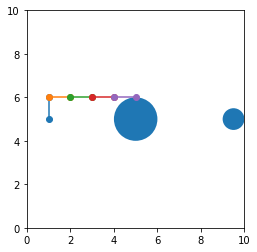

episode 157, the reward is 100


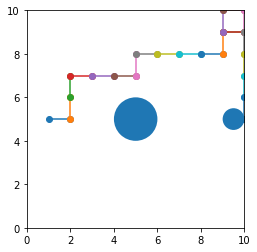

episode 158, the reward is 100


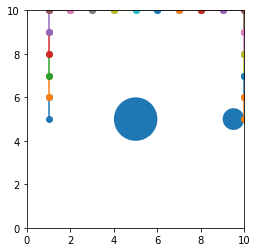

!
episode 159, the reward is 100


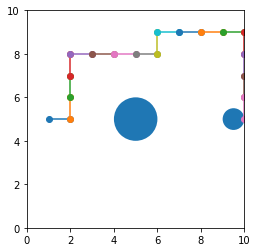

episode 160, the reward is 100


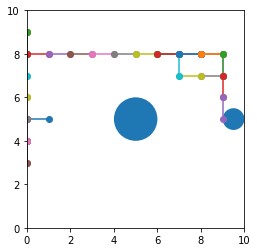

episode 161, the reward is 100


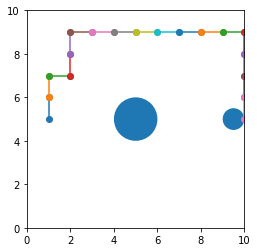

episode 162, the reward is -100


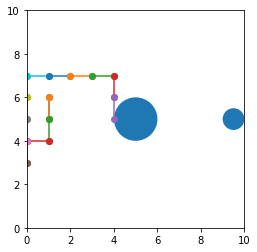

episode 163, the reward is 100


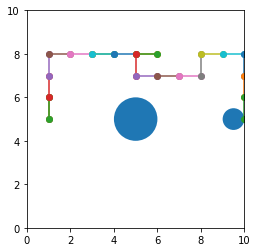

episode 164, the reward is 100


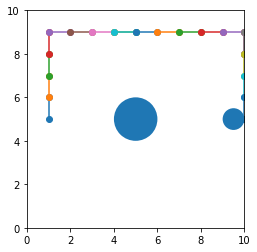

episode 165, the reward is -100


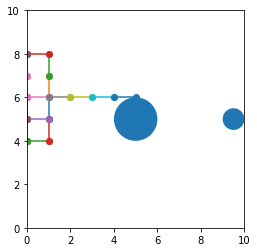

episode 166, the reward is 100


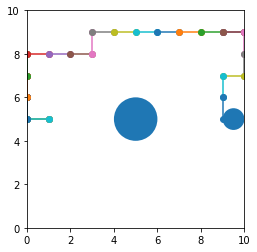

episode 167, the reward is 100


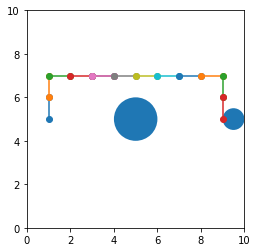

episode 168, the reward is 100


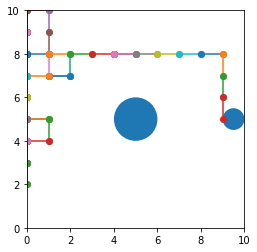

episode 169, the reward is 100


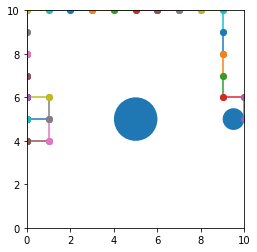

episode 170, the reward is -100


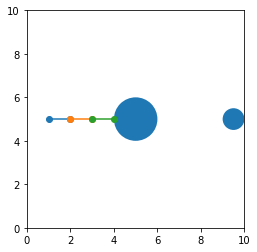

episode 171, the reward is -100


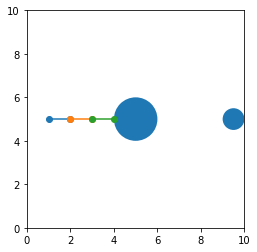

episode 172, the reward is 100


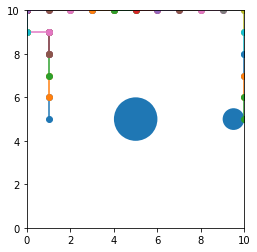

episode 173, the reward is 100


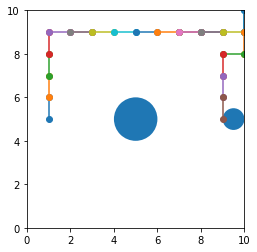

episode 174, the reward is 100


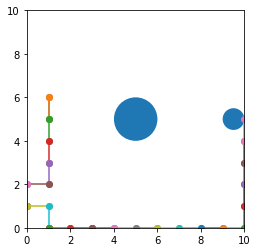

episode 175, the reward is -100


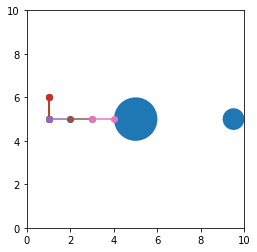

episode 176, the reward is 100


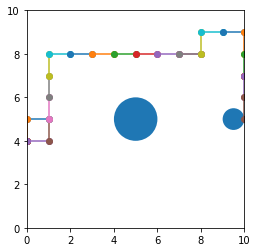

episode 177, the reward is 100


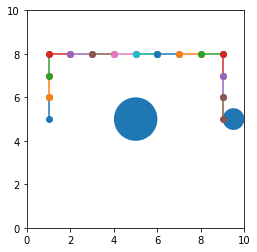

!
episode 178, the reward is 100


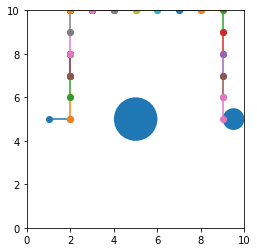

episode 179, the reward is 100


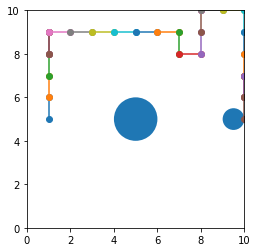

episode 180, the reward is 100


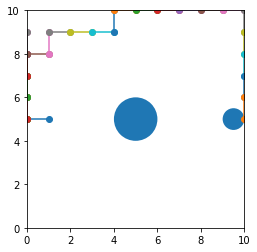

episode 181, the reward is -100


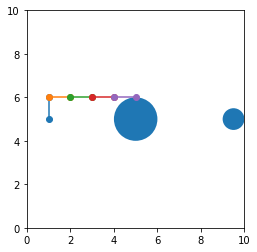

episode 182, the reward is 100


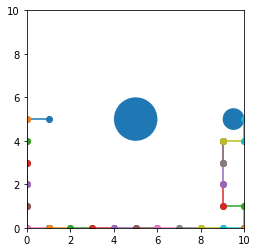

episode 183, the reward is 100


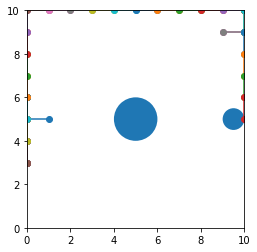

episode 184, the reward is 100


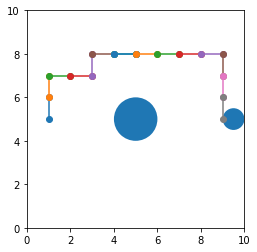

episode 185, the reward is 100


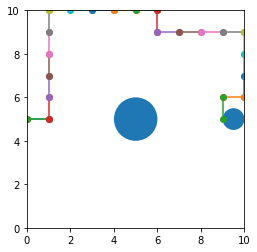

episode 186, the reward is 100


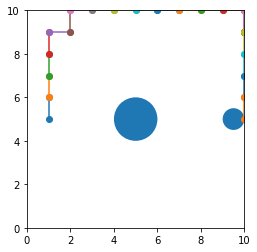

episode 187, the reward is -100


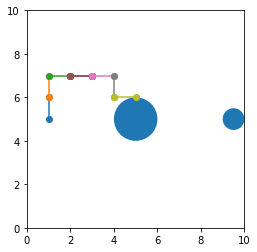

episode 188, the reward is 100


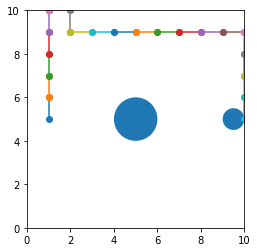

episode 189, the reward is 100


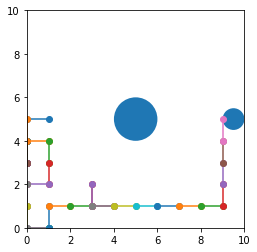

episode 190, the reward is -100


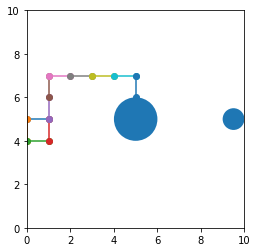

episode 191, the reward is 100


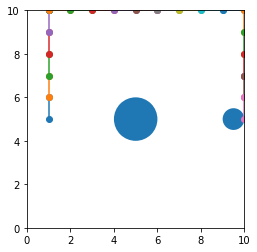

episode 192, the reward is 100


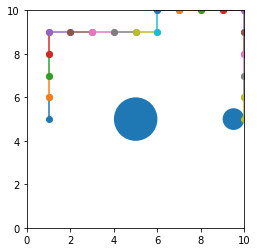

episode 193, the reward is 100


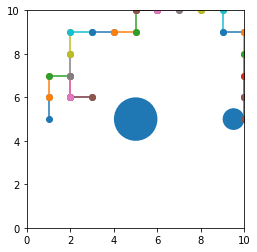

episode 194, the reward is 100


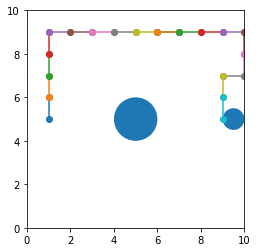

episode 195, the reward is 100


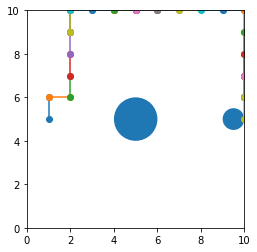

!
episode 196, the reward is 100


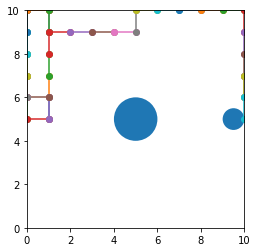

episode 197, the reward is 100


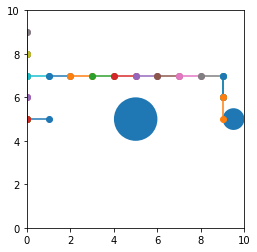

episode 198, the reward is 100


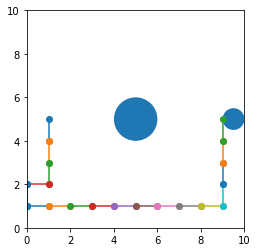

episode 199, the reward is 100


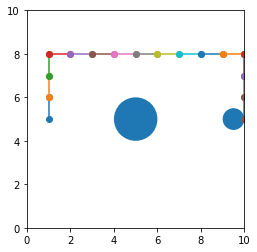

episode 200, the reward is 100


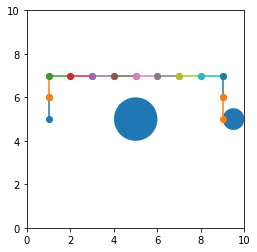

episode 201, the reward is 100


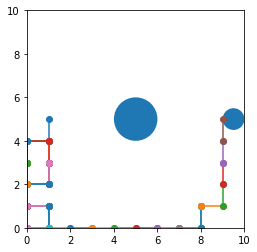

episode 202, the reward is 100


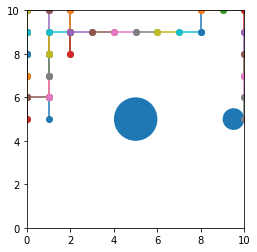

episode 203, the reward is 100


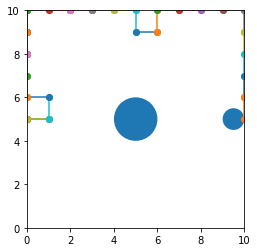

episode 204, the reward is 100


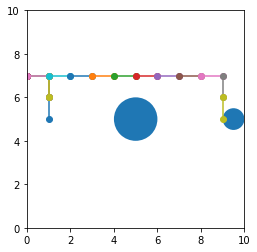

episode 205, the reward is 100


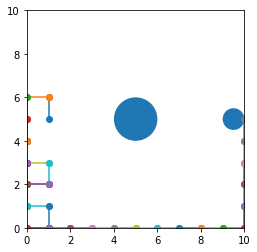

episode 206, the reward is 100


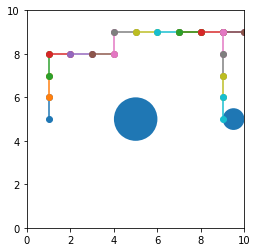

episode 207, the reward is 100


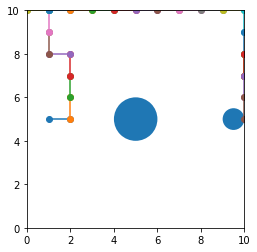

!
episode 208, the reward is 100


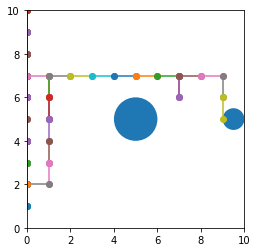

episode 209, the reward is 100


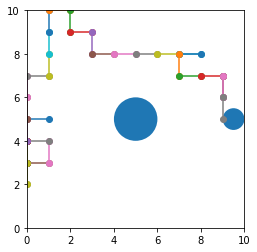

episode 210, the reward is -100


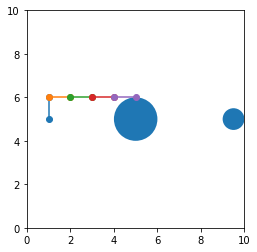

episode 211, the reward is 100


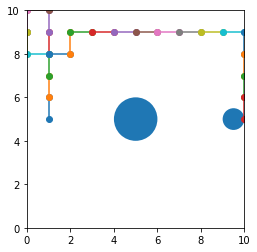

episode 212, the reward is 100


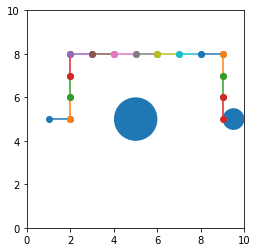

episode 213, the reward is -100


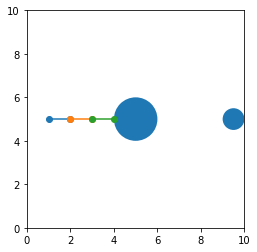

episode 214, the reward is 100


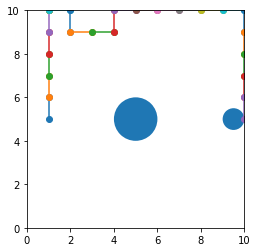

episode 215, the reward is 100


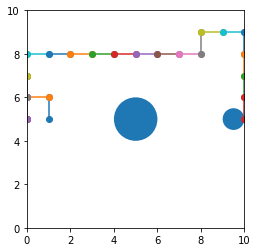

episode 216, the reward is -100


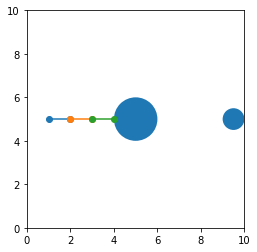

episode 217, the reward is -100


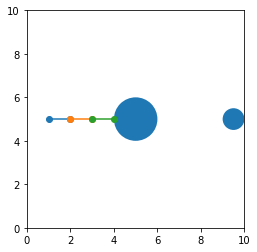

episode 218, the reward is 100


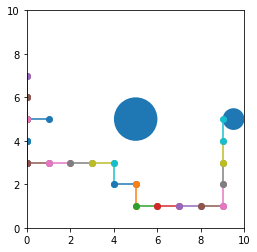

episode 219, the reward is 100


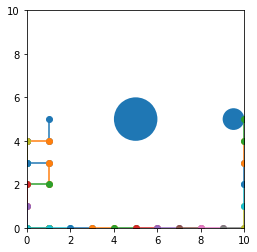

episode 220, the reward is -100


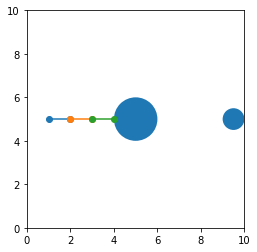

episode 221, the reward is 100


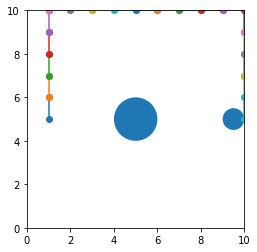

episode 222, the reward is 100


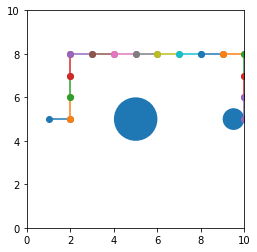

episode 223, the reward is 100


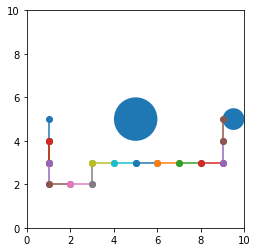

episode 224, the reward is 100


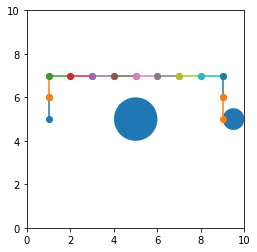

episode 225, the reward is 100


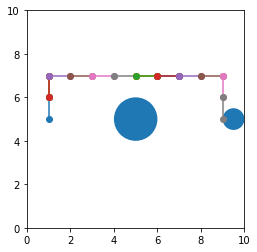

episode 226, the reward is 100


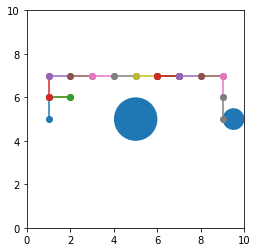

episode 227, the reward is -100


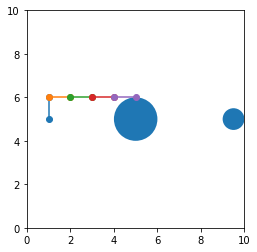

!
episode 228, the reward is 100


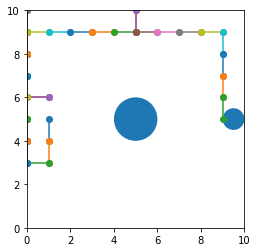

episode 229, the reward is 100


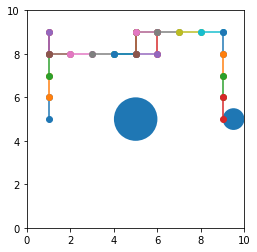

episode 230, the reward is 100


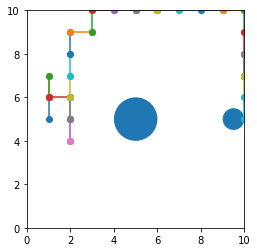

episode 231, the reward is 100


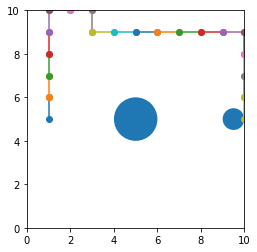

episode 232, the reward is -100


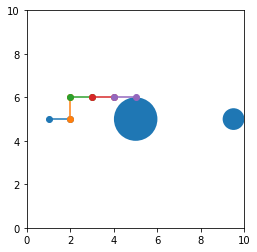

episode 233, the reward is 100


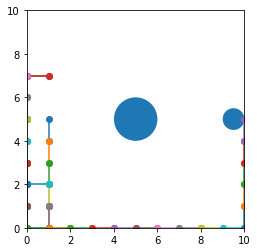

episode 234, the reward is 100


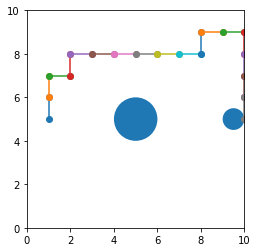

episode 235, the reward is 100


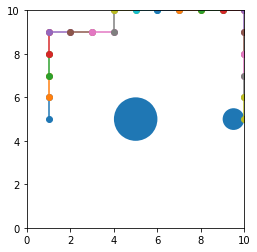

episode 236, the reward is 100


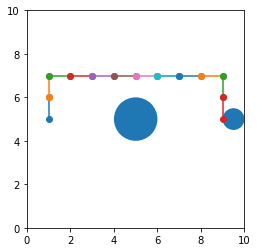

episode 237, the reward is 100


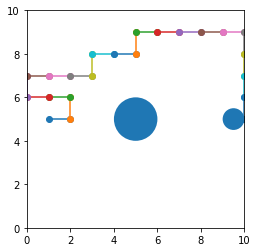

episode 238, the reward is 100


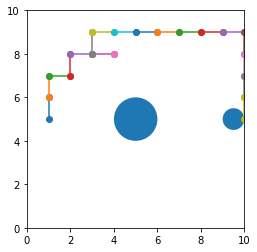

episode 239, the reward is 100


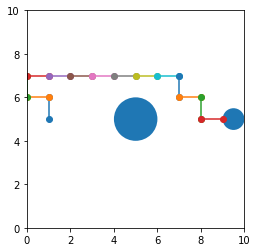

episode 240, the reward is 100


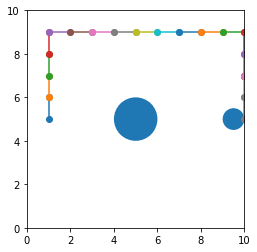

episode 241, the reward is -100


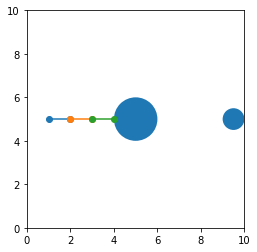

episode 242, the reward is 100


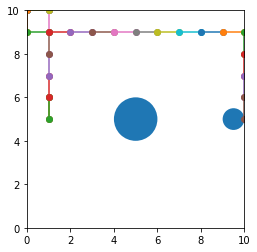

episode 243, the reward is 100


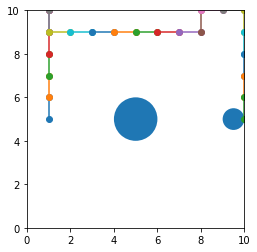

episode 244, the reward is 100


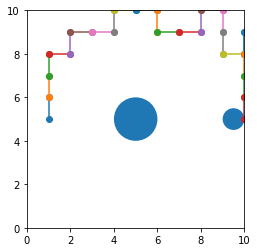

!
episode 245, the reward is 100


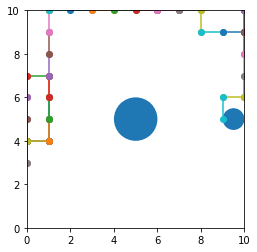

episode 246, the reward is 100


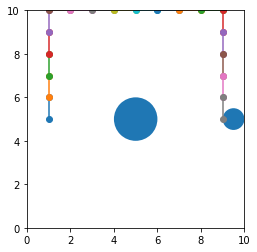

episode 247, the reward is 100


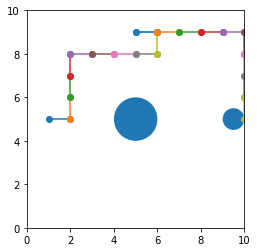

episode 248, the reward is 100


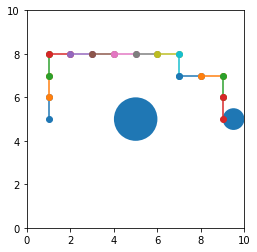

episode 249, the reward is -100


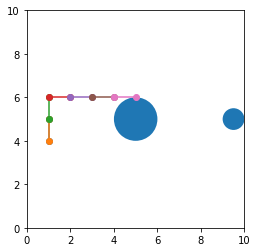

episode 250, the reward is -100


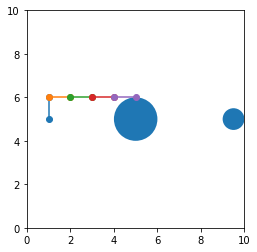

episode 251, the reward is 100


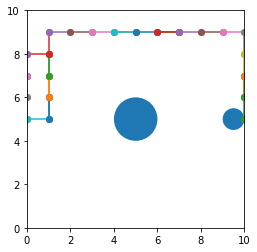

episode 252, the reward is 100


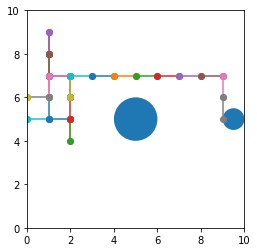

episode 253, the reward is -100


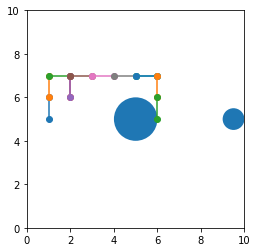

episode 254, the reward is 100


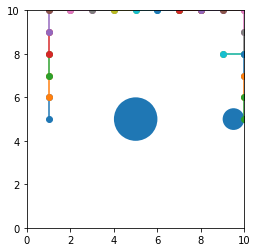

episode 255, the reward is 100


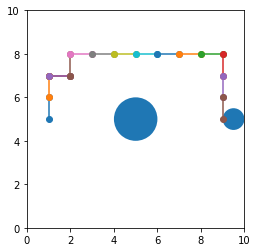

episode 256, the reward is 100


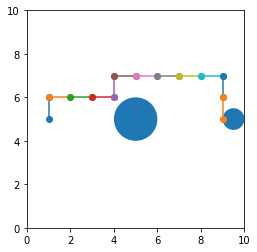

episode 257, the reward is 100


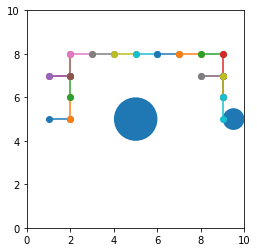

episode 258, the reward is 100


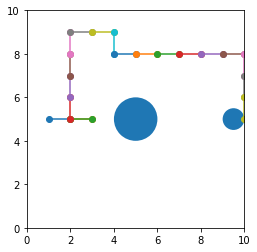

episode 259, the reward is 100


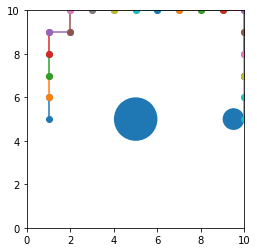

episode 260, the reward is 100


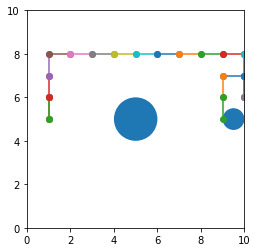

episode 261, the reward is 100


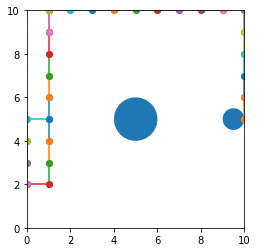

episode 262, the reward is 100


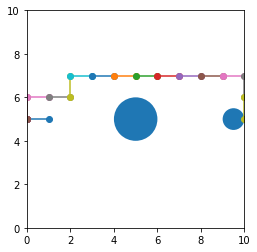

episode 263, the reward is 100


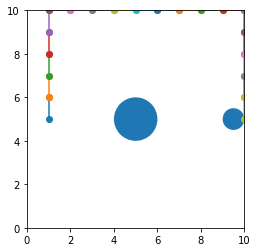

episode 264, the reward is 100


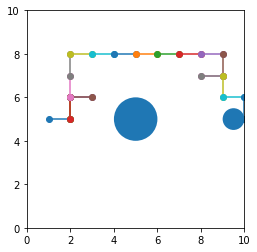

episode 265, the reward is 100


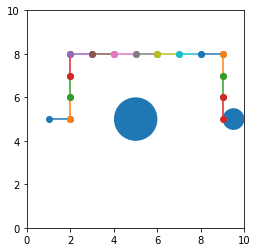

episode 266, the reward is -100


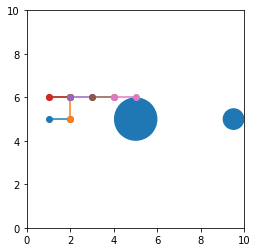

episode 267, the reward is -100


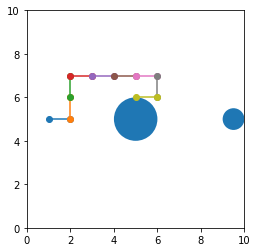

episode 268, the reward is 100


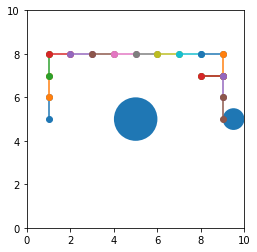

episode 269, the reward is -100


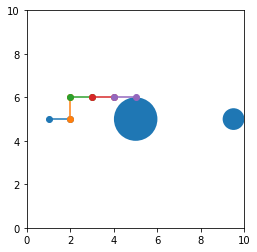

episode 270, the reward is 100


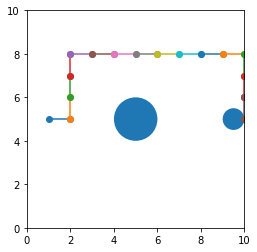

episode 271, the reward is 100


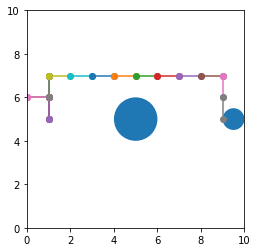

episode 272, the reward is 100


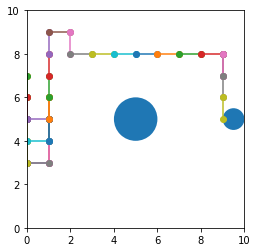

!
episode 273, the reward is 100


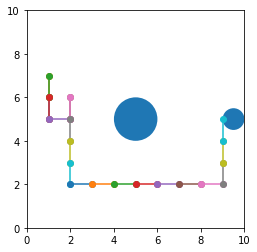

episode 274, the reward is 100


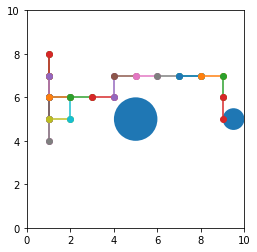

episode 275, the reward is -100


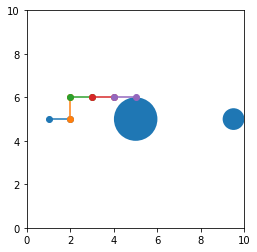

episode 276, the reward is 100


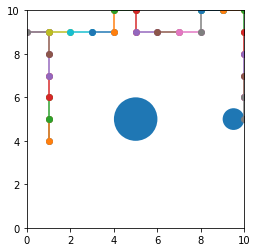

episode 277, the reward is 100


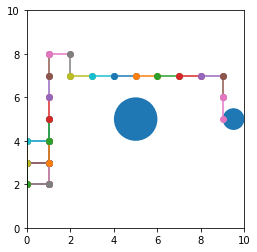

episode 278, the reward is -100


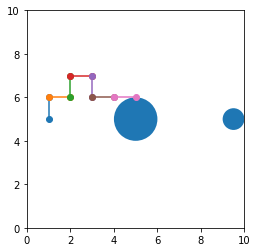

episode 279, the reward is 100


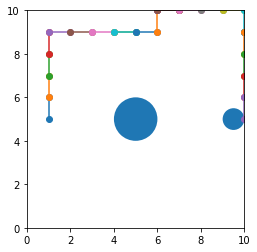

episode 280, the reward is -100


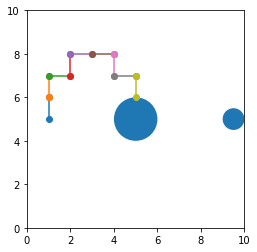

episode 281, the reward is 100


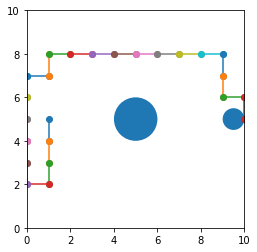

episode 282, the reward is 100


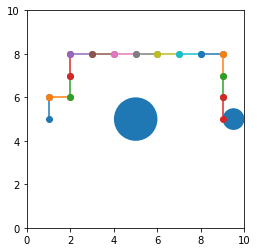

episode 283, the reward is 100


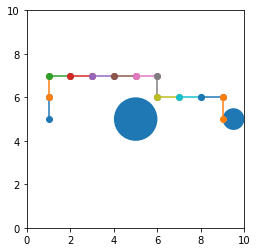

episode 284, the reward is 100


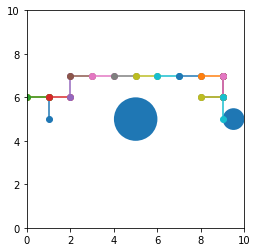

episode 285, the reward is 100


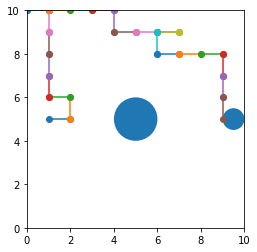

episode 286, the reward is 100


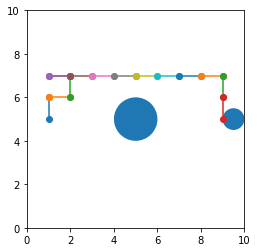

episode 287, the reward is -100


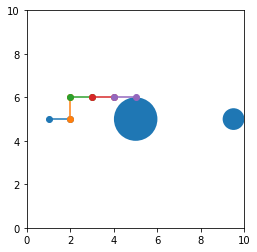

episode 288, the reward is 100


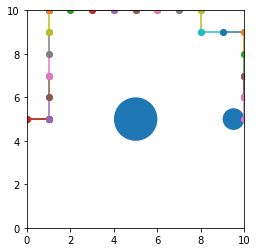

episode 289, the reward is 100


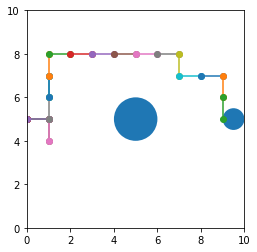

episode 290, the reward is 100


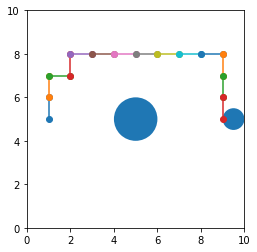

episode 291, the reward is -100


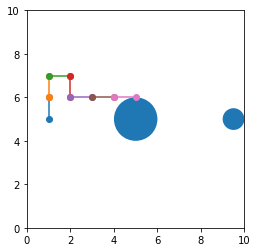

episode 292, the reward is 100


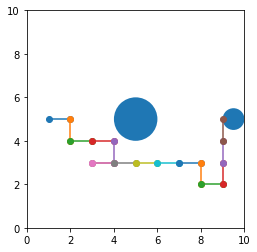

episode 293, the reward is 100


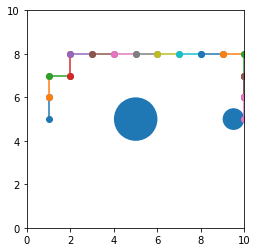

episode 294, the reward is 100


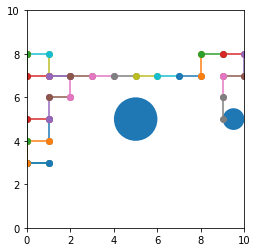

episode 295, the reward is 100


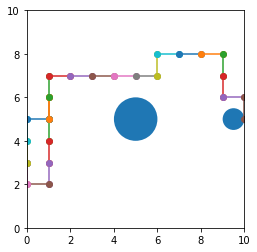

episode 296, the reward is 100


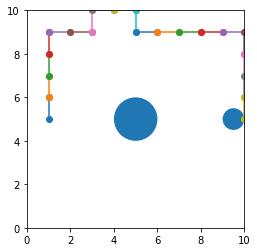

!
episode 297, the reward is 100


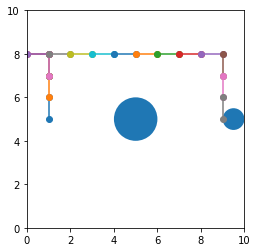

episode 298, the reward is -100


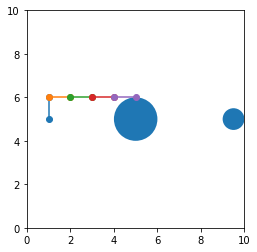

episode 299, the reward is 100


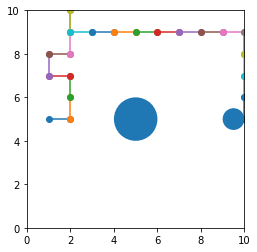

episode 300, the reward is 100


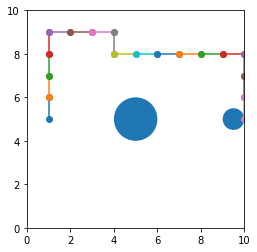

episode 301, the reward is 100


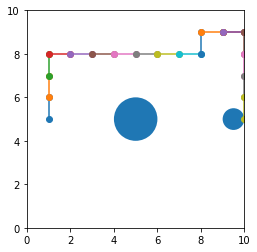

episode 302, the reward is 100


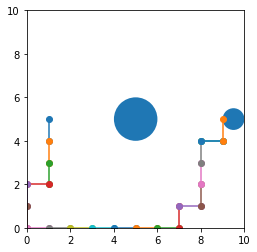

episode 303, the reward is 100


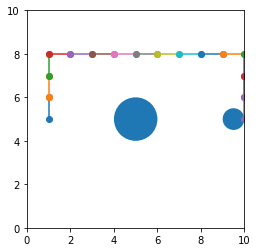

episode 304, the reward is 100


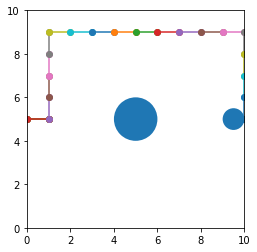

episode 305, the reward is 100


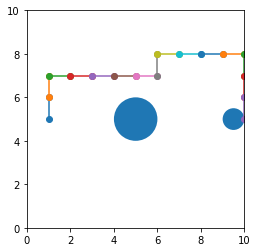

episode 306, the reward is 100


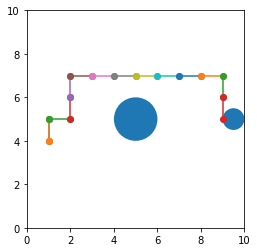

episode 307, the reward is 100


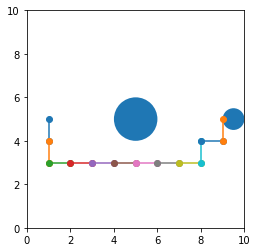

episode 308, the reward is 100


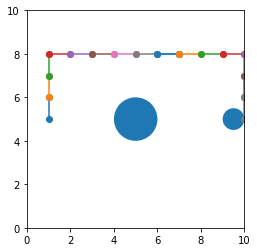

episode 309, the reward is 100


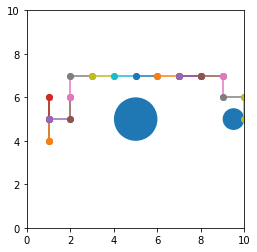

episode 310, the reward is 100


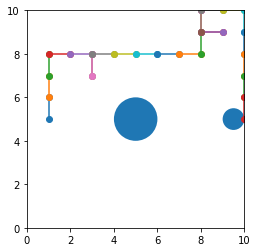

episode 311, the reward is 100


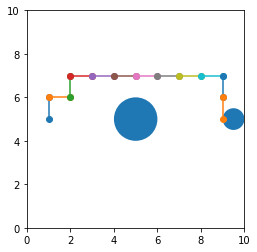

episode 312, the reward is -100


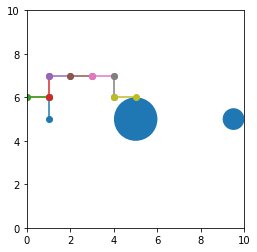

episode 313, the reward is 100


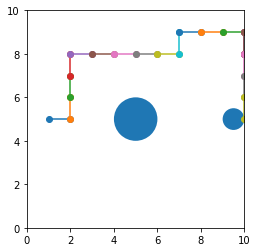

episode 314, the reward is 100


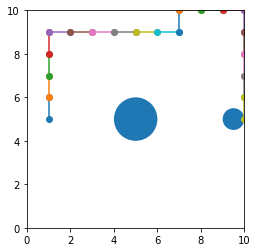

episode 315, the reward is 100


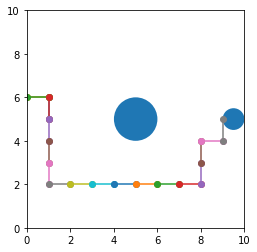

episode 316, the reward is 100


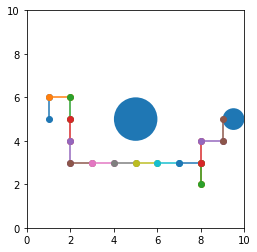

episode 317, the reward is 100


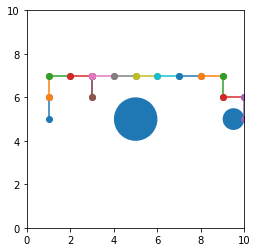

episode 318, the reward is -100


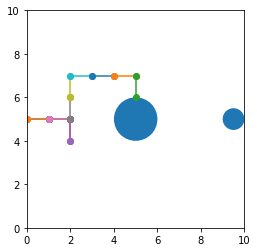

episode 319, the reward is 100


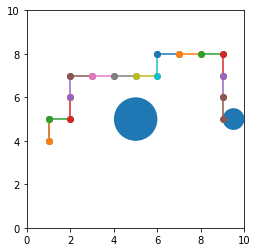

episode 320, the reward is 100


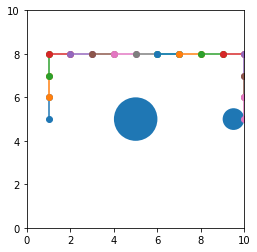

episode 321, the reward is 100


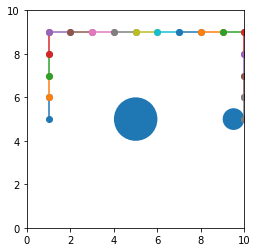

episode 322, the reward is 100


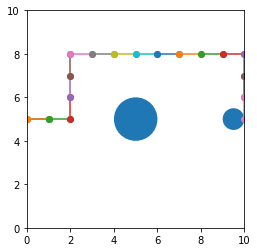

episode 323, the reward is 100


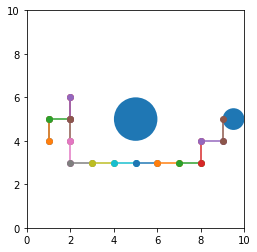

episode 324, the reward is 100


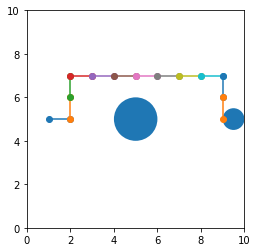

episode 325, the reward is 100


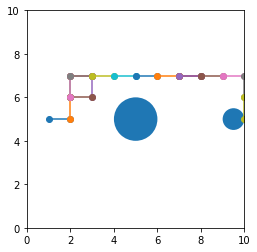

episode 326, the reward is -100


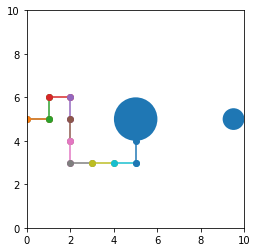

episode 327, the reward is 100


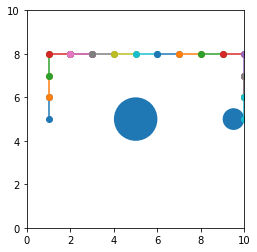

!
episode 328, the reward is 100


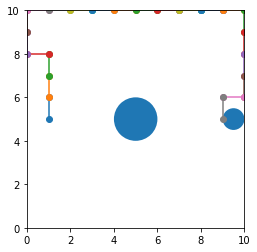

episode 329, the reward is 100


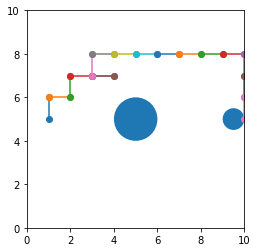

episode 330, the reward is 100


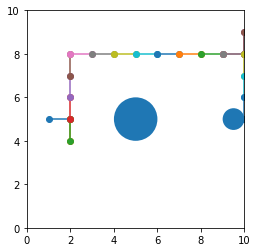

episode 331, the reward is 100


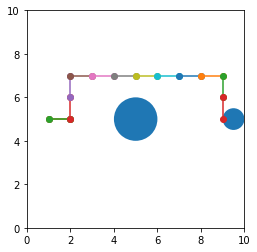

episode 332, the reward is 100


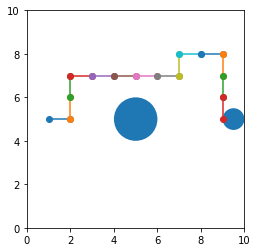

episode 333, the reward is 100


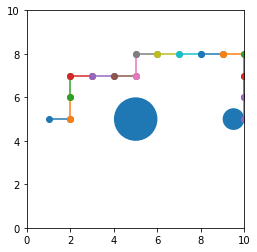

episode 334, the reward is 100


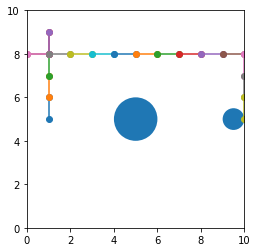

episode 335, the reward is 100


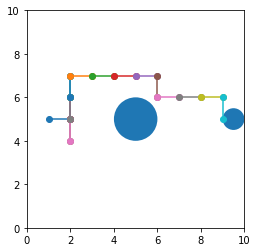

episode 336, the reward is -100


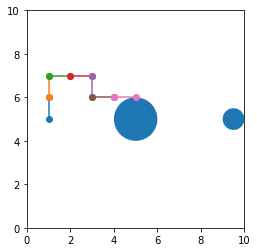

episode 337, the reward is 100


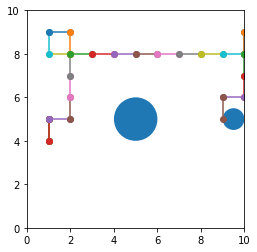

episode 338, the reward is 100


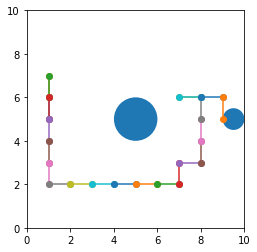

episode 339, the reward is 100


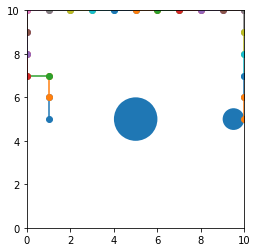

episode 340, the reward is -100


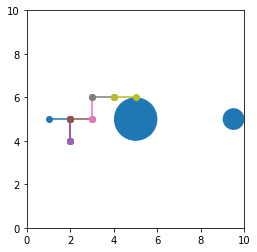

episode 341, the reward is 100


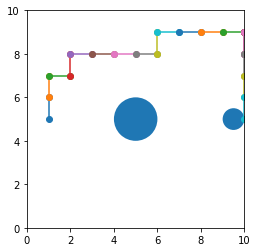

episode 342, the reward is 100


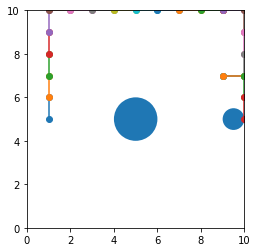

episode 343, the reward is 100


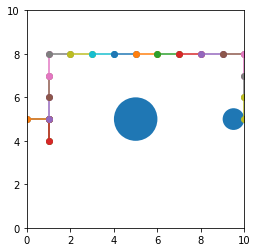

episode 344, the reward is 100


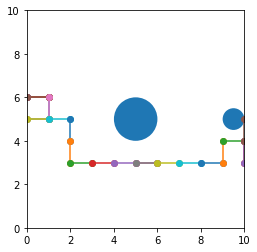

episode 345, the reward is 100


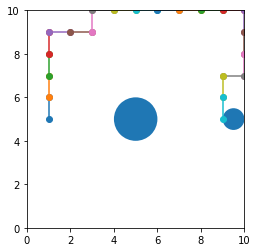

episode 346, the reward is 100


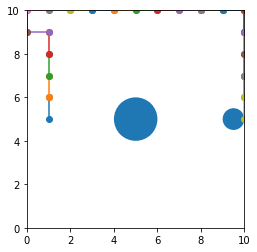

episode 347, the reward is 100


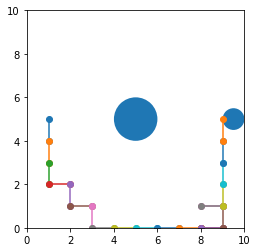

episode 348, the reward is 100


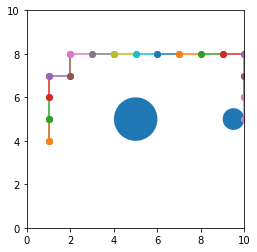

episode 349, the reward is 100


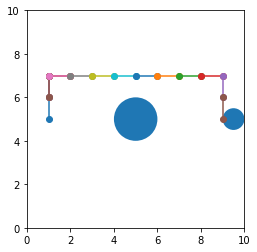

episode 350, the reward is 100


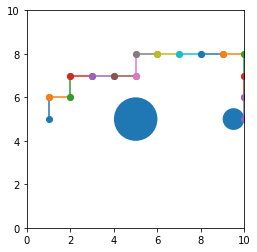

episode 351, the reward is 100


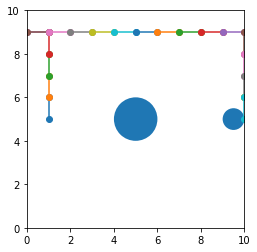

episode 352, the reward is 100


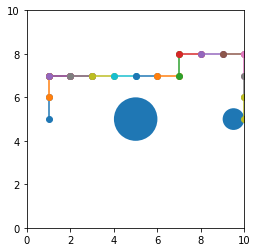

episode 353, the reward is 100


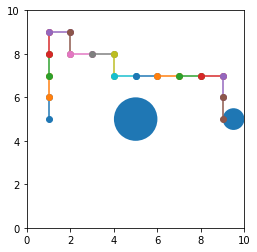

!
episode 354, the reward is 100


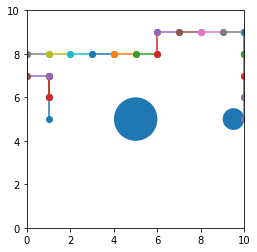

episode 355, the reward is -100


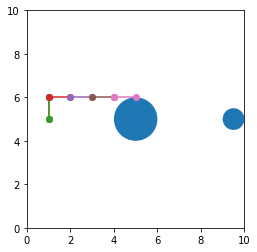

episode 356, the reward is -100


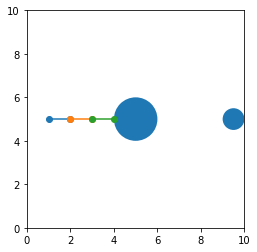

episode 357, the reward is 100


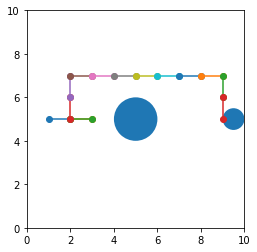

episode 358, the reward is 100


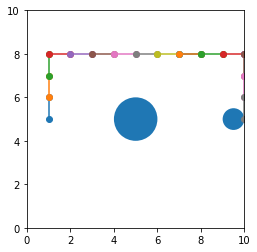

episode 359, the reward is 100


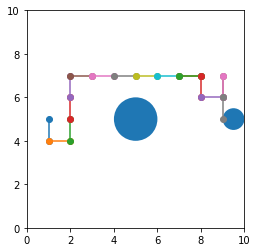

episode 360, the reward is 100


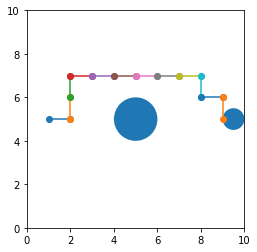

episode 361, the reward is 100


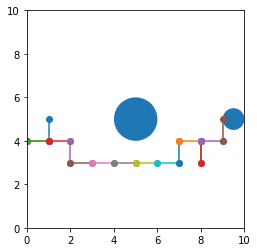

episode 362, the reward is 100


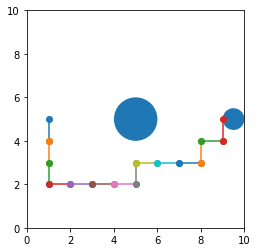

episode 363, the reward is 100


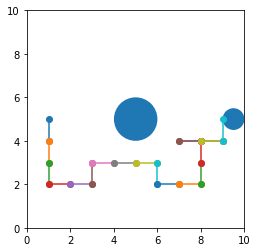

episode 364, the reward is 100


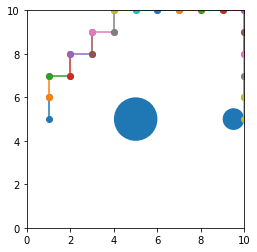

episode 365, the reward is 100


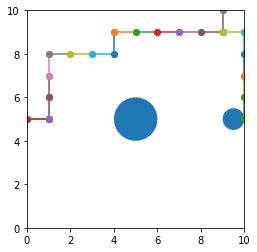

episode 366, the reward is 100


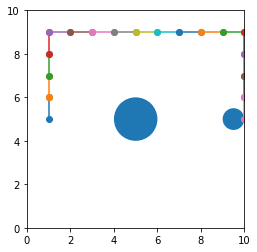

episode 367, the reward is 100


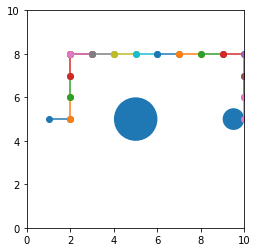

episode 368, the reward is 100


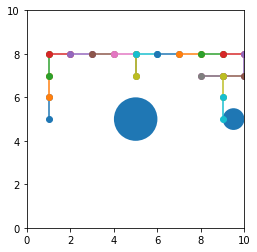

episode 369, the reward is 100


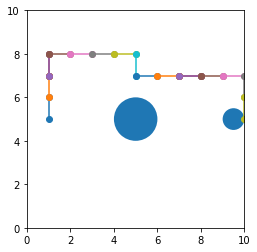

episode 370, the reward is 100


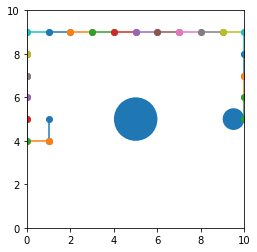

episode 371, the reward is 100


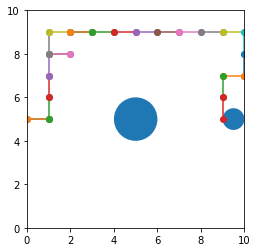

episode 372, the reward is -100


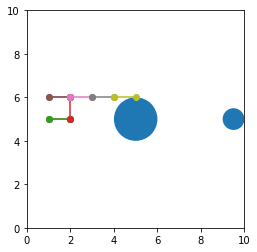

episode 373, the reward is -100


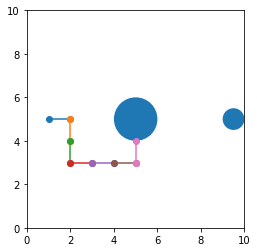

episode 374, the reward is 100


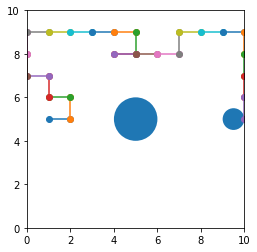

episode 375, the reward is 100


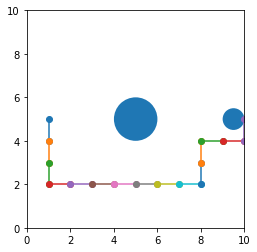

episode 376, the reward is 100


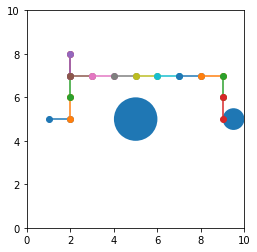

episode 377, the reward is 100


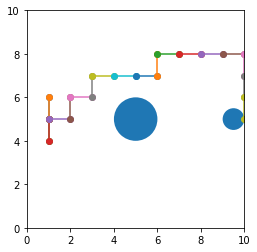

episode 378, the reward is 100


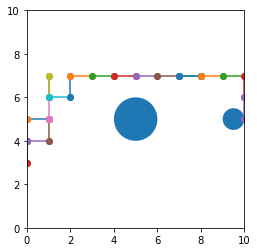

episode 379, the reward is 100


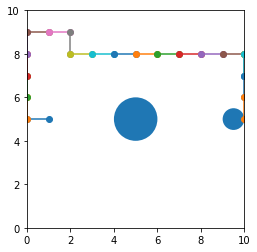

episode 380, the reward is 100


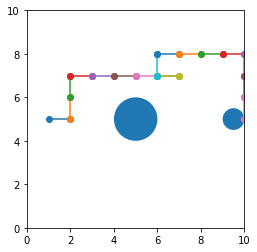

episode 381, the reward is 100


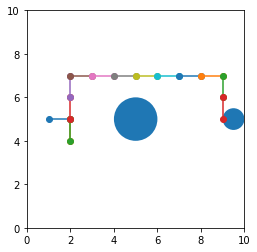

episode 382, the reward is 100


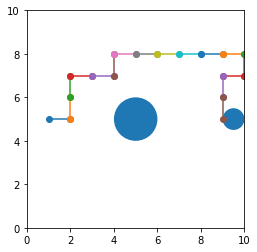

episode 383, the reward is 100


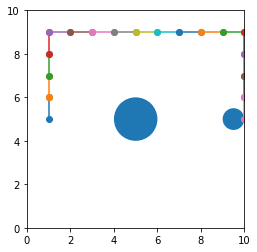

!
episode 384, the reward is 100


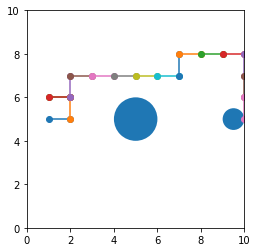

episode 385, the reward is -100


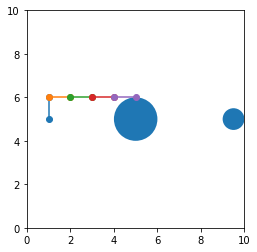

episode 386, the reward is 100


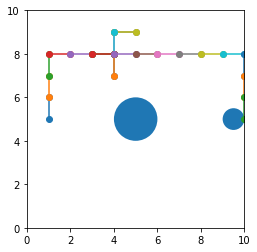

episode 387, the reward is 100


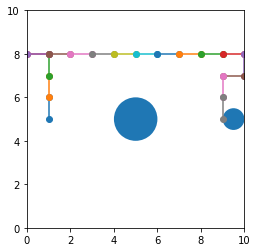

episode 388, the reward is 100


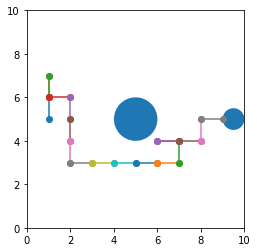

episode 389, the reward is -100


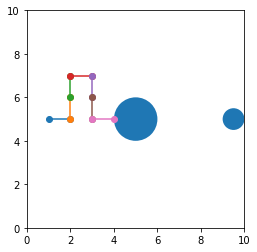

episode 390, the reward is -100


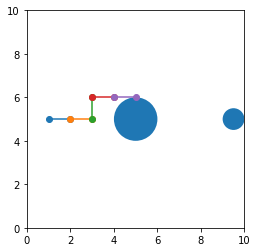

episode 391, the reward is 100


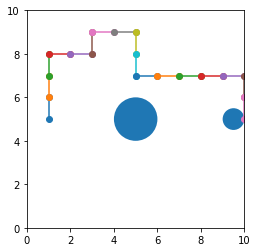

episode 392, the reward is 100


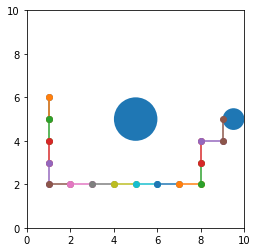

episode 393, the reward is 100


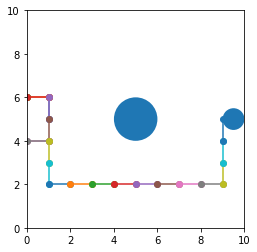

episode 394, the reward is 100


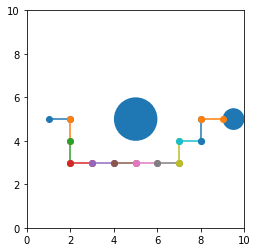

episode 395, the reward is 100


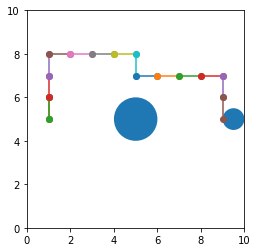

episode 396, the reward is 100


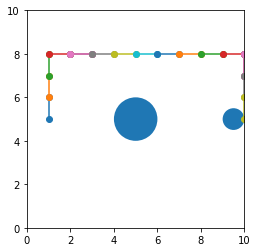

episode 397, the reward is 100


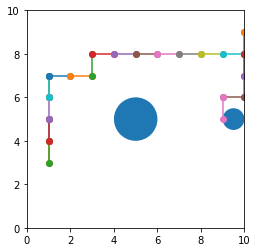

episode 398, the reward is 100


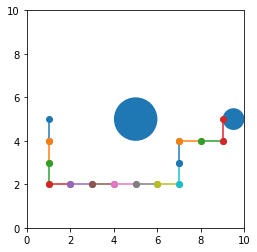

episode 399, the reward is 100


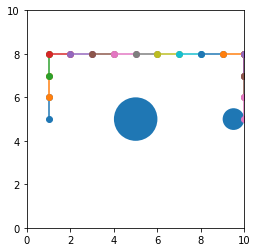

episode 400, the reward is 100


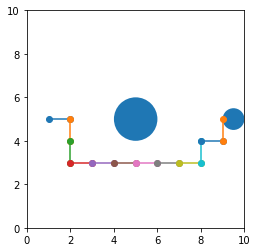

episode 401, the reward is 100


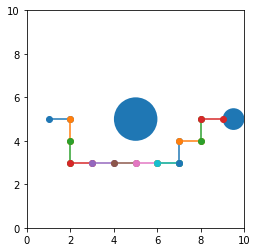

episode 402, the reward is 100


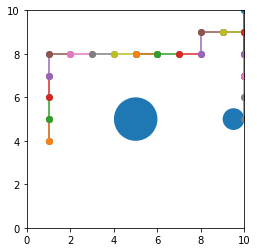

episode 403, the reward is 100


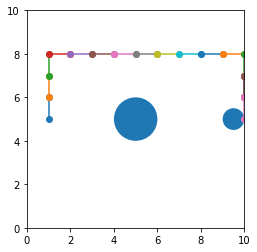

episode 404, the reward is -100


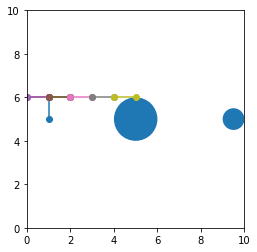

episode 405, the reward is -100


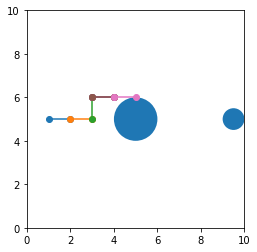

episode 406, the reward is 100


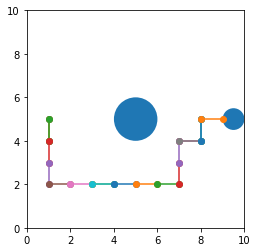

episode 407, the reward is 100


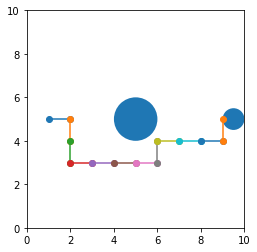

episode 408, the reward is 100


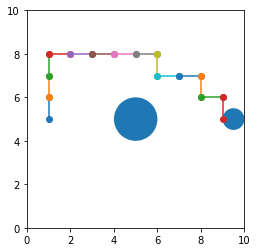

episode 409, the reward is 100


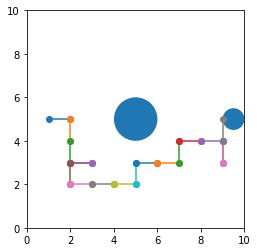

episode 410, the reward is 100


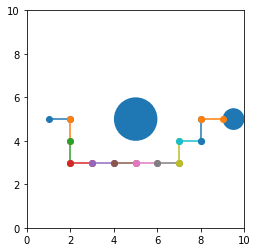

episode 411, the reward is -100


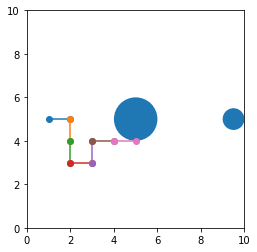

episode 412, the reward is 100


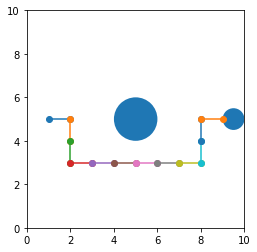

episode 413, the reward is 100


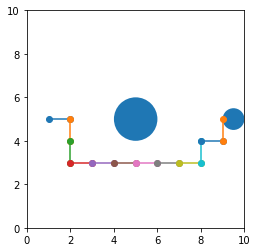

episode 414, the reward is 100


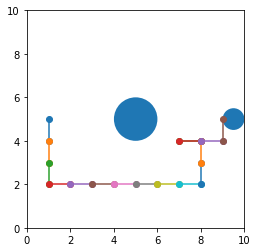

episode 415, the reward is 100


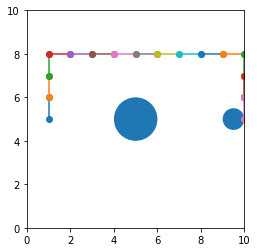

episode 416, the reward is 100


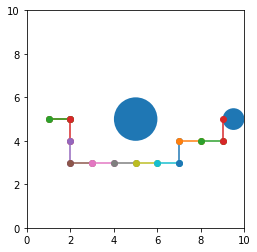

episode 417, the reward is -100


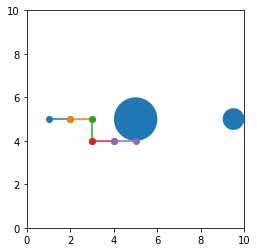

!
episode 418, the reward is -100


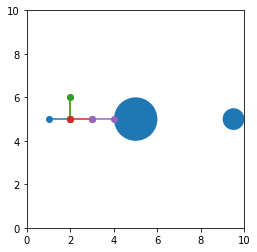

episode 419, the reward is -100


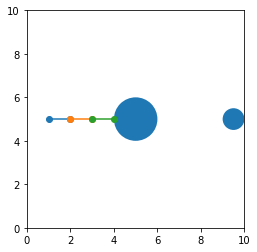

episode 420, the reward is -100


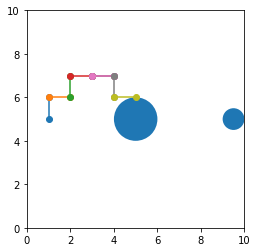

episode 421, the reward is -100


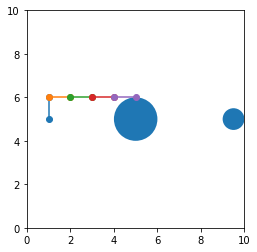

episode 422, the reward is -100


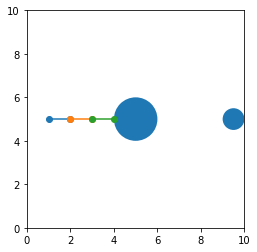

episode 423, the reward is -100


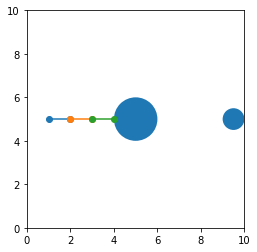

episode 424, the reward is 100


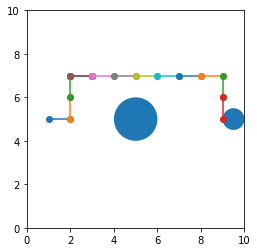

episode 425, the reward is -100


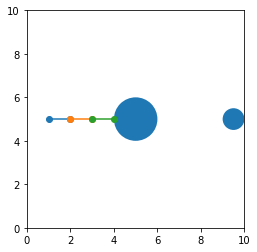

episode 426, the reward is -100


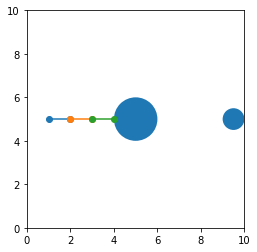

episode 427, the reward is -100


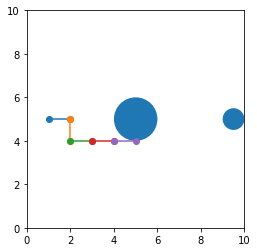

episode 428, the reward is -100


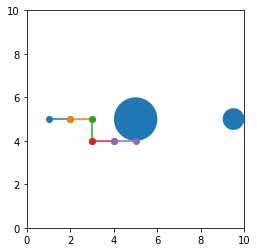

episode 429, the reward is -100


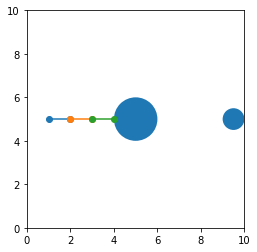

episode 430, the reward is 100


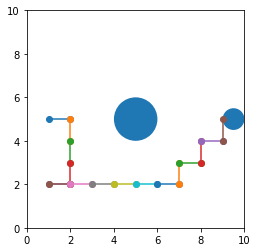

episode 431, the reward is 100


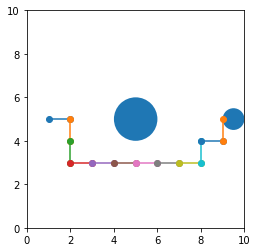

episode 432, the reward is 100


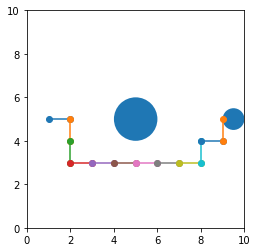

episode 433, the reward is 100


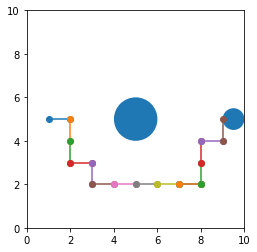

episode 434, the reward is -100


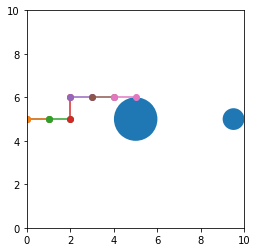

episode 435, the reward is 100


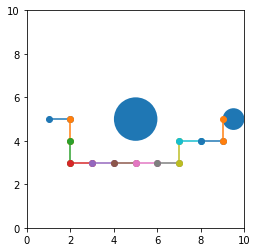

episode 436, the reward is 100


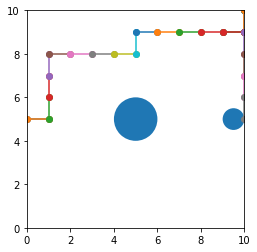

episode 437, the reward is -100


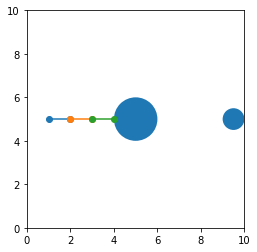

episode 438, the reward is -100


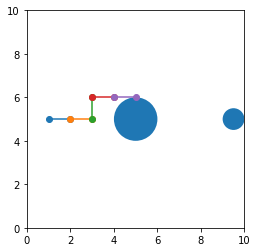

episode 439, the reward is 100


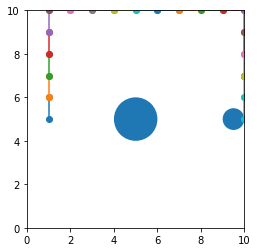

episode 440, the reward is 100


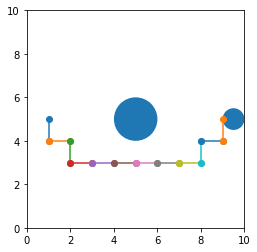

episode 441, the reward is 100


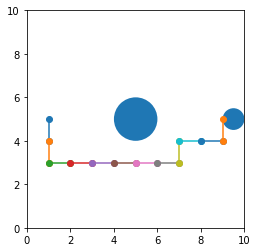

episode 442, the reward is -100


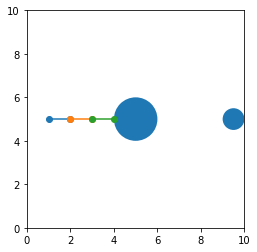

episode 443, the reward is -100


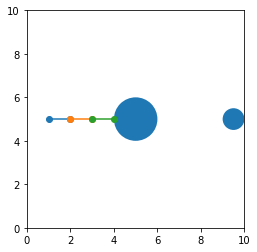

episode 444, the reward is 100


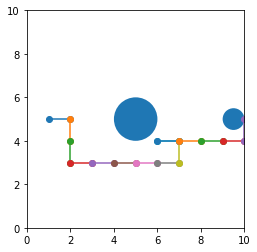

episode 445, the reward is 100


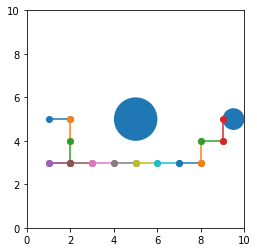

episode 446, the reward is 100


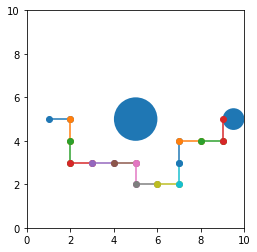

episode 447, the reward is 100


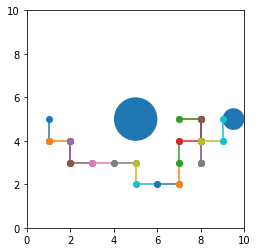

episode 448, the reward is 100


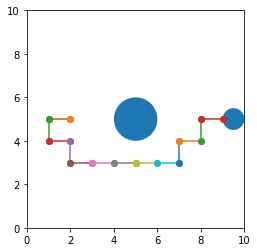

episode 449, the reward is 100


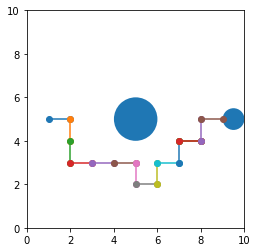

episode 450, the reward is 100


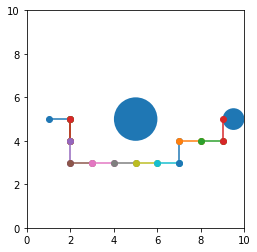

episode 451, the reward is 100


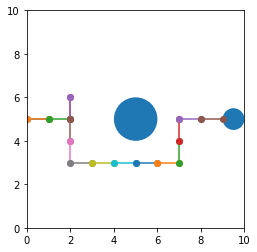

episode 452, the reward is 100


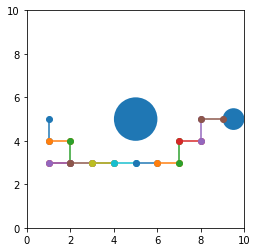

episode 453, the reward is 100


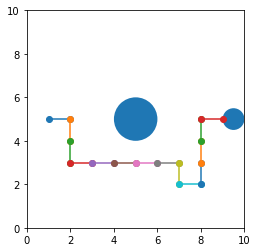

episode 454, the reward is 100


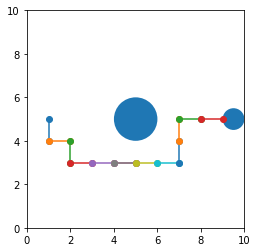

episode 455, the reward is -100


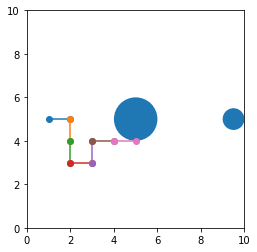

episode 456, the reward is 100


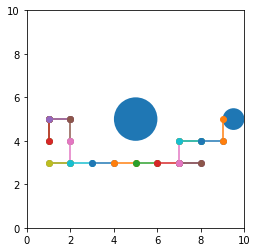

episode 457, the reward is 100


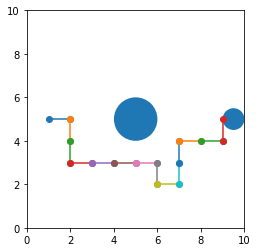

episode 458, the reward is 100


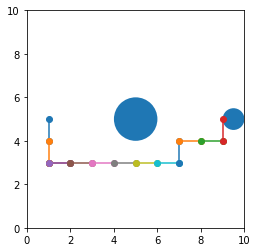

episode 459, the reward is -100


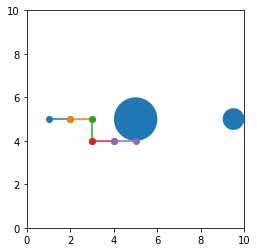

episode 460, the reward is 100


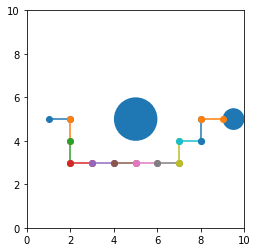

episode 461, the reward is 100


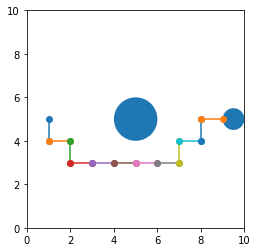

!
episode 462, the reward is 100


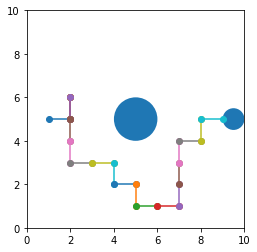

episode 463, the reward is 100


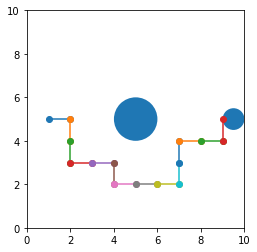

episode 464, the reward is 100


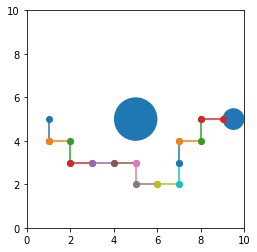

episode 465, the reward is 100


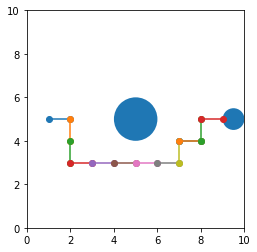

episode 466, the reward is 100


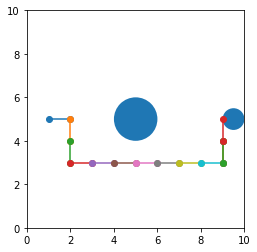

episode 467, the reward is 100


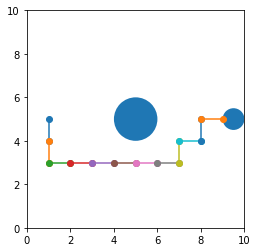

episode 468, the reward is 100


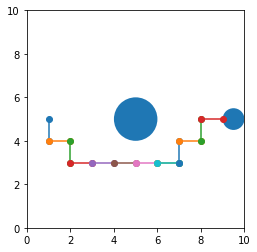

episode 469, the reward is 100


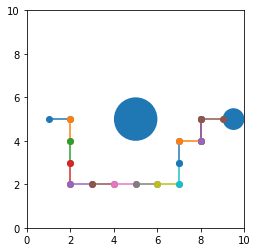

episode 470, the reward is 100


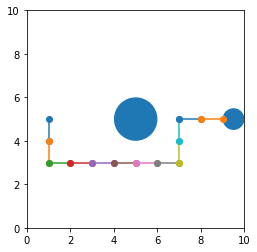

episode 471, the reward is 100


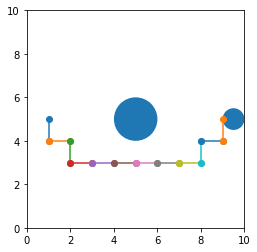

episode 472, the reward is 100


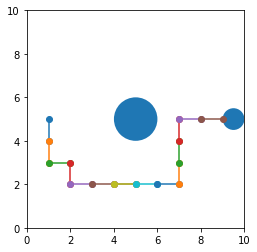

episode 473, the reward is 100


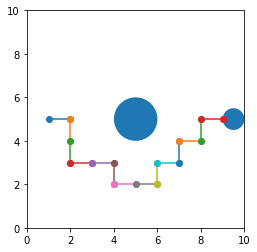

episode 474, the reward is 100


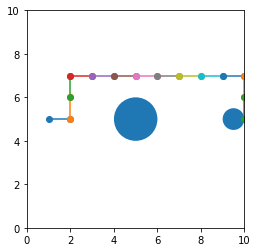

episode 475, the reward is 100


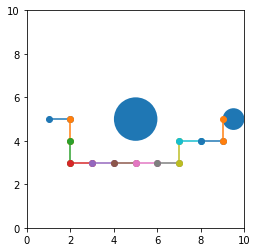

episode 476, the reward is 100


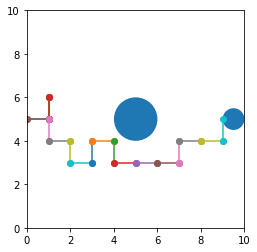

episode 477, the reward is 100


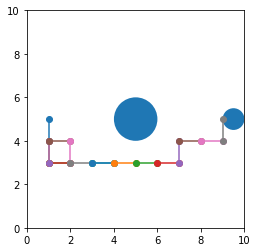

episode 478, the reward is 100


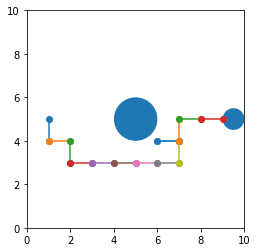

episode 479, the reward is 100


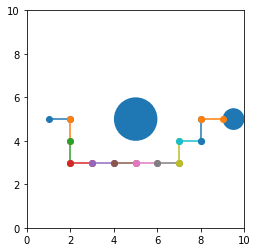

episode 480, the reward is -100


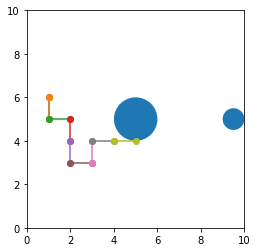

episode 481, the reward is 100


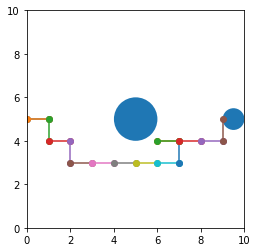

episode 482, the reward is 100


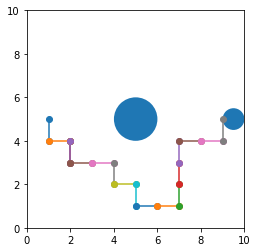

episode 483, the reward is 100


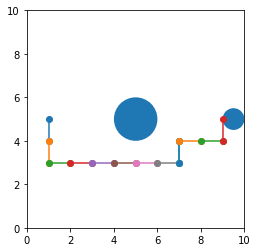

episode 484, the reward is 100


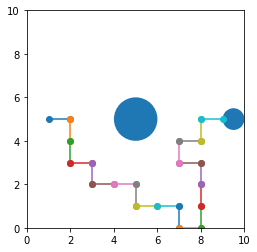

episode 485, the reward is 100


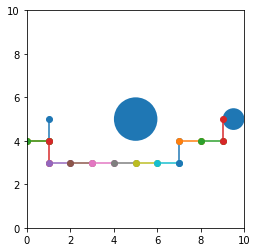

episode 486, the reward is 100


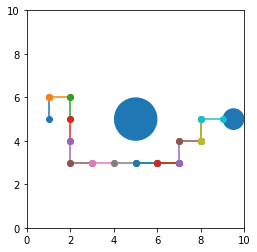

episode 487, the reward is -100


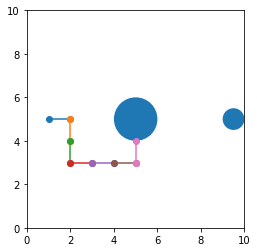

episode 488, the reward is 100


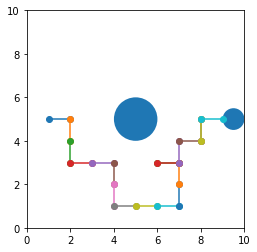

episode 489, the reward is 100


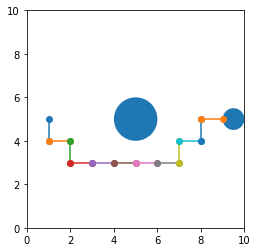

episode 490, the reward is 100


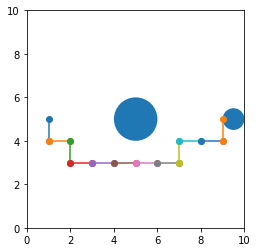

episode 491, the reward is 100


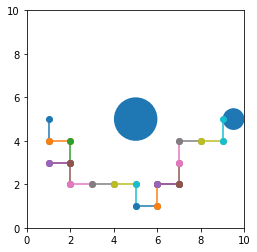

episode 492, the reward is 100


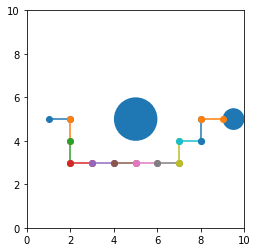

episode 493, the reward is 100


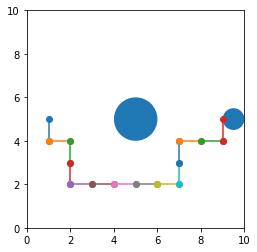

episode 494, the reward is 100


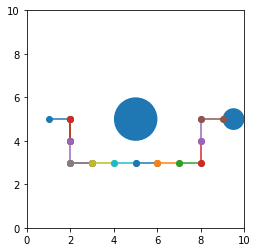

episode 495, the reward is 100


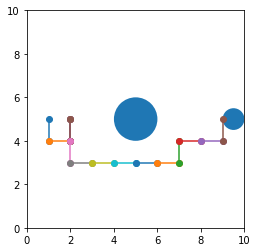

!
episode 496, the reward is 100


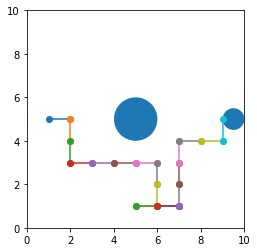

episode 497, the reward is 100


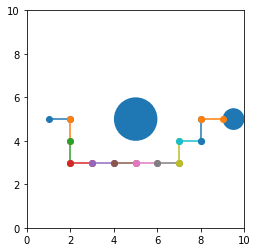

episode 498, the reward is -100


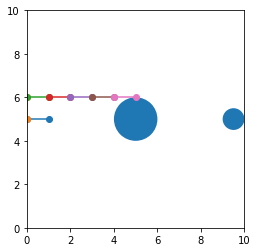

episode 499, the reward is -100


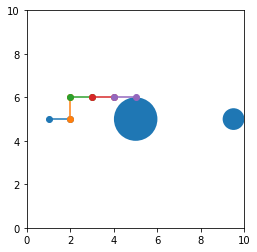

episode 500, the reward is 100


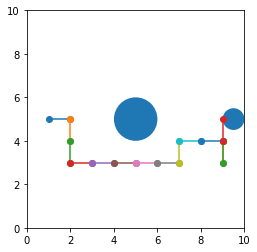

episode 501, the reward is 100


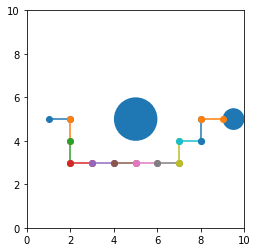

episode 502, the reward is -100


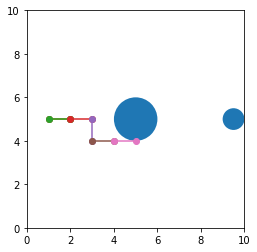

episode 503, the reward is -100


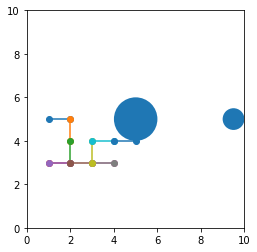

episode 504, the reward is -100


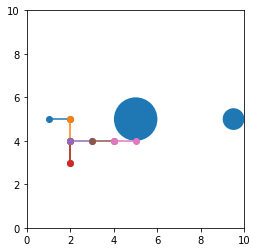

episode 505, the reward is 100


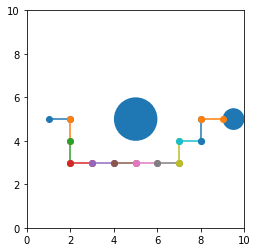

episode 506, the reward is -100


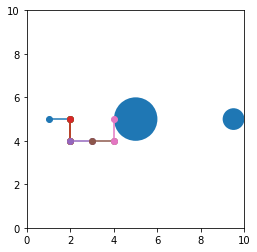

episode 507, the reward is -100


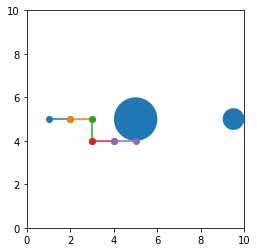

episode 508, the reward is 100


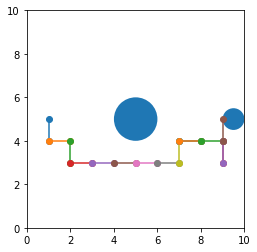

episode 509, the reward is 100


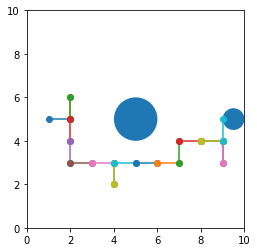

episode 510, the reward is 100


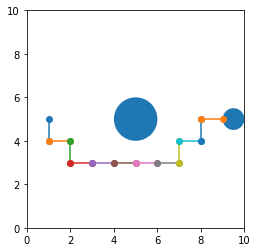

episode 511, the reward is 100


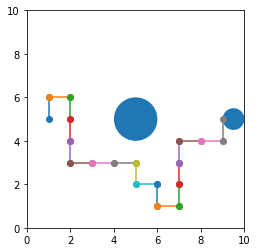

episode 512, the reward is 100


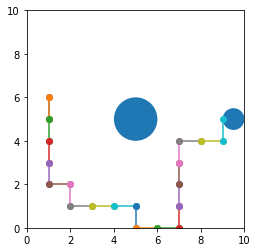

episode 513, the reward is 100


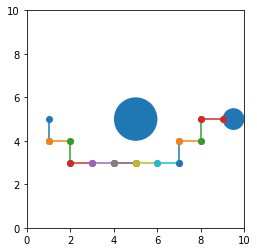

episode 514, the reward is -100


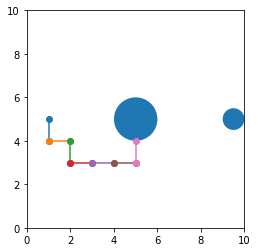

episode 515, the reward is 100


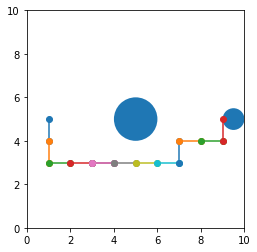

episode 516, the reward is 100


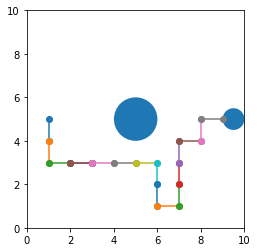

episode 517, the reward is 100


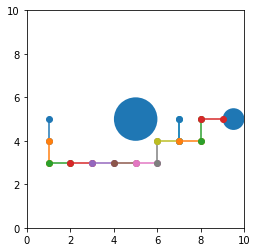

episode 518, the reward is 100


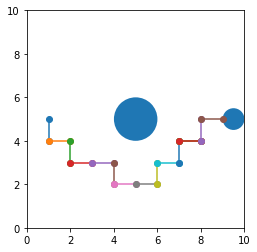

episode 519, the reward is -100


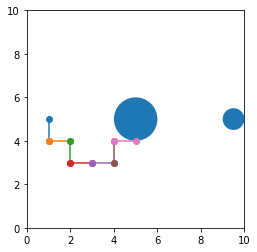

episode 520, the reward is 100


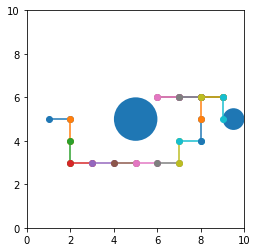

episode 521, the reward is 100


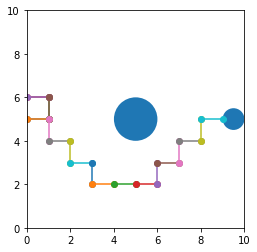

episode 522, the reward is 100


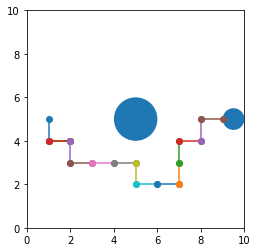

episode 523, the reward is -100


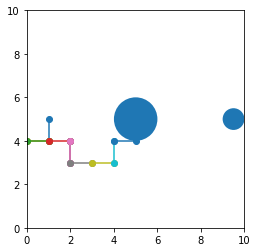

episode 524, the reward is 100


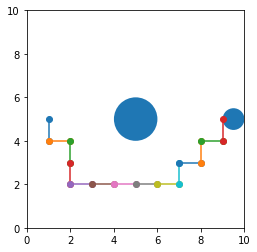

episode 525, the reward is 100


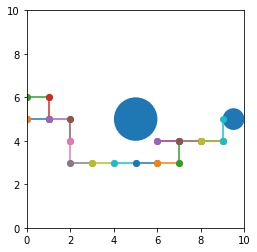

episode 526, the reward is -100


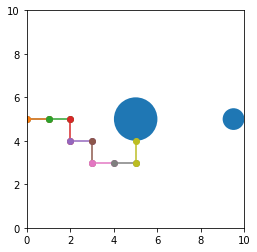

episode 527, the reward is 100


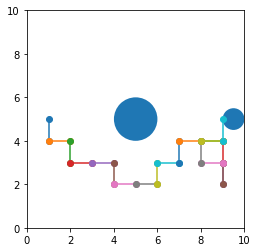

episode 528, the reward is 100


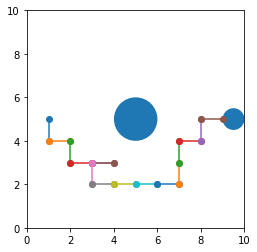

episode 529, the reward is -100


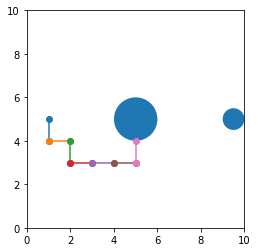

episode 530, the reward is 100


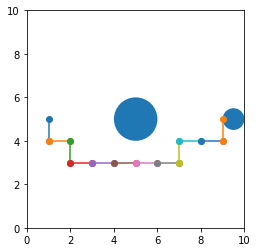

episode 531, the reward is -100


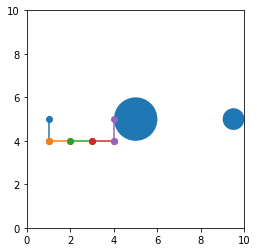

episode 532, the reward is 100


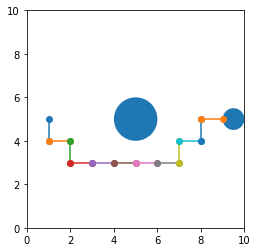

episode 533, the reward is -100


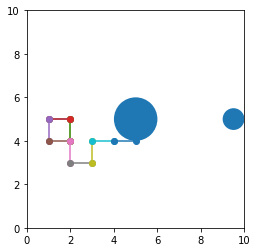

episode 534, the reward is 100


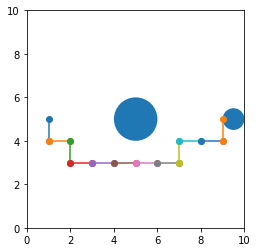

!
episode 535, the reward is 100


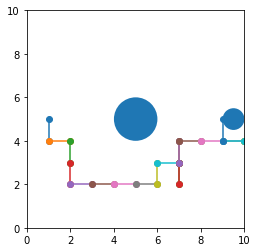

episode 536, the reward is -100


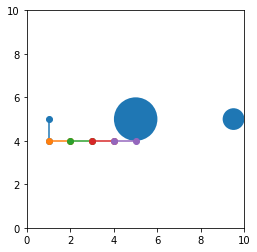

episode 537, the reward is 100


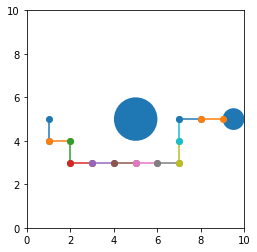

episode 538, the reward is 100


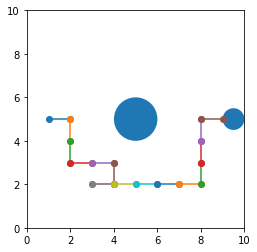

episode 539, the reward is 100


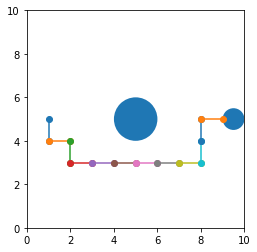

episode 540, the reward is 100


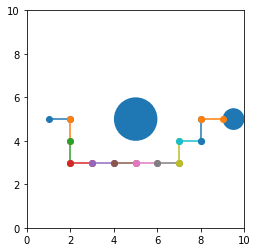

episode 541, the reward is 100


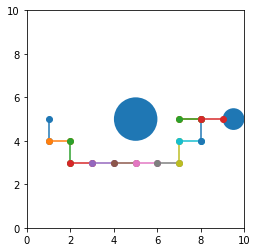

episode 542, the reward is 100


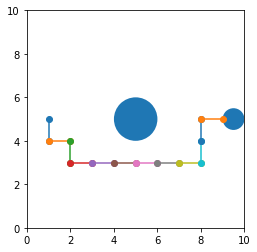

episode 543, the reward is 100


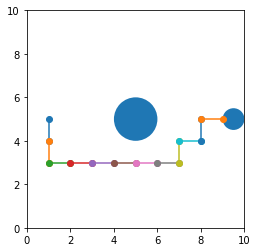

episode 544, the reward is 100


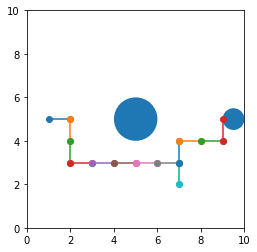

episode 545, the reward is -100


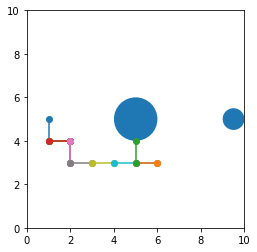

episode 546, the reward is 100


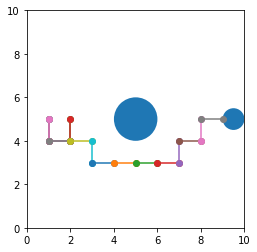

episode 547, the reward is 100


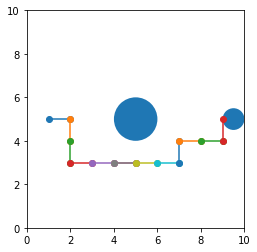

episode 548, the reward is 100


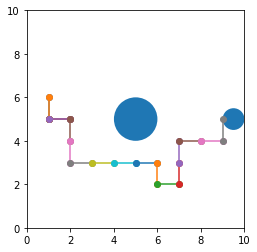

episode 549, the reward is -100


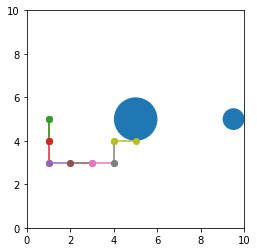

episode 550, the reward is 100


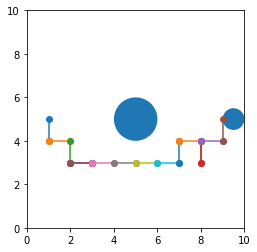

episode 551, the reward is 100


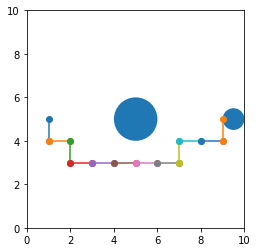

episode 552, the reward is 100


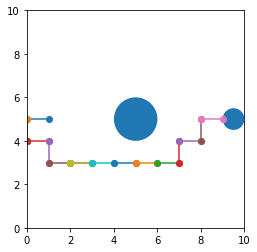

episode 553, the reward is 100


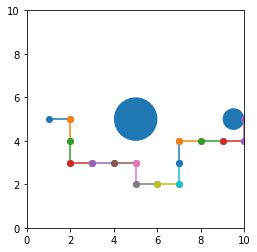

episode 554, the reward is 100


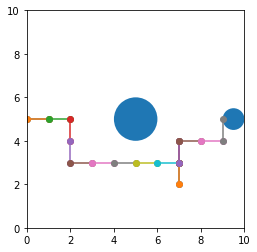

episode 555, the reward is 100


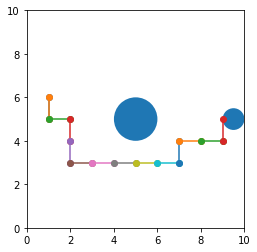

episode 556, the reward is 100


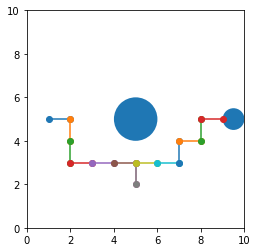

episode 557, the reward is 100


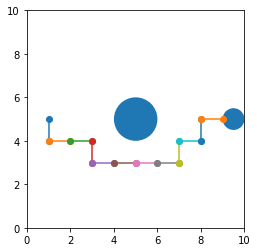

episode 558, the reward is -100


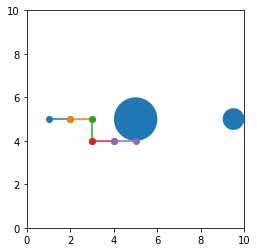

episode 559, the reward is 100


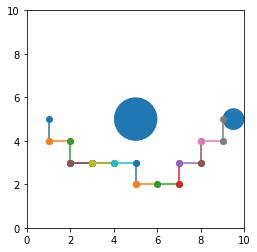

episode 560, the reward is -100


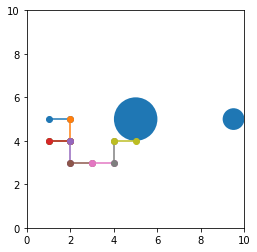

episode 561, the reward is 100


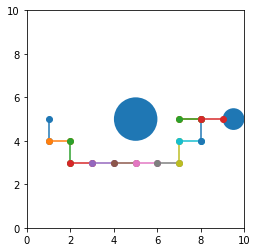

episode 562, the reward is 100


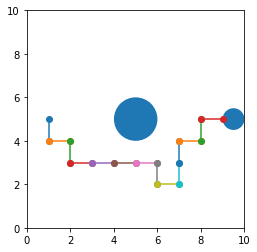

episode 563, the reward is -100


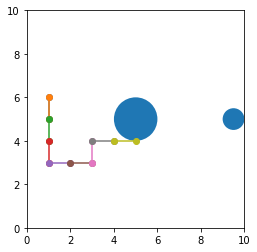

episode 564, the reward is 100


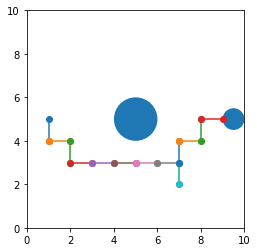

episode 565, the reward is 100


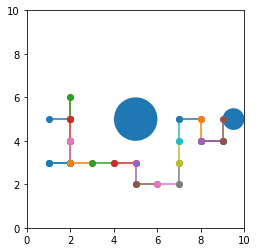

episode 566, the reward is 100


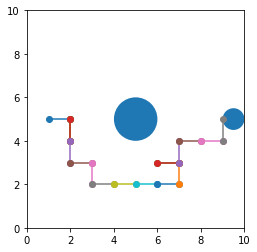

episode 567, the reward is -100


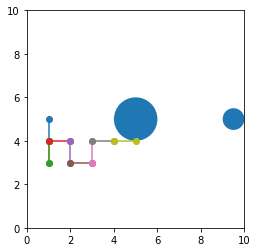

episode 568, the reward is 100


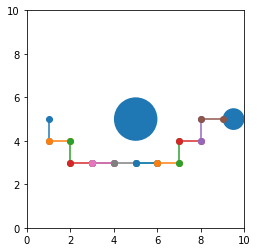

episode 569, the reward is 100


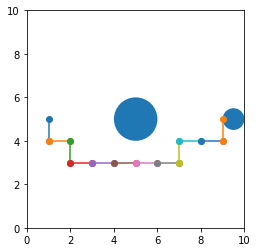

episode 570, the reward is 100


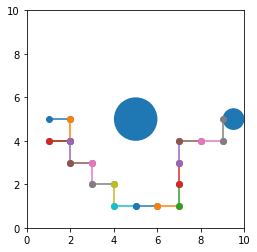

episode 571, the reward is 100


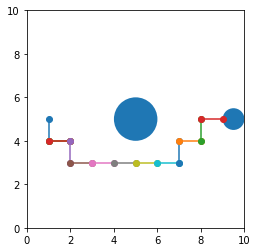

!
episode 572, the reward is 100


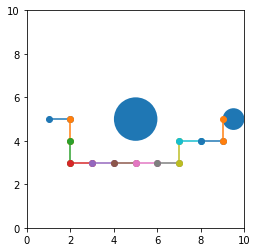

episode 573, the reward is 100


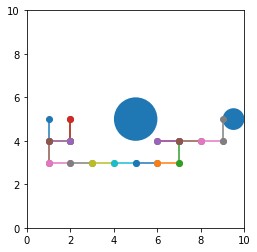

episode 574, the reward is 100


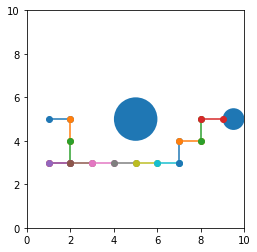

episode 575, the reward is 100


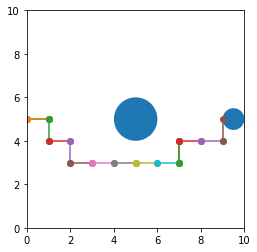

episode 576, the reward is 100


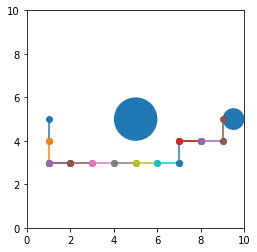

episode 577, the reward is -100


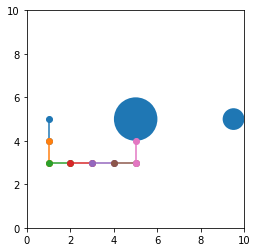

episode 578, the reward is 100


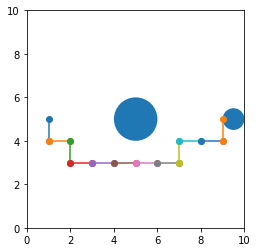

episode 579, the reward is -100


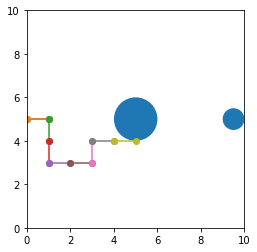

episode 580, the reward is -100


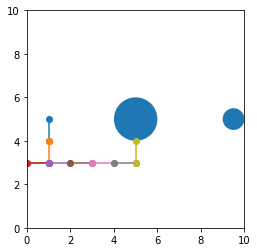

episode 581, the reward is 100


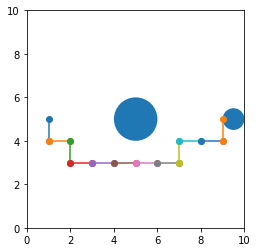

episode 582, the reward is 100


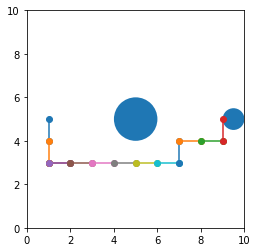

episode 583, the reward is 100


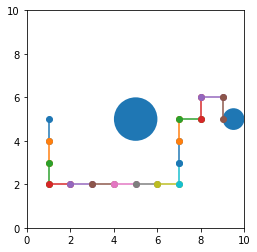

episode 584, the reward is 100


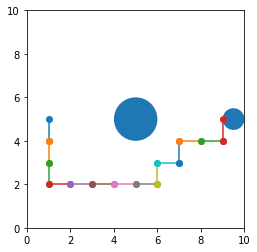

episode 585, the reward is 100


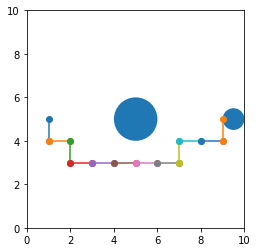

episode 586, the reward is 100


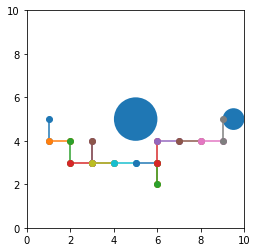

episode 587, the reward is 100


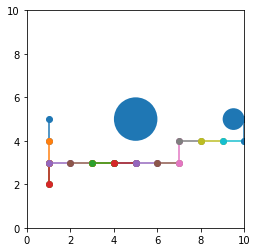

episode 588, the reward is 100


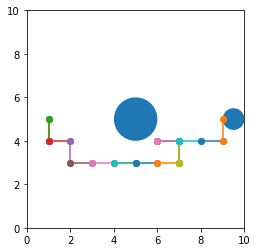

episode 589, the reward is 100


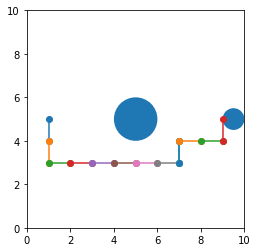

episode 590, the reward is 100


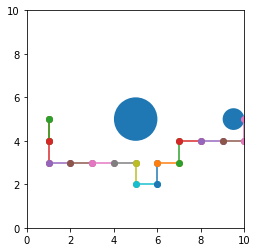

episode 591, the reward is 100


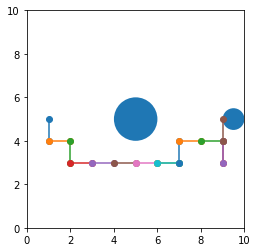

episode 592, the reward is 100


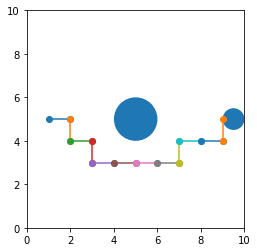

episode 593, the reward is 100


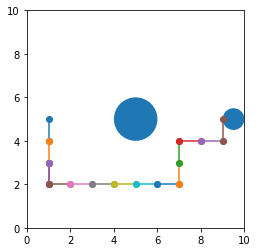

episode 594, the reward is 100


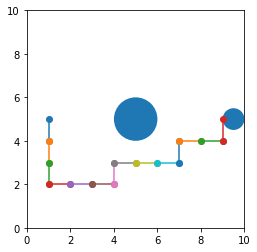

episode 595, the reward is 100


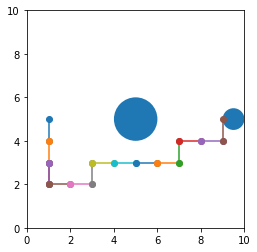

episode 596, the reward is 100


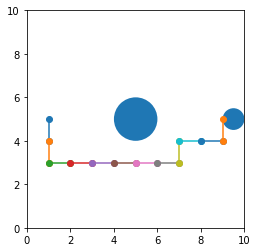

episode 597, the reward is 100


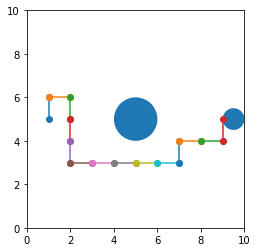

episode 598, the reward is 100


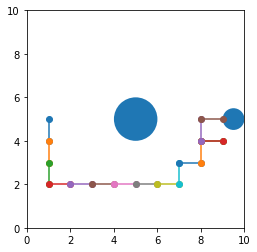

episode 599, the reward is 100


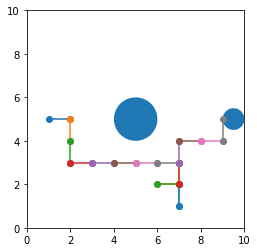

episode 600, the reward is -100


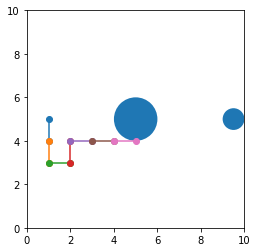

episode 601, the reward is 100


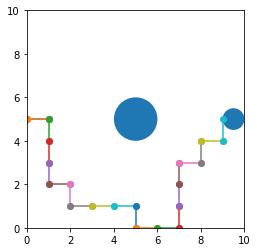

episode 602, the reward is 100


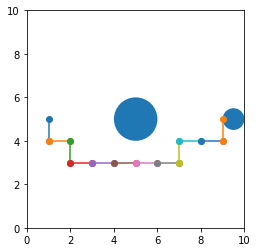

episode 603, the reward is 100


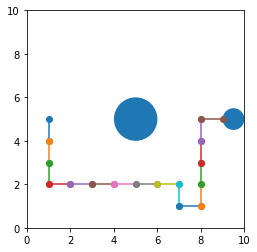

episode 604, the reward is 100


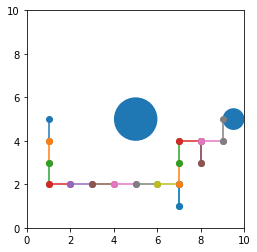

episode 605, the reward is 100


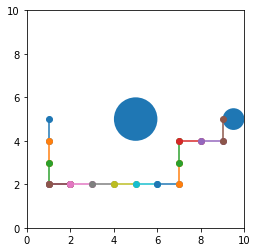

!
episode 606, the reward is 100


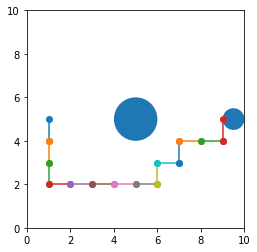

episode 607, the reward is 100


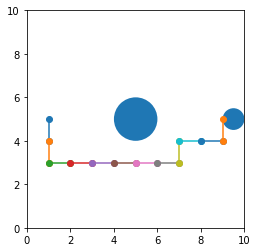

episode 608, the reward is 100


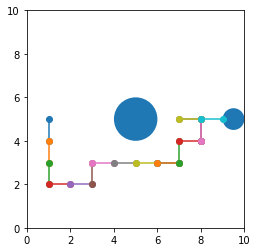

episode 609, the reward is 100


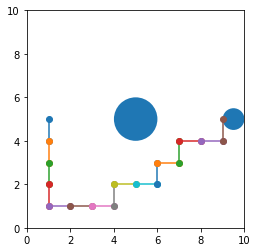

episode 610, the reward is 100


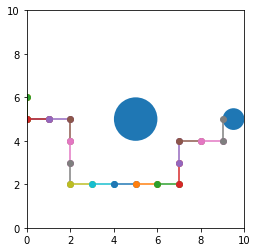

episode 611, the reward is 100


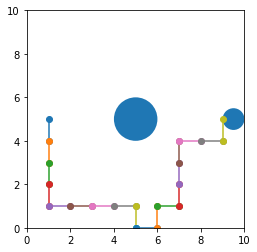

episode 612, the reward is 100


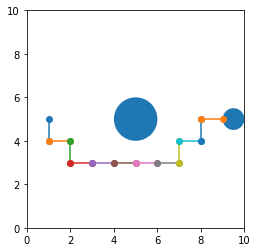

episode 613, the reward is 100


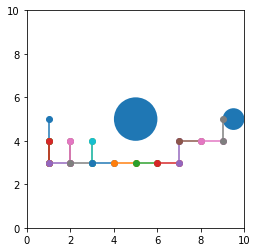

episode 614, the reward is 100


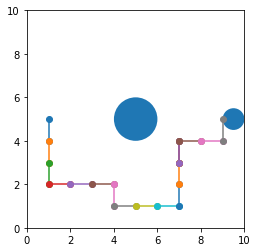

episode 615, the reward is 100


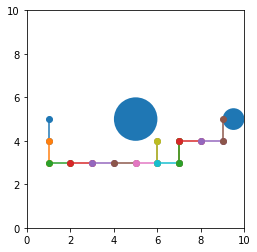

episode 616, the reward is 100


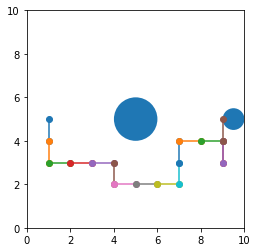

episode 617, the reward is -100


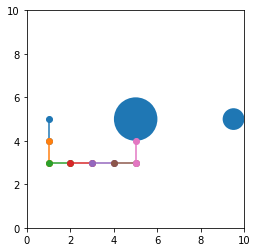

episode 618, the reward is 100


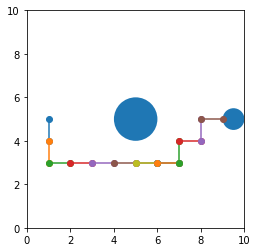

episode 619, the reward is 100


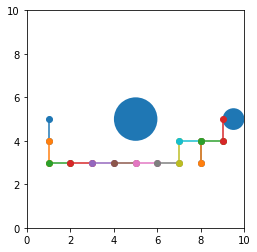

episode 620, the reward is 100


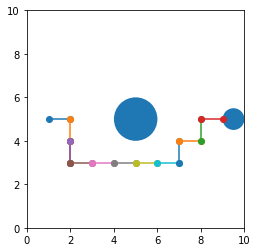

episode 621, the reward is 100


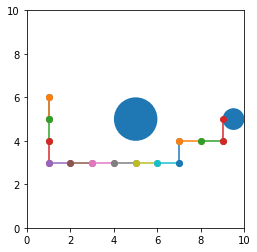

episode 622, the reward is 100


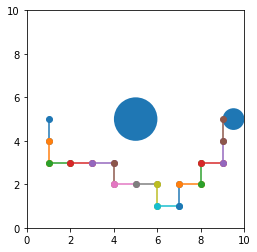

episode 623, the reward is 100


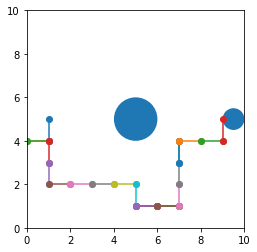

episode 624, the reward is -100


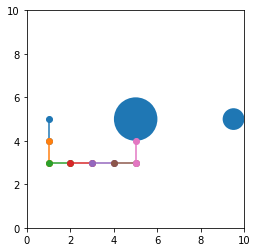

episode 625, the reward is 100


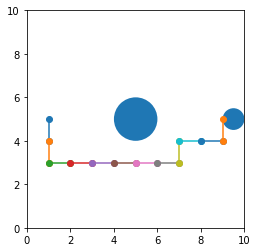

episode 626, the reward is 100


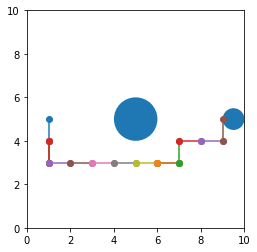

episode 627, the reward is 100


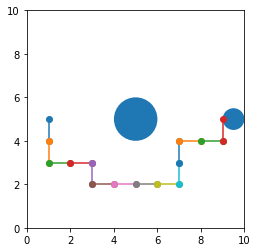

episode 628, the reward is 100


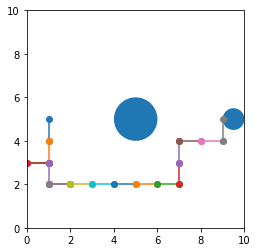

episode 629, the reward is 100


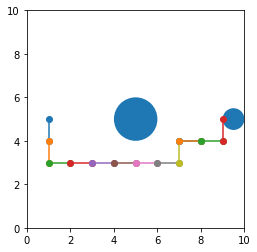

episode 630, the reward is 100


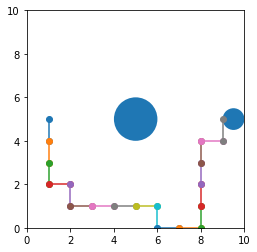

episode 631, the reward is 100


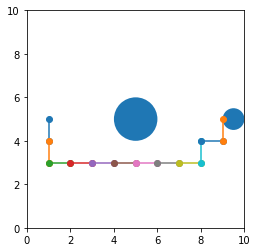

episode 632, the reward is -100


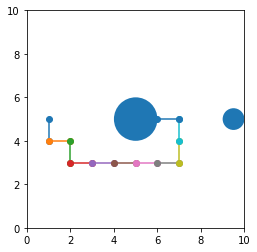

episode 633, the reward is 100


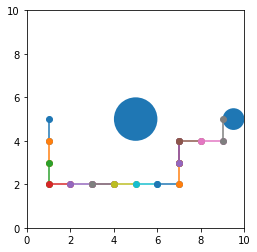

episode 634, the reward is 100


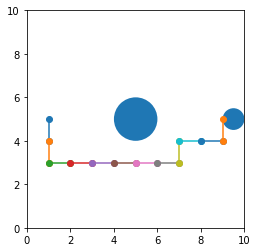

episode 635, the reward is -100


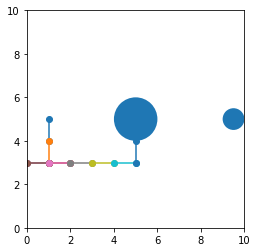

episode 636, the reward is 100


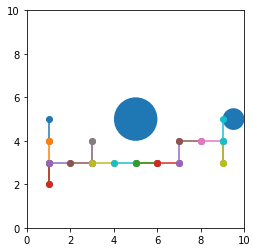

episode 637, the reward is 100


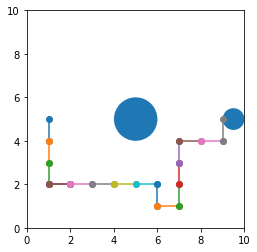

episode 638, the reward is 100


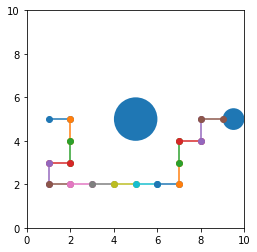

!
episode 639, the reward is 100


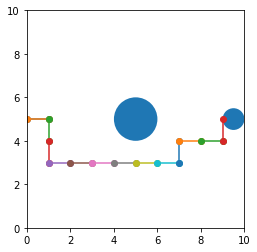

episode 640, the reward is 100


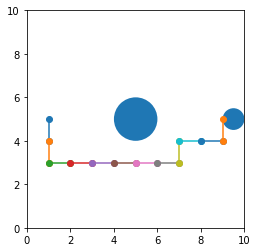

episode 641, the reward is 100


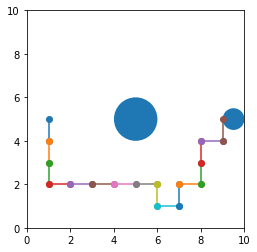

episode 642, the reward is 100


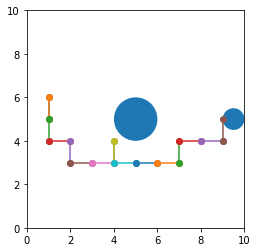

episode 643, the reward is 100


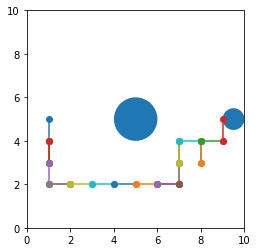

episode 644, the reward is -100


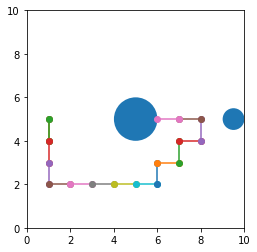

episode 645, the reward is 100


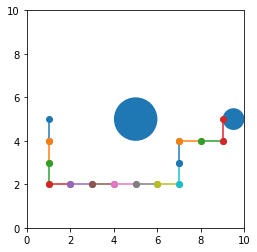

episode 646, the reward is 100


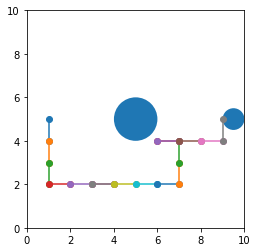

episode 647, the reward is 100


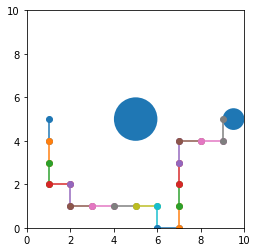

episode 648, the reward is 100


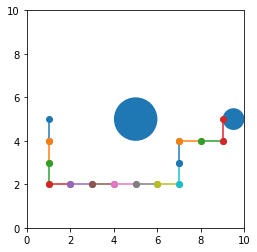

episode 649, the reward is 100


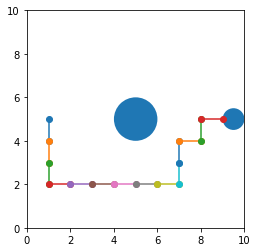

episode 650, the reward is 100


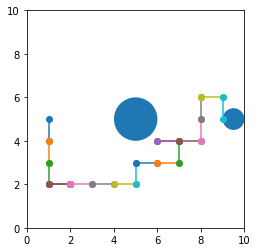

episode 651, the reward is 100


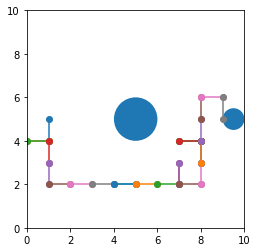

episode 652, the reward is 100


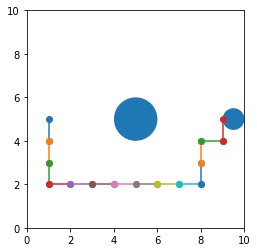

episode 653, the reward is 100


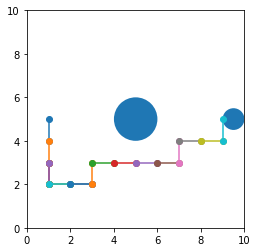

episode 654, the reward is 100


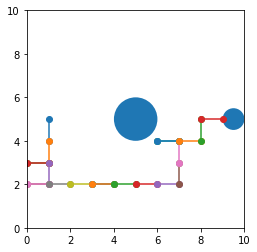

episode 655, the reward is 100


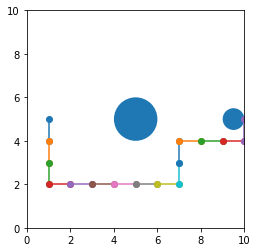

episode 656, the reward is 100


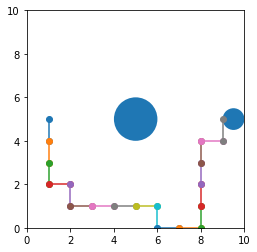

episode 657, the reward is 100


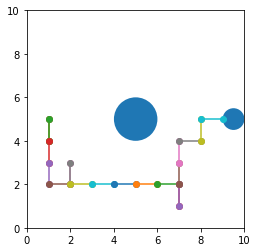

episode 658, the reward is 100


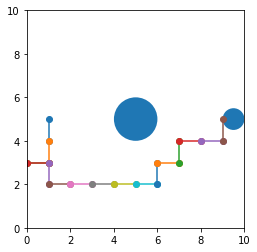

episode 659, the reward is 100


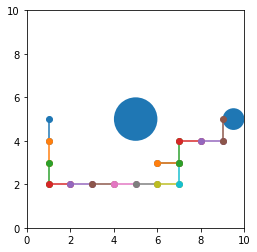

episode 660, the reward is 100


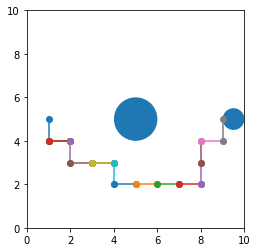

episode 661, the reward is 100


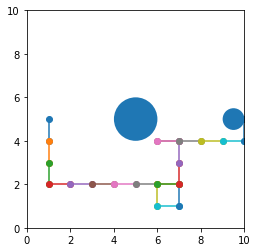

episode 662, the reward is 100


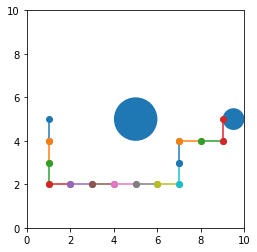

episode 663, the reward is 100


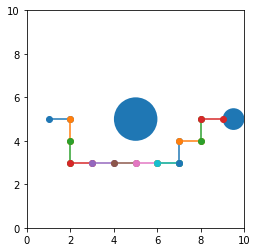

episode 664, the reward is 100


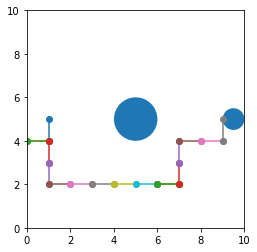

episode 665, the reward is 100


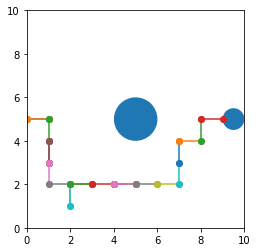

episode 666, the reward is 100


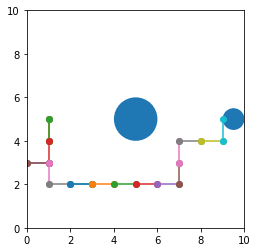

!
episode 667, the reward is 100


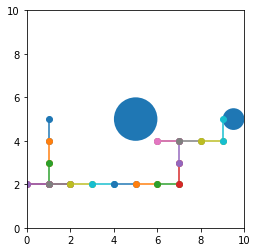

episode 668, the reward is 100


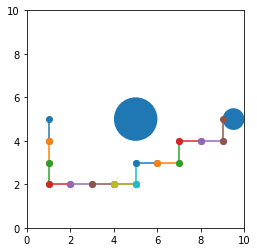

episode 669, the reward is 100


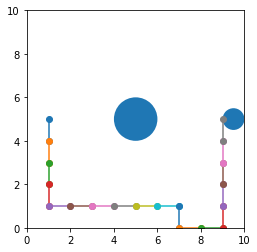

episode 670, the reward is 100


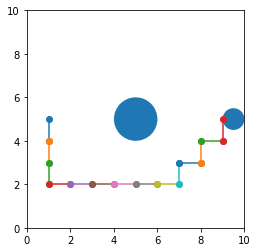

episode 671, the reward is 100


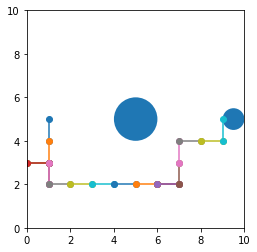

episode 672, the reward is 100


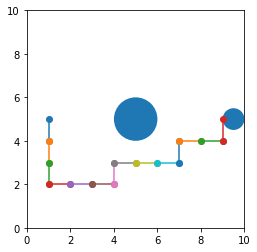

episode 673, the reward is 100


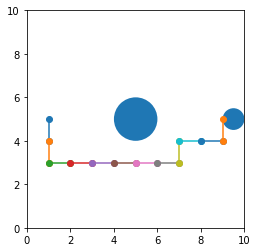

episode 674, the reward is 100


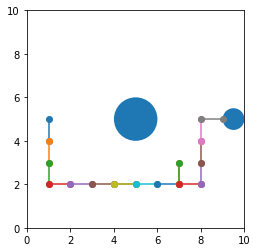

episode 675, the reward is 100


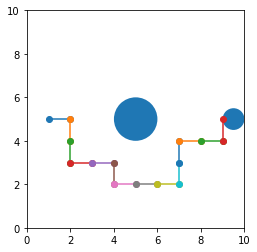

episode 676, the reward is 100


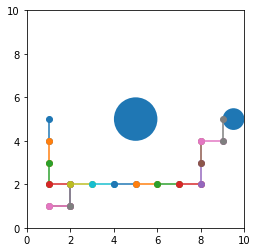

episode 677, the reward is 100


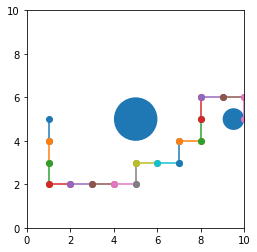

episode 678, the reward is 100


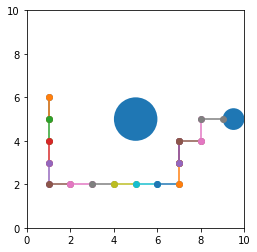

episode 679, the reward is -100


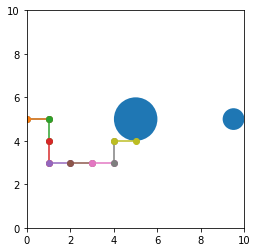

episode 680, the reward is 100


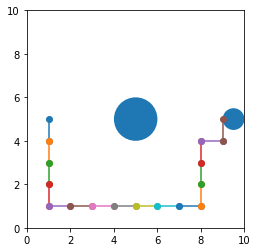

episode 681, the reward is 100


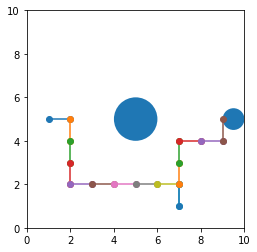

episode 682, the reward is 100


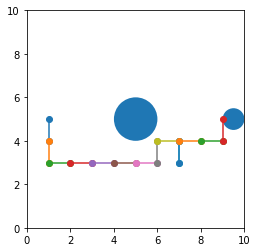

episode 683, the reward is 100


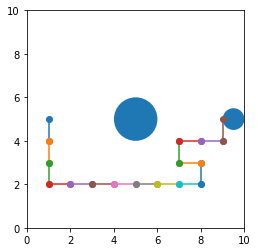

episode 684, the reward is 100


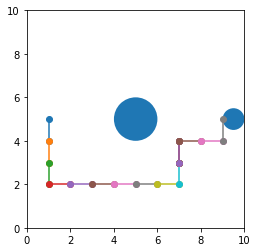

episode 685, the reward is 100


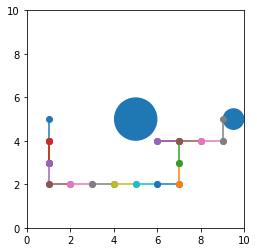

episode 686, the reward is 100


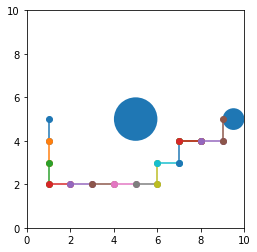

episode 687, the reward is 100


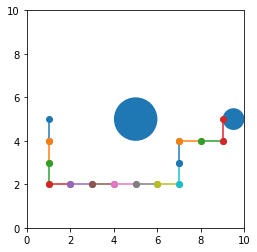

episode 688, the reward is 100


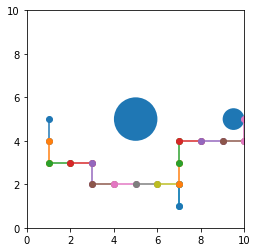

episode 689, the reward is 100


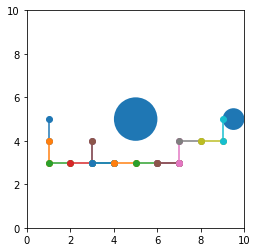

episode 690, the reward is 100


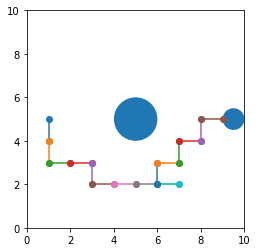

episode 691, the reward is 100


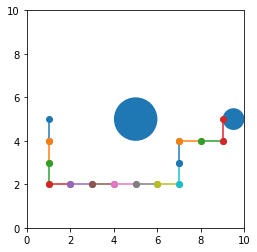

episode 692, the reward is 100


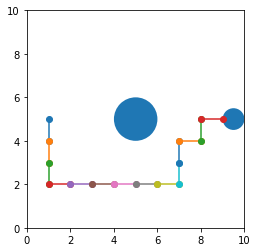

episode 693, the reward is 100


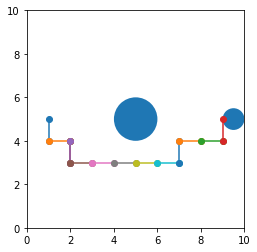

episode 694, the reward is 100


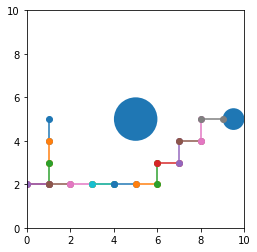

episode 695, the reward is 100


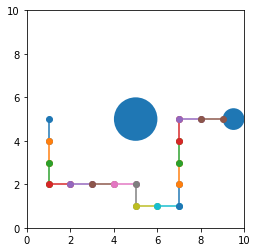

episode 696, the reward is 100


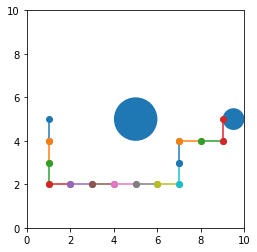

episode 697, the reward is 100


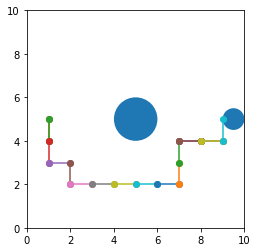

!
episode 698, the reward is 100


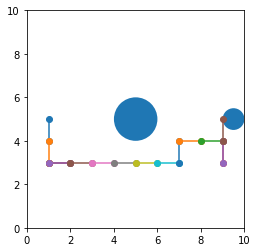

episode 699, the reward is 100


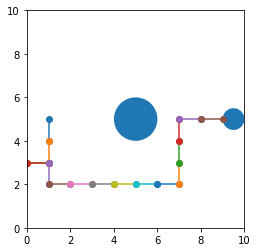

episode 700, the reward is 100


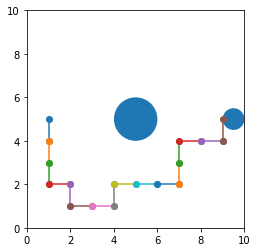

episode 701, the reward is 100


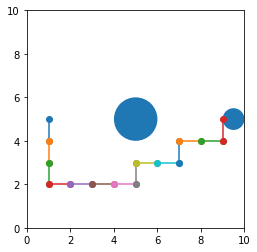

episode 702, the reward is 100


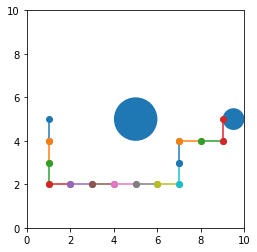

episode 703, the reward is 100


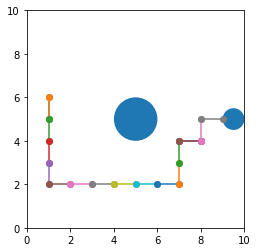

episode 704, the reward is 100


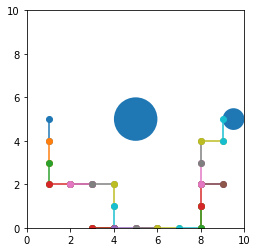

episode 705, the reward is 100


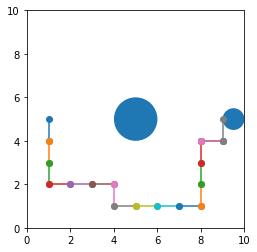

episode 706, the reward is 100


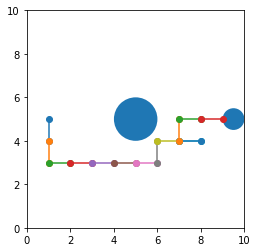

episode 707, the reward is 100


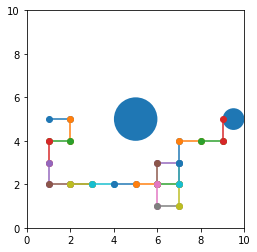

episode 708, the reward is 100


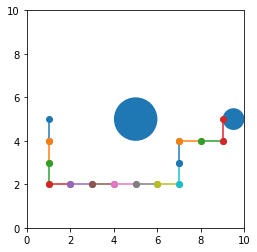

episode 709, the reward is 100


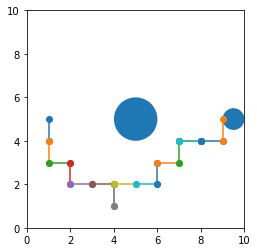

episode 710, the reward is 100


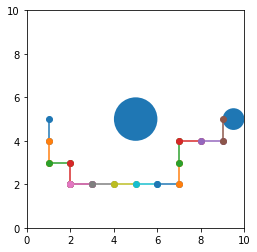

episode 711, the reward is 100


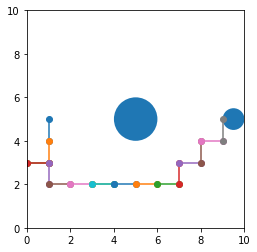

episode 712, the reward is 100


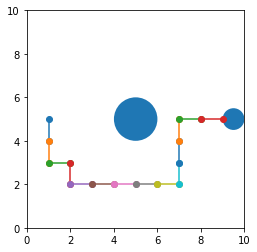

episode 713, the reward is 100


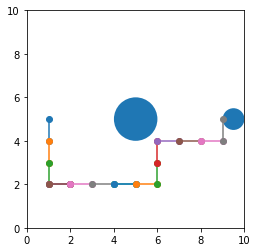

episode 714, the reward is 100


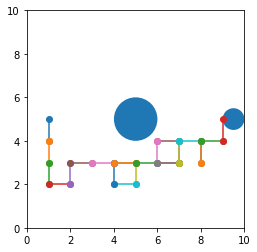

episode 715, the reward is 100


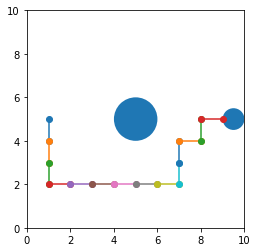

episode 716, the reward is 100


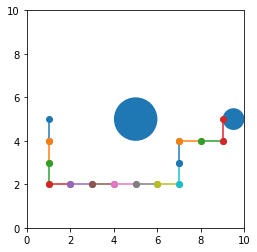

episode 717, the reward is 100


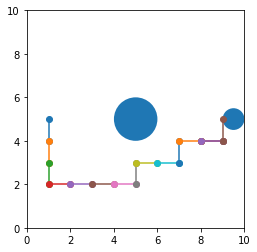

episode 718, the reward is 100


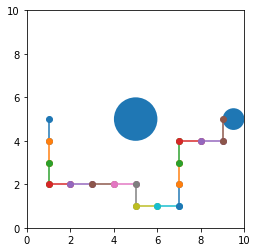

episode 719, the reward is 100


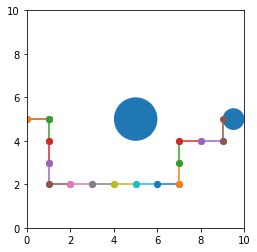

episode 720, the reward is 100


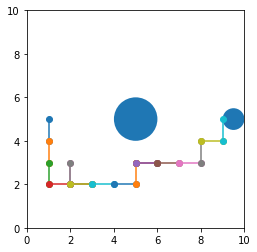

episode 721, the reward is 100


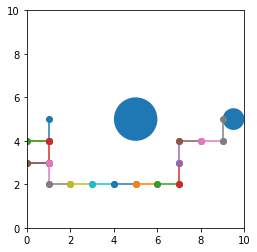

episode 722, the reward is 100


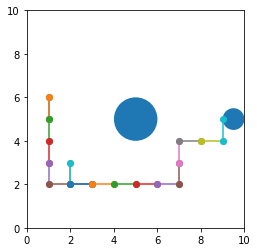

episode 723, the reward is 100


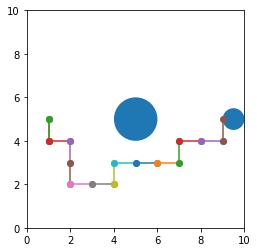

episode 724, the reward is 100


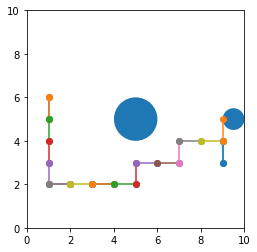

episode 725, the reward is 100


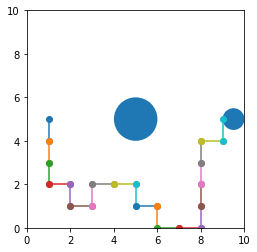

!
episode 726, the reward is 100


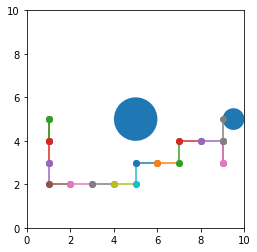

episode 727, the reward is 100


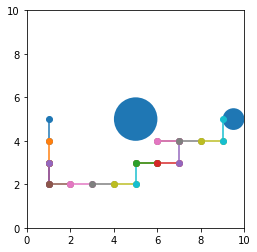

episode 728, the reward is 100


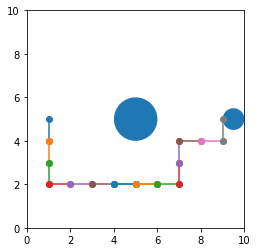

episode 729, the reward is 100


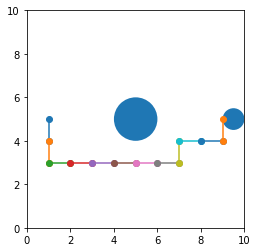

episode 730, the reward is 100


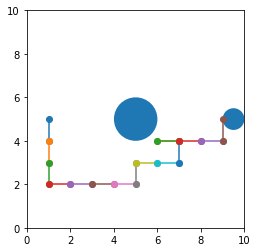

episode 731, the reward is 100


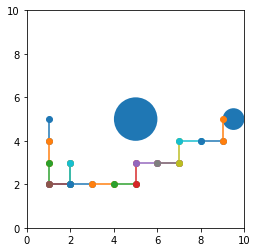

episode 732, the reward is 100


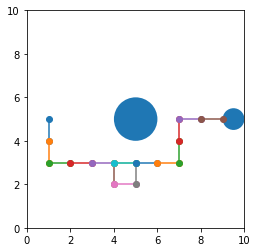

episode 733, the reward is 100


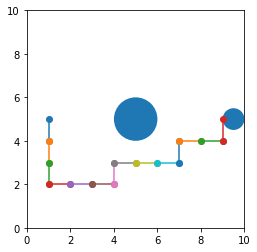

episode 734, the reward is 100


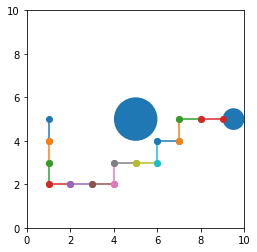

episode 735, the reward is 100


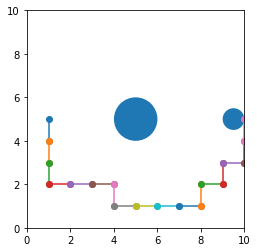

episode 736, the reward is 100


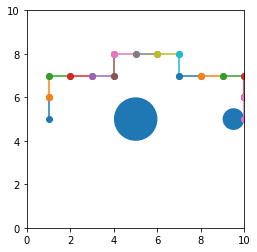

episode 737, the reward is 100


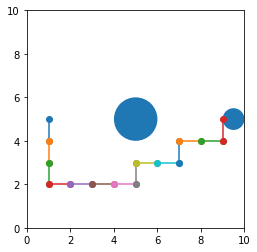

episode 738, the reward is 100


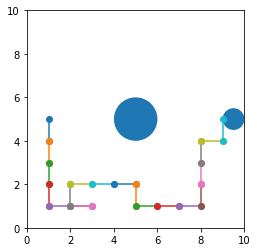

episode 739, the reward is 100


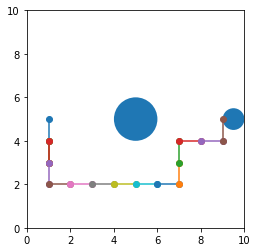

episode 740, the reward is 100


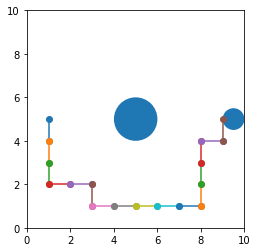

episode 741, the reward is 100


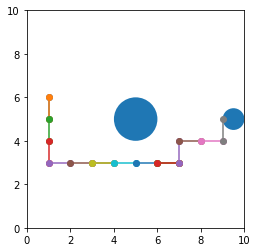

episode 742, the reward is 100


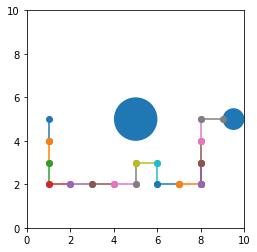

episode 743, the reward is 100


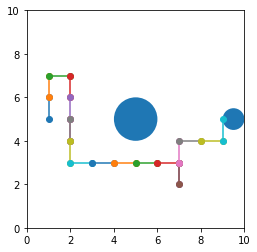

episode 744, the reward is 100


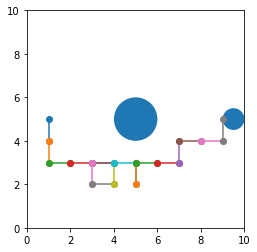

episode 745, the reward is 100


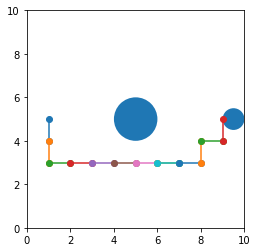

episode 746, the reward is 100


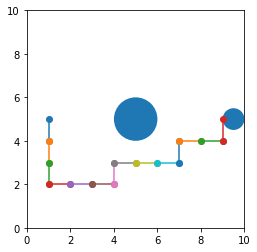

episode 747, the reward is 100


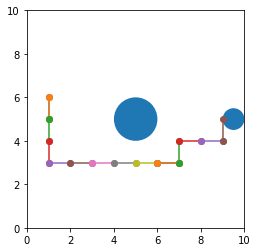

episode 748, the reward is 100


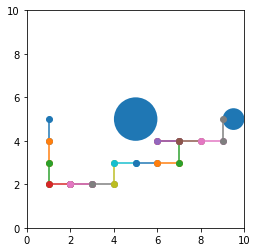

episode 749, the reward is 100


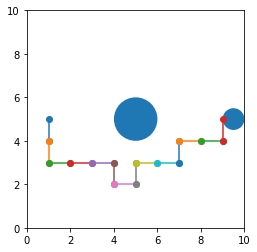

episode 750, the reward is 100


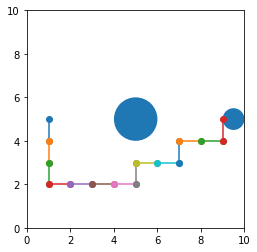

episode 751, the reward is 100


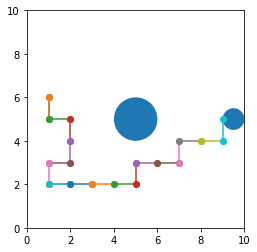

episode 752, the reward is 100


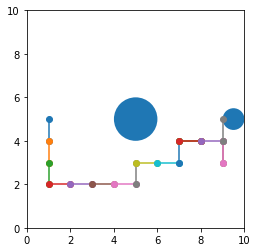

episode 753, the reward is 100


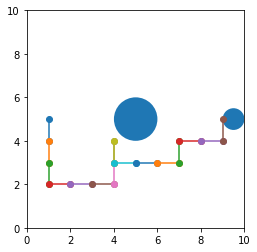

episode 754, the reward is 100


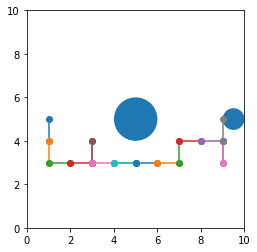

episode 755, the reward is 100


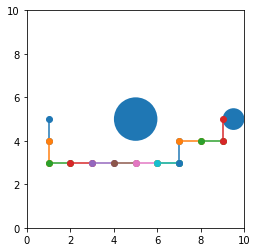

!
episode 756, the reward is 100


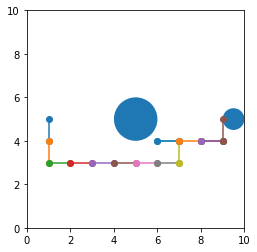

episode 757, the reward is 100


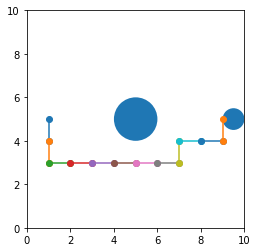

episode 758, the reward is 100


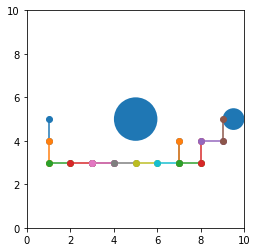

episode 759, the reward is 100


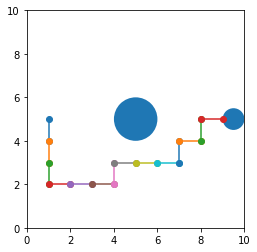

episode 760, the reward is 100


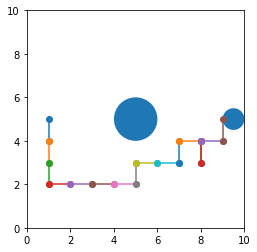

episode 761, the reward is 100


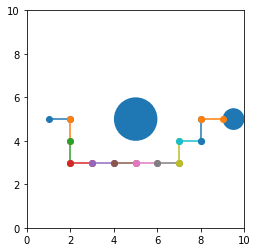

episode 762, the reward is 100


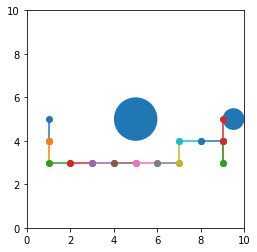

episode 763, the reward is 100


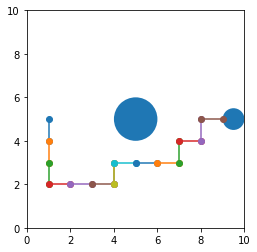

episode 764, the reward is 100


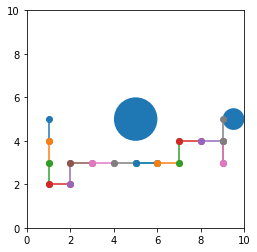

episode 765, the reward is 100


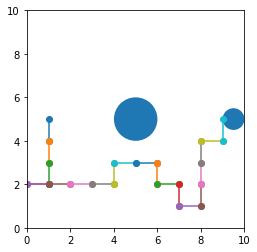

episode 766, the reward is -100


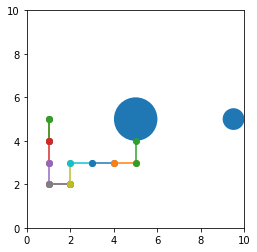

episode 767, the reward is -100


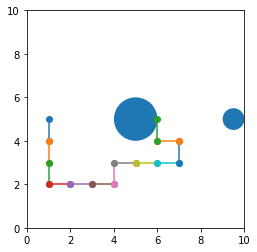

episode 768, the reward is 100


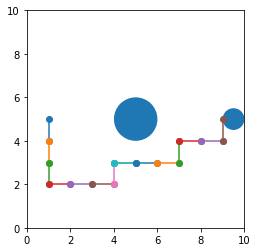

episode 769, the reward is 100


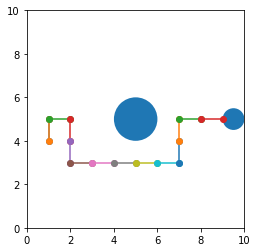

episode 770, the reward is 100


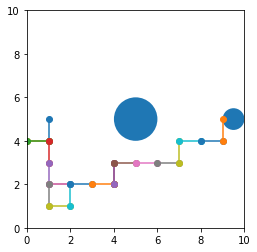

episode 771, the reward is 100


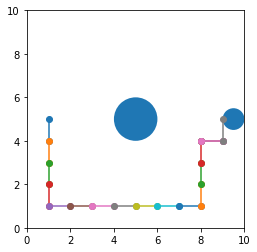

episode 772, the reward is 100


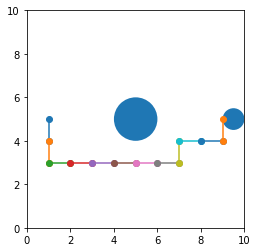

episode 773, the reward is 100


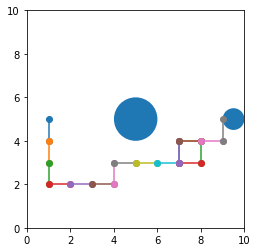

episode 774, the reward is 100


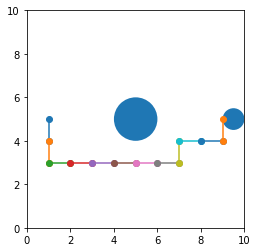

episode 775, the reward is 100


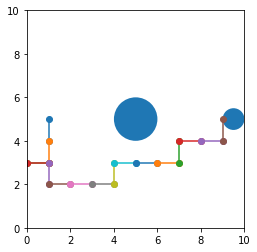

episode 776, the reward is 100


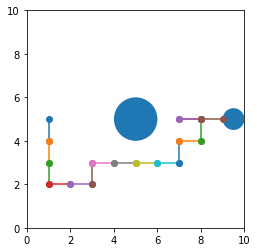

episode 777, the reward is 100


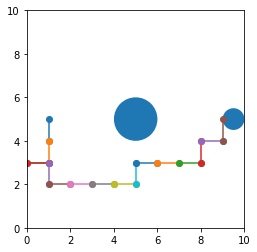

episode 778, the reward is 100


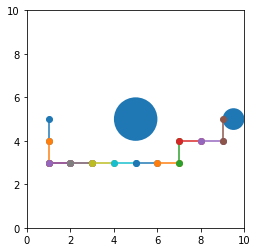

episode 779, the reward is 100


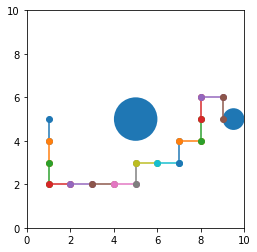

episode 780, the reward is 100


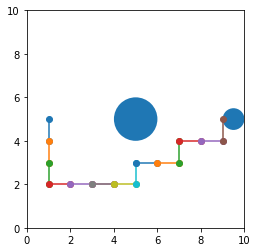

episode 781, the reward is 100


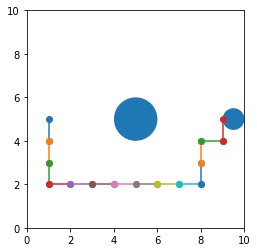

episode 782, the reward is 100


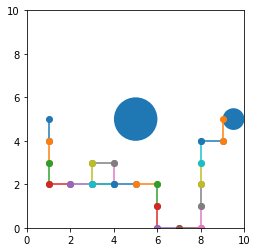

episode 783, the reward is 100


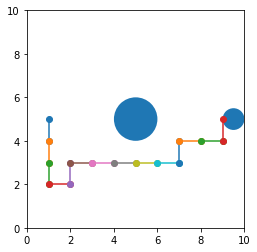

episode 784, the reward is 100


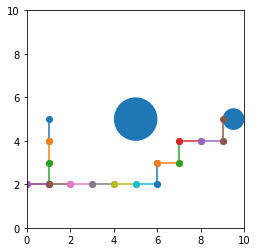

episode 785, the reward is 100


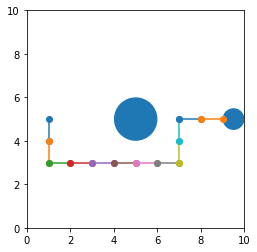

episode 786, the reward is 100


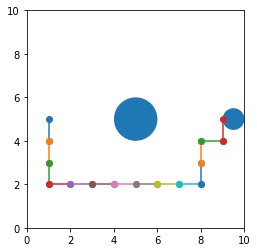

episode 787, the reward is 100


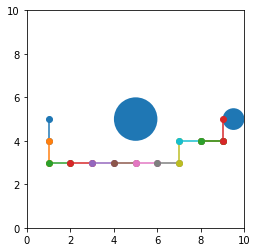

episode 788, the reward is 100


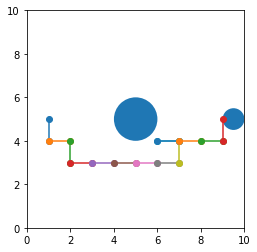

!
episode 789, the reward is 100


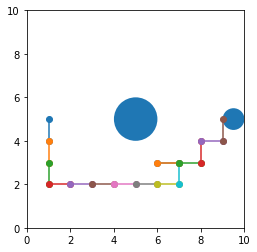

episode 790, the reward is 100


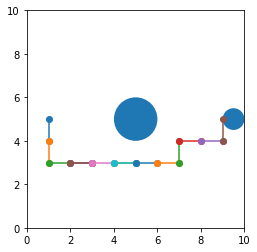

episode 791, the reward is 100


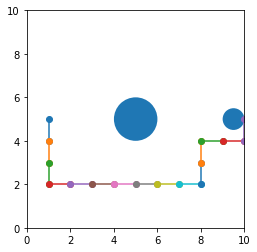

episode 792, the reward is 100


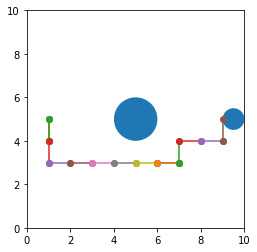

episode 793, the reward is 100


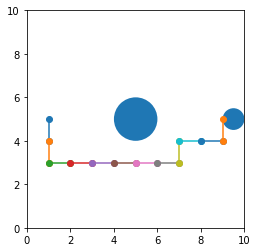

episode 794, the reward is 100


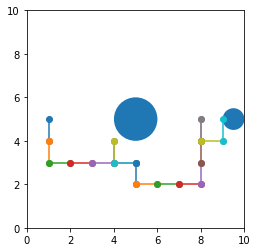

episode 795, the reward is 100


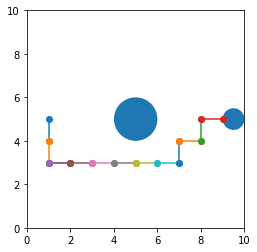

episode 796, the reward is 100


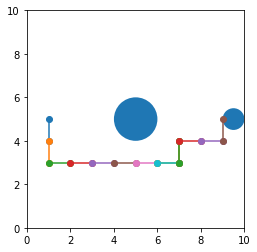

episode 797, the reward is 100


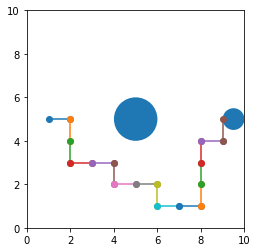

episode 798, the reward is 100


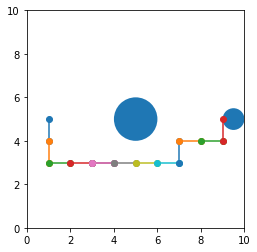

episode 799, the reward is 100


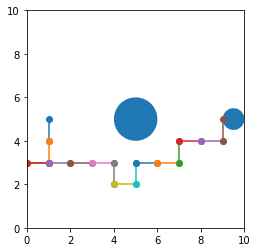

episode 800, the reward is 100


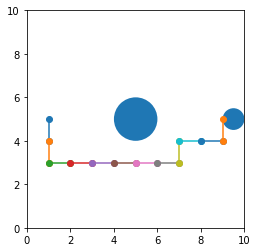

episode 801, the reward is -100


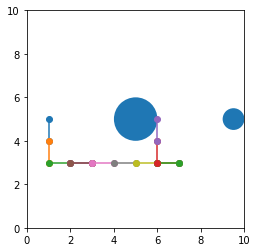

episode 802, the reward is 100


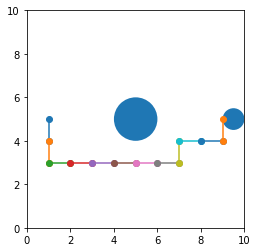

episode 803, the reward is 100


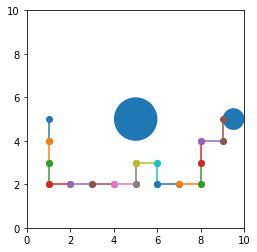

episode 804, the reward is 100


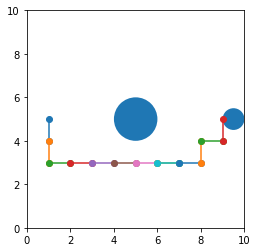

episode 805, the reward is 100


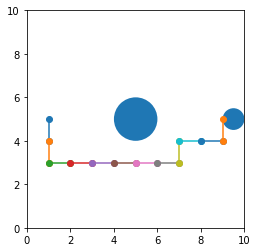

episode 806, the reward is 100


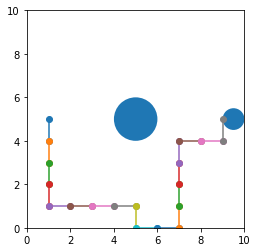

episode 807, the reward is -100


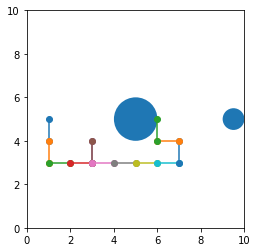

episode 808, the reward is 100


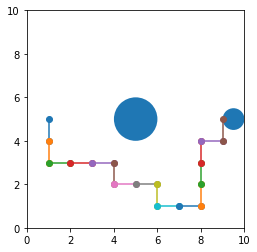

episode 809, the reward is 100


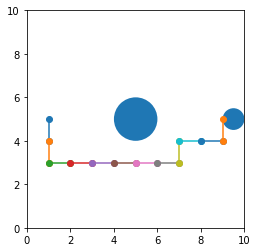

episode 810, the reward is 100


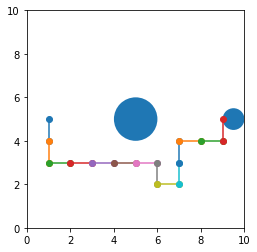

episode 811, the reward is -100


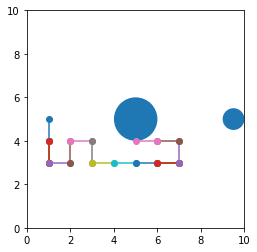

episode 812, the reward is 100


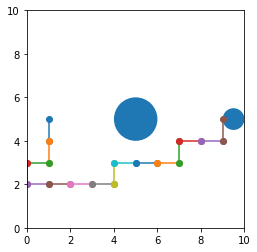

episode 813, the reward is 100


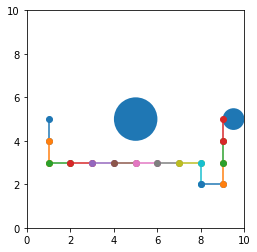

episode 814, the reward is 100


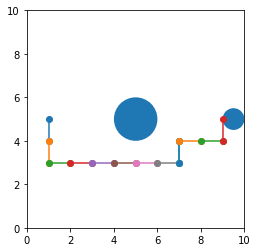

episode 815, the reward is 100


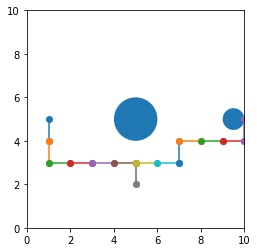

episode 816, the reward is 100


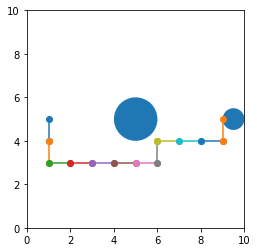

episode 817, the reward is 100


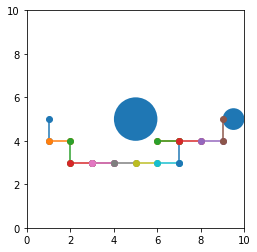

episode 818, the reward is 100


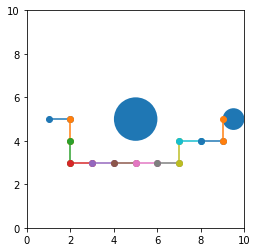

episode 819, the reward is 100


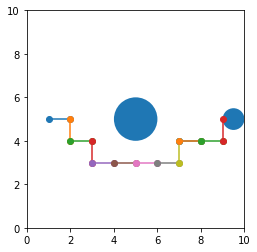

episode 820, the reward is 100


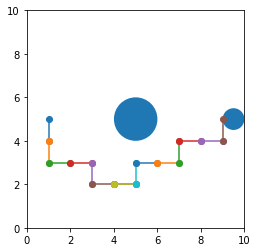

episode 821, the reward is 100


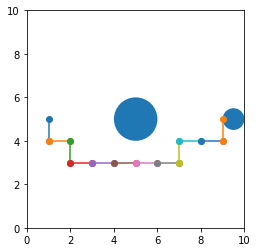

episode 822, the reward is 100


!
episode 823, the reward is 100


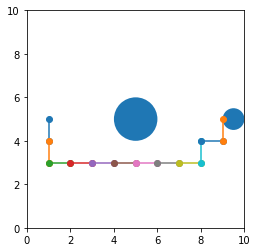

episode 824, the reward is 100


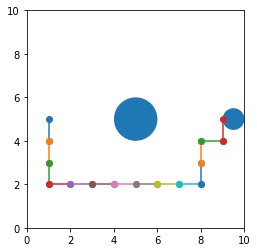

episode 825, the reward is 100


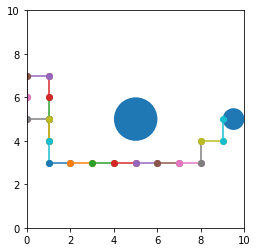

episode 826, the reward is 100


episode 827, the reward is 100


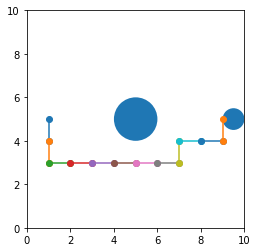

episode 828, the reward is 100


episode 829, the reward is 100


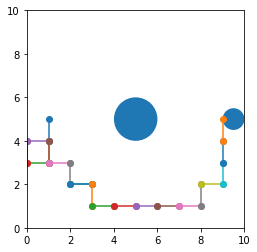

episode 830, the reward is 100


episode 831, the reward is 100


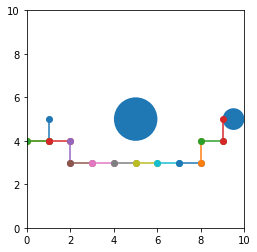

episode 832, the reward is 100


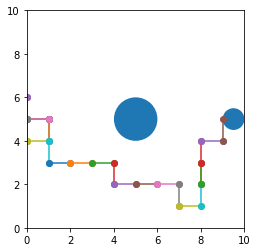

episode 833, the reward is 100


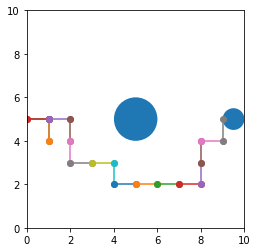

episode 834, the reward is 100


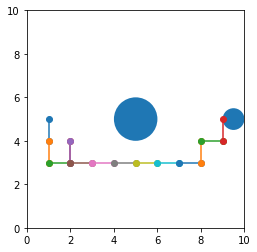

episode 835, the reward is 100


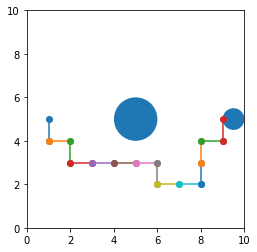

episode 836, the reward is 100


episode 837, the reward is 100


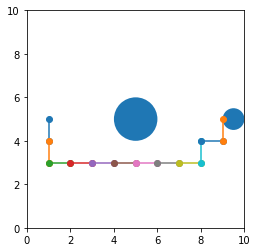

episode 838, the reward is 100


episode 839, the reward is 100


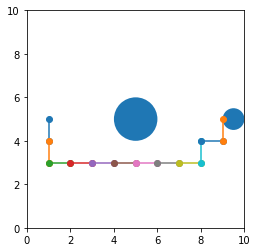

episode 840, the reward is 100


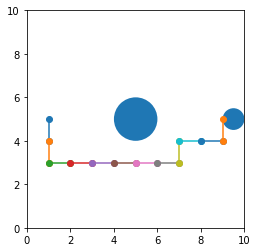

episode 841, the reward is 100


episode 842, the reward is -100


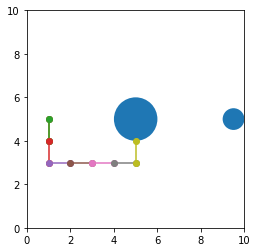

episode 843, the reward is 100


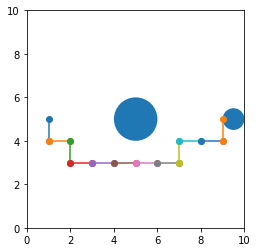

episode 844, the reward is 100


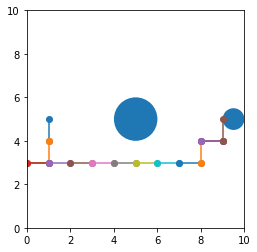

episode 845, the reward is 100


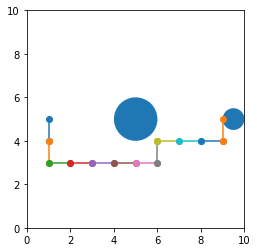

episode 846, the reward is 100


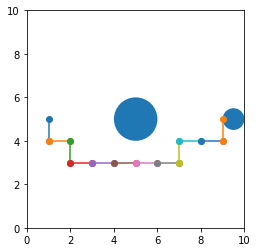

episode 847, the reward is 100


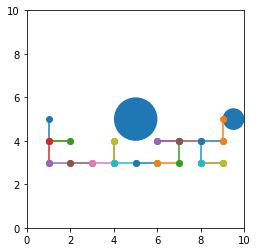

episode 848, the reward is 100


episode 849, the reward is 100


episode 850, the reward is 100


episode 851, the reward is 100


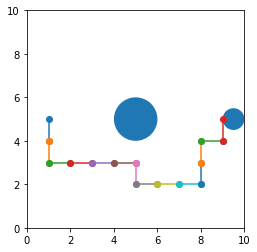

episode 852, the reward is 100


episode 853, the reward is 100


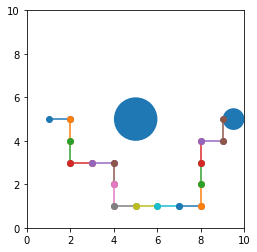

!
episode 854, the reward is 100


episode 855, the reward is 100


episode 856, the reward is 100


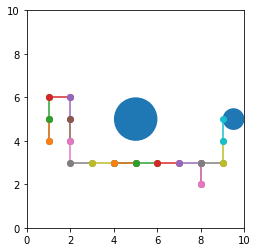

episode 857, the reward is 100


episode 858, the reward is 100


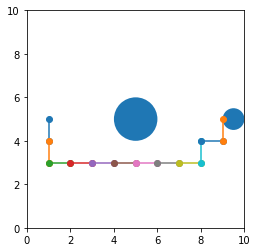

episode 859, the reward is 100


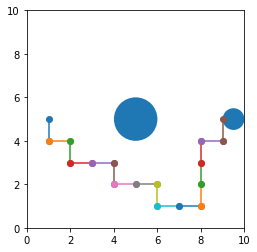

episode 860, the reward is 100


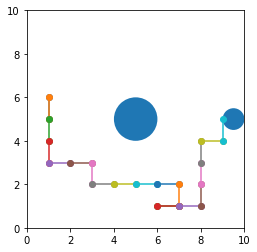

episode 861, the reward is 100


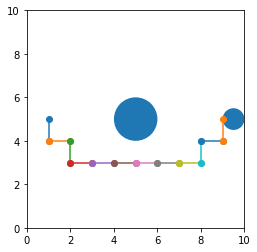

episode 862, the reward is -100


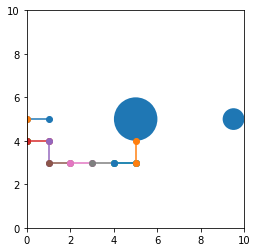

episode 863, the reward is 100


episode 864, the reward is 100


episode 865, the reward is 100


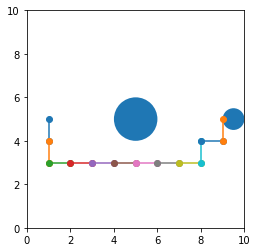

episode 866, the reward is 100


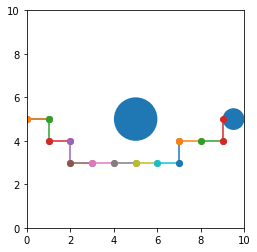

episode 867, the reward is 100


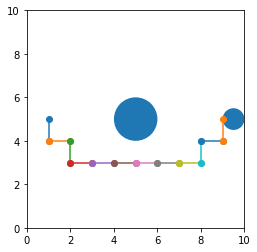

episode 868, the reward is 100


episode 869, the reward is 100


episode 870, the reward is 100


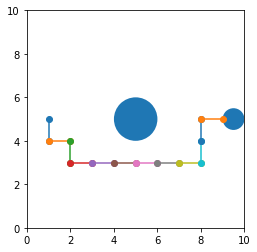

episode 871, the reward is 100


episode 872, the reward is 100


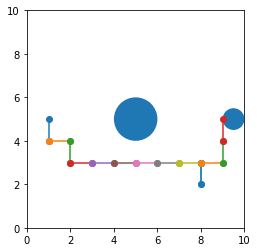

episode 873, the reward is 100


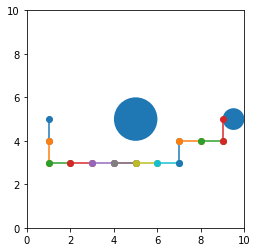

episode 874, the reward is 100


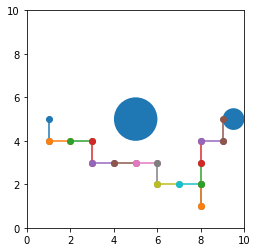

episode 875, the reward is 100


episode 876, the reward is 100


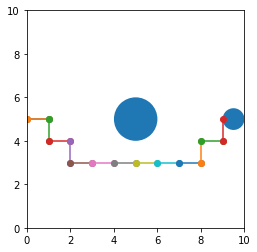

episode 877, the reward is 100


episode 878, the reward is 100


episode 879, the reward is 100


episode 880, the reward is 100


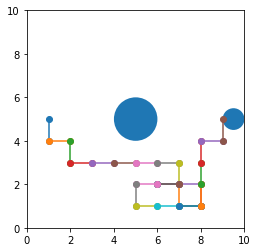

episode 881, the reward is 100


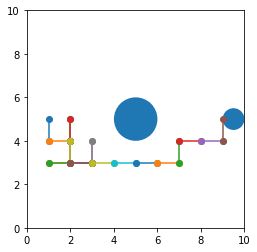

episode 882, the reward is 100


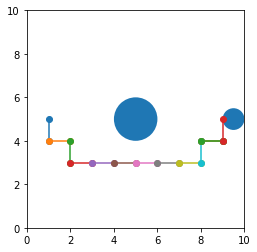

episode 883, the reward is 100


episode 884, the reward is 100


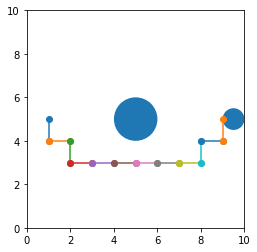

!
episode 885, the reward is 100


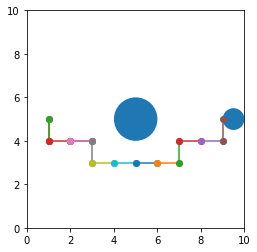

episode 886, the reward is 100


episode 887, the reward is 100


episode 888, the reward is 100


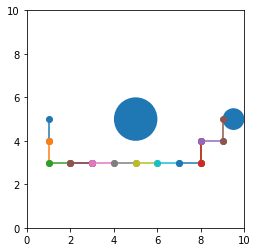

episode 889, the reward is 100


episode 890, the reward is 100


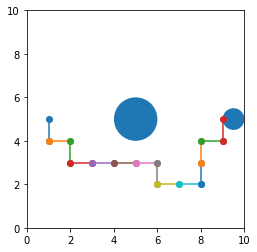

episode 891, the reward is -100


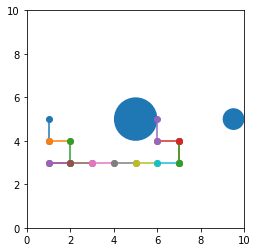

episode 892, the reward is 100


episode 893, the reward is 100


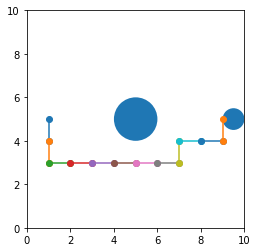

episode 894, the reward is 100


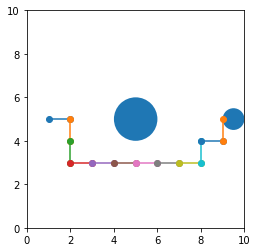

episode 895, the reward is 100


episode 896, the reward is 100


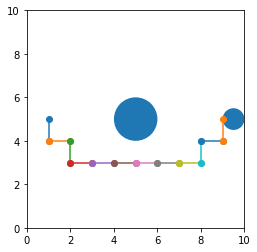

episode 897, the reward is 100


episode 898, the reward is 100


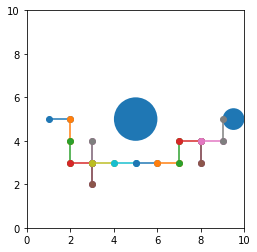

episode 899, the reward is 100


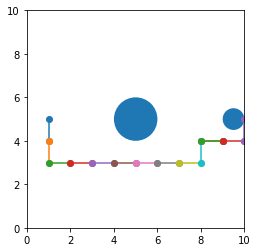

episode 900, the reward is 100


episode 901, the reward is 100


episode 902, the reward is 100


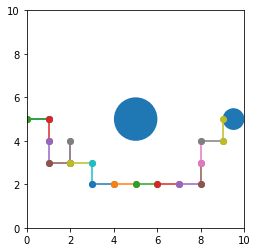

episode 903, the reward is 100


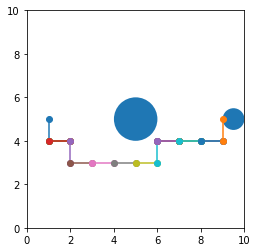

episode 904, the reward is 100


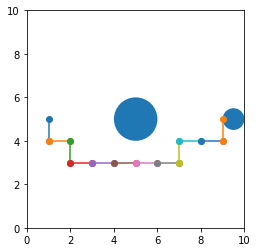

episode 905, the reward is 100


episode 906, the reward is 100


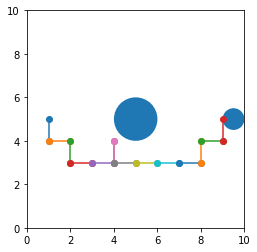

episode 907, the reward is -100


episode 908, the reward is 100


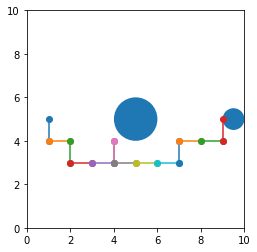

episode 909, the reward is 100


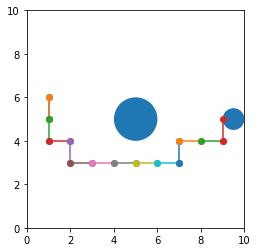

episode 910, the reward is 100


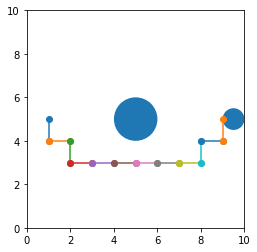

episode 911, the reward is 100


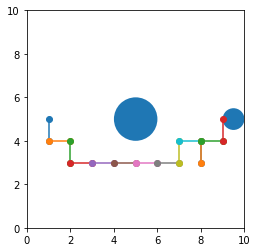

episode 912, the reward is 100


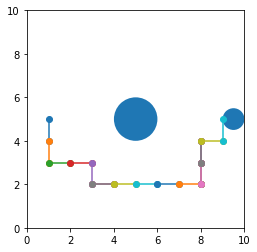

episode 913, the reward is 100


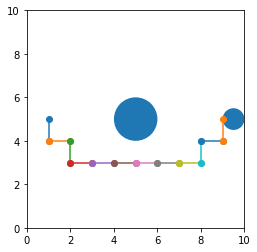

episode 914, the reward is 100


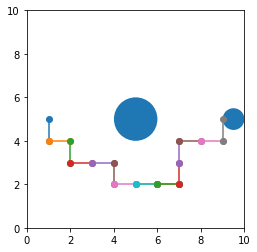

episode 915, the reward is 100


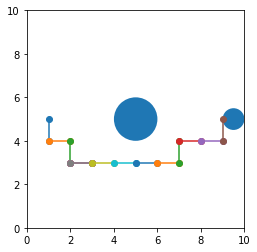

episode 916, the reward is 100


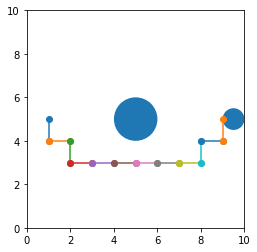

episode 917, the reward is 100


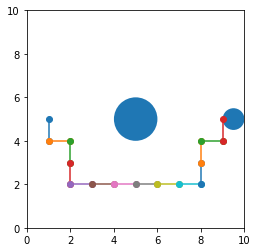

!
episode 918, the reward is 100


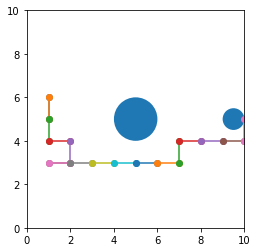

episode 919, the reward is -100


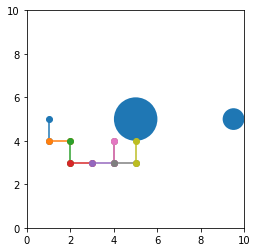

episode 920, the reward is 100


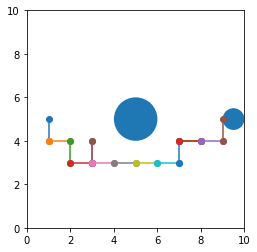

episode 921, the reward is 100


episode 922, the reward is 100


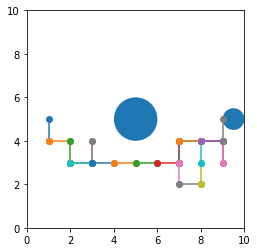

episode 923, the reward is 100


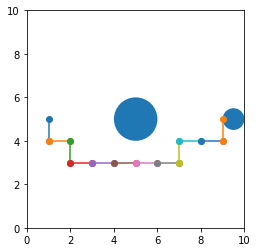

episode 924, the reward is 100


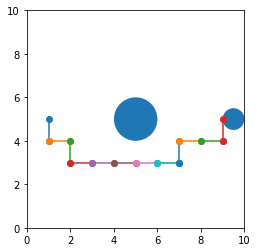

episode 925, the reward is 100


episode 926, the reward is 100


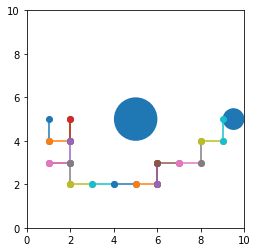

episode 927, the reward is 100


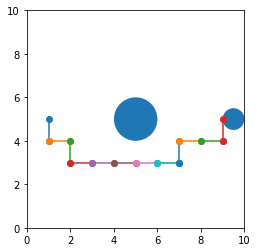

episode 928, the reward is 100


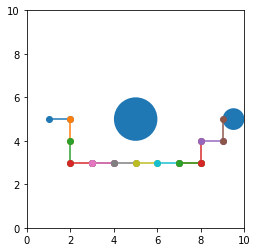

episode 929, the reward is 100


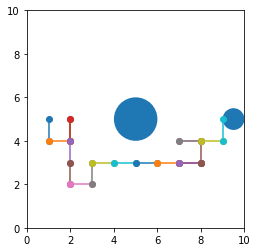

episode 930, the reward is 100


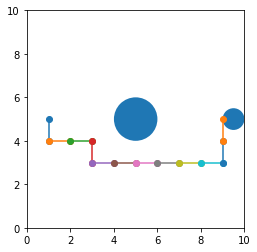

episode 931, the reward is 100


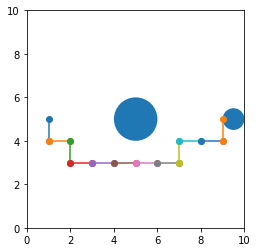

episode 932, the reward is 100


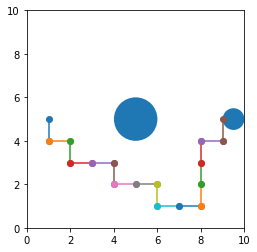

episode 933, the reward is 100


episode 934, the reward is 100


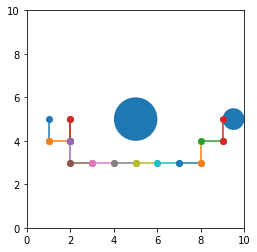

episode 935, the reward is 100


episode 936, the reward is 100


episode 937, the reward is 100


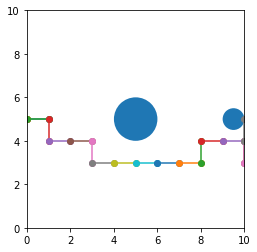

episode 938, the reward is 100


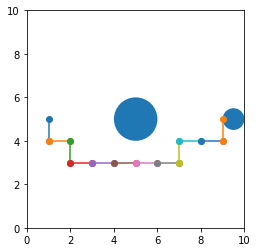

episode 939, the reward is 100


episode 940, the reward is 100


episode 941, the reward is 100


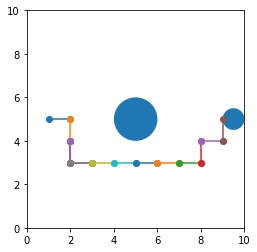

episode 942, the reward is 100


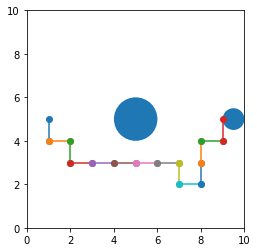

episode 943, the reward is 100


episode 944, the reward is 100


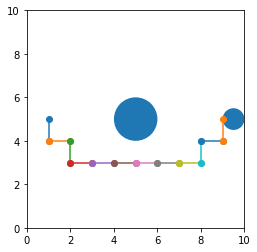

episode 945, the reward is 100


episode 946, the reward is 100


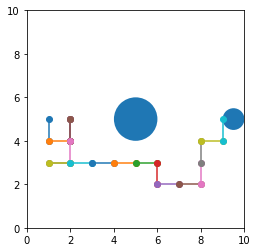

episode 947, the reward is 100


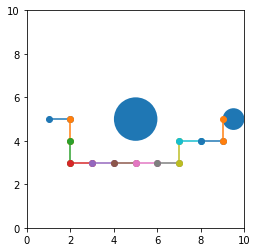

episode 948, the reward is 100


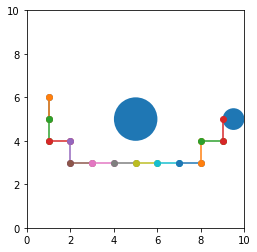

!
episode 949, the reward is 100


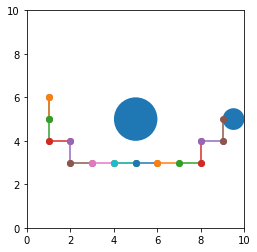

episode 950, the reward is 100


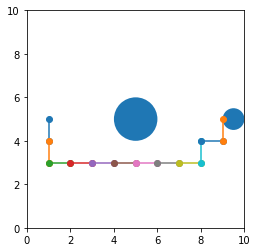

episode 951, the reward is 100


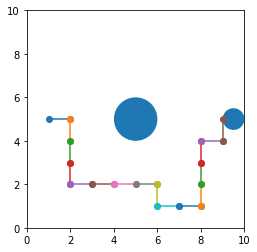

episode 952, the reward is 100


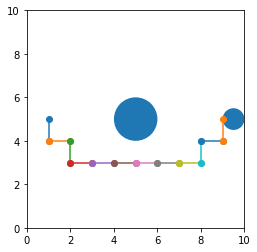

episode 953, the reward is 100


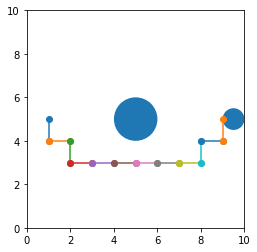

episode 954, the reward is -100


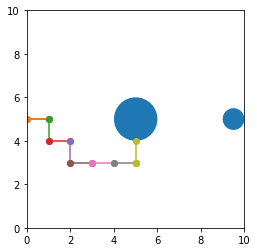

episode 955, the reward is 100


episode 956, the reward is 100


episode 957, the reward is 100


episode 958, the reward is 100


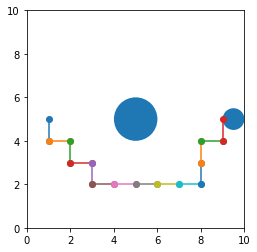

episode 959, the reward is -100


episode 960, the reward is 100


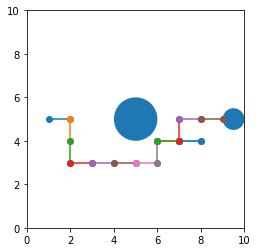

episode 961, the reward is 100


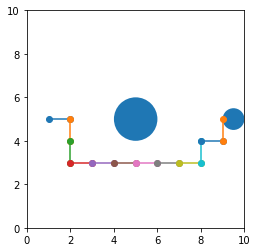

episode 962, the reward is 100


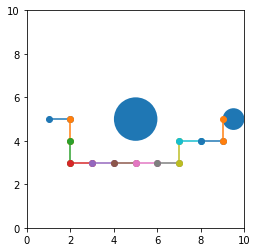

episode 963, the reward is 100


episode 964, the reward is 100


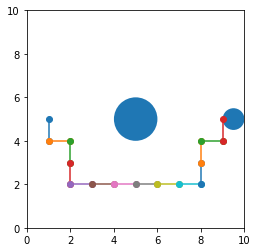

episode 965, the reward is 100


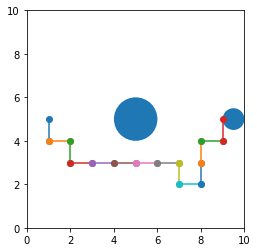

episode 966, the reward is 100


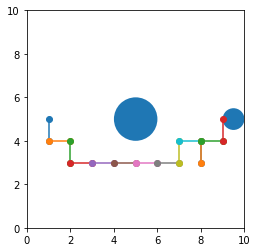

episode 967, the reward is -100


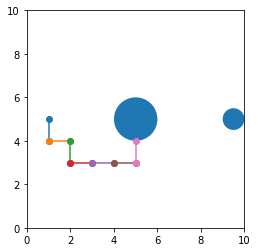

episode 968, the reward is 100


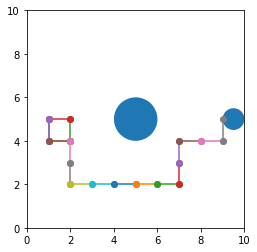

episode 969, the reward is 100


episode 970, the reward is 100


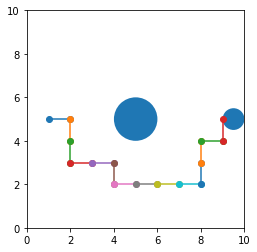

episode 971, the reward is 100


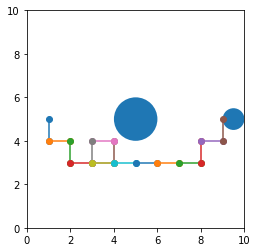

episode 972, the reward is 100


episode 973, the reward is 100


episode 974, the reward is 100


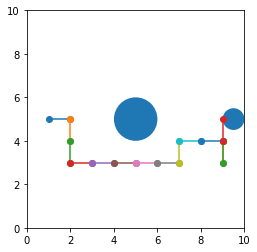

episode 975, the reward is 100


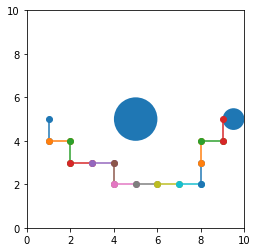

episode 976, the reward is 100


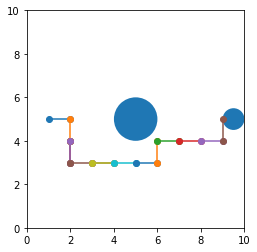

episode 977, the reward is 100


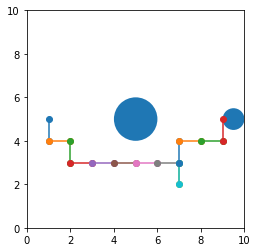

episode 978, the reward is 100


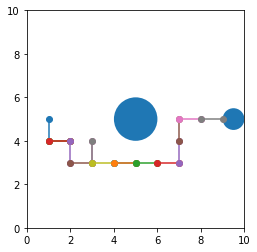

episode 979, the reward is 100


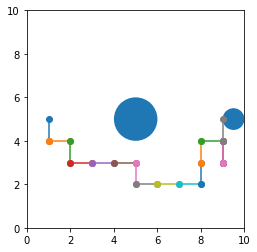

episode 980, the reward is 100


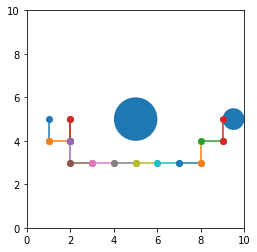

episode 981, the reward is 100


episode 982, the reward is 100


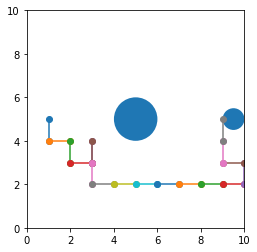

episode 983, the reward is 100


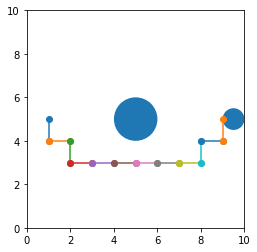

!
episode 984, the reward is 100


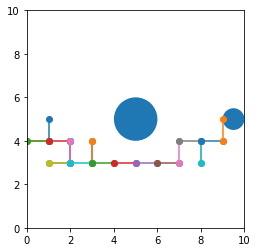

episode 985, the reward is 100


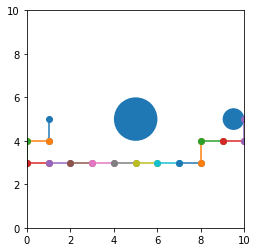

episode 986, the reward is 100


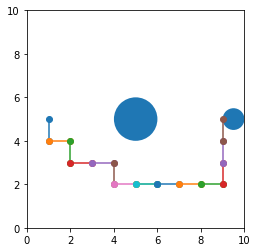

episode 987, the reward is 100


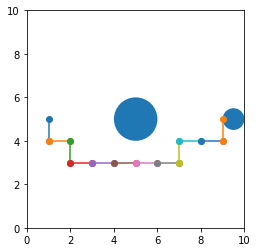

episode 988, the reward is 100


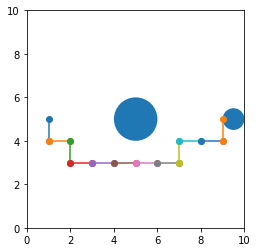

episode 989, the reward is 100


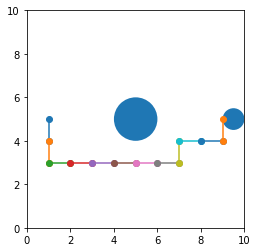

episode 990, the reward is 100


episode 991, the reward is 100


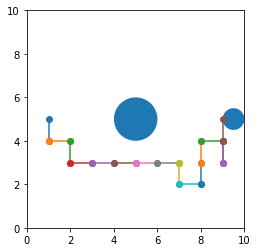

episode 992, the reward is 100


episode 993, the reward is 100


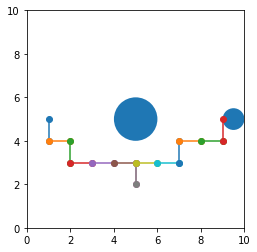

episode 994, the reward is 100


episode 995, the reward is 100


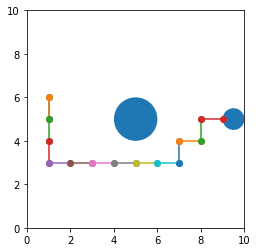

episode 996, the reward is 100


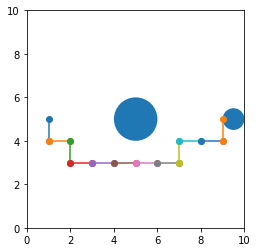

episode 997, the reward is 100


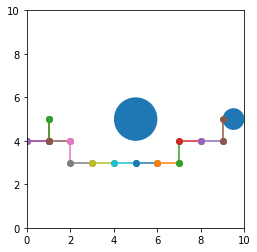

episode 998, the reward is 100


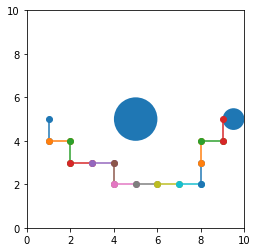

episode 999, the reward is 100


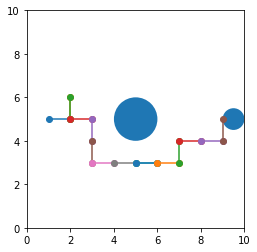

In [88]:
def main():
    net = DQN()
    print("The DQN is collecting experience...")
    step_counter_list = []
    for episode in range(EPISODES):
        state = env.reset()
        step_counter = 0
        while True:
            step_counter +=1
            action = net.choose_action(state)
            next_state, reward, done = env.step(action)
            # reward = reward * 100 if reward > 0 else reward * 5
            net.store_trans(state, action, reward, next_state)

            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
                if done:
                    print("episode {}, the reward is {}".format(episode, round(reward, 3)))
            if done:
                step_counter_list.append(step_counter)
                env.draw_map()
                # net.plot(net.ax, step_counter_list)
                break

            state = next_state
            

if __name__ == '__main__':
    main()

In [6]:
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions
        print(self.actions)
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.q_table_final = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        
        if np.random.uniform() < self.epsilon:
            state_action = self.q_table.loc[observation, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))
            action = state_action.idxmax()
        else:
            action = np.random.choice(self.actions)
        return action

    def learn(self, state, action, reward, next_state):
        self.check_state_exist(next_state)

        q_predict = self.q_table.loc[state, action]

        if next_state != 'goal' or next_state != 'obstacle':
            q_target = reward + self.gamma * self.q_table.loc[next_state, :].max()
        else:
            q_target = reward
        self.q_table.loc[state, action] += self.lr * (q_target - q_predict)

        return self.q_table.loc[state, action]

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )